In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import utils as ut

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', 1000)

from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [7]:
# thoughts
# predict using dx from drugs
# predict using drugs themselves
# look at families of drugs, e.g. opioids
# predict using history dx

# other library for reading files - try glob

# https://www.ajmc.com/view/predicting-hospitalizations-from-electronic-health-record-data

# clean up med conditions
# try Lindsey's idea - compare med conditions and drug dx
# visualize variables
# try PCA
# reduce dimensions to 10 or so
# plot confusion matrices
# try mn bayes

In [8]:
questions = pd.read_excel('history-questions.xlsx')

In [9]:
demo_j = ut.import_and_decode('data/demo_j.xpt') # demographics
acq_j = ut.import_and_decode('data/acq_j.xpt')
alq_j = ut.import_and_decode('data/alq_j.xpt')
auq_j = ut.import_and_decode('data/auq_j.xpt')
bpq_j = ut.import_and_decode('data/bpq_j.xpt')
cdq_j = ut.import_and_decode('data/cdq_j.xpt')
dbq_j = ut.import_and_decode('data/dbq_j.xpt')
diq_j = ut.import_and_decode('data/diq_j.xpt') # diabetes
duq_j = ut.import_and_decode('data/duq_j.xpt')
ecq_j = ut.import_and_decode('data/ecq_j.xpt')
heq_j = ut.import_and_decode('data/heq_j.xpt')
hsq_j = ut.import_and_decode('data/hsq_j.xpt')
huq_j = ut.import_and_decode('data/huq_j.xpt') # hospital utilization and access to care
kiq_u_j = ut.import_and_decode('data/kiq_u_j.xpt')
mcq_j = ut.import_and_decode('data/mcq_j.xpt') # medical conditions
ocq_j = ut.import_and_decode('data/ocq_j.xpt')
ohq_j = ut.import_and_decode('data/ohq_j.xpt')
osq_j = ut.import_and_decode('data/osq_j.xpt')
rhq_j = ut.import_and_decode('data/rhq_j.xpt')
rxqasa_j = ut.import_and_decode('data/rxqasa_j.xpt')
rxq_rx_j = ut.import_and_decode('data/rxq_rx_j.xpt') # prescription drugs
slq_j = ut.import_and_decode('data/slq_j.xpt')
smqfam_j = ut.import_and_decode('data/smqfam_j.xpt')
smqshs_j = ut.import_and_decode('data/smqshs_j.xpt')
smq_j = ut.import_and_decode('data/smq_j.xpt')
vtq_j = ut.import_and_decode('data/vtq_j.xpt')
whqmec_j = ut.import_and_decode('data/whqmec_j.xpt')
whq_j = ut.import_and_decode('data/whq_j.xpt')

In [10]:
# first dummy model - do you take rx and how many conditions do you have - does that predict?
# does it tell me we should spend more time on rx or on disease?
# go into one route or the other
# then group drugs or group dx

In [11]:
# demographic info is in this df

demo_j

SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0     93703.00000  10.00000   2.00000   2.00000   2.00000       nan   5.00000   
1     93704.00000  10.00000   2.00000   1.00000   2.00000       nan   3.00000   
2     93705.00000  10.00000   2.00000   2.00000  66.00000       nan   4.00000   
3     93706.00000  10.00000   2.00000   1.00000  18.00000       nan   5.00000   
4     93707.00000  10.00000   2.00000   1.00000  13.00000       nan   5.00000   
...           ...       ...       ...       ...       ...       ...       ...   
9249 102952.00000  10.00000   2.00000   2.00000  70.00000       nan   5.00000   
9250 102953.00000  10.00000   2.00000   1.00000  42.00000       nan   1.00000   
9251 102954.00000  10.00000   2.00000   2.00000  41.00000       nan   4.00000   
9252 102955.00000  10.00000   2.00000   2.00000  14.00000       nan   4.00000   
9253 102956.00000  10.00000   2.00000   1.00000  38.00000       nan   3.00000   

      RIDRETH3  RIDEXMON  RIDEXAGM  DMQMILIZ  DMQADFC  DMDBORN4  DMDCITZN  \
0      6.00000   2.00000  27.00000       nan      nan   1.00000   1.00000   
1      3.00000   1.00000  33.00000       nan      nan   1.00000   1.00000   
2      4.00000   2.00000       nan   2.00000      nan   1.00000   1.00000   
3      6.00000   2.00000 222.00000   2.00000      nan   1.00000   1.00000   
4      7.00000   2.00000 158.00000       nan      nan   1.00000   1.00000   
...        ...       ...       ...       ...      ...       ...       ...   
9249   6.00000   2.00000       nan   2.00000      nan   2.00000   1.00000   
9250   1.00000   2.00000       nan   2.00000      nan   2.00000   2.00000   
9251   4.00000   1.00000       nan   2.00000      nan   1.00000   1.00000   
9252   4.00000   2.00000 175.00000       nan      nan   1.00000   1.00000   
9253   3.00000   2.00000       nan   2.00000      nan   1.00000   1.00000   

      DMDYRSUS  DMDEDUC3  DMDEDUC2  DMDMARTL  RIDEXPRG  SIALANG  SIAPROXY  \
0          nan       nan       nan       nan       nan  1.00000   1.00000   
1          nan       nan       nan       nan       nan  1.00000   1.00000   
2          nan       nan   2.00000   3.00000       nan  1.00000   2.00000   
3          nan  15.00000       nan       nan       nan  1.00000   2.00000   
4          nan   6.00000       nan       nan       nan  1.00000   1.00000   
...        ...       ...       ...       ...       ...      ...       ...   
9249   7.00000       nan   3.00000   1.00000       nan  1.00000   2.00000   
9250  77.00000       nan   3.00000   4.00000       nan  2.00000   2.00000   
9251       nan       nan   5.00000   5.00000   2.00000  1.00000   2.00000   
9252       nan   8.00000       nan       nan       nan  1.00000   1.00000   
9253       nan       nan   4.00000   3.00000       nan  1.00000   2.00000   

      SIAINTRP  FIALANG  FIAPROXY  FIAINTRP  MIALANG  MIAPROXY  MIAINTRP  \
0      2.00000  1.00000   2.00000   2.00000      nan       nan       nan   
1      2.00000  1.00000   2.00000   2.00000      nan       nan       nan   
2      2.00000  1.00000   2.00000   2.00000  1.00000   2.00000   2.00000   
3      2.00000      nan       nan       nan  1.00000   2.00000   2.00000   
4      2.00000  1.00000   2.00000   2.00000  1.00000   2.00000   2.00000   
...        ...      ...       ...       ...      ...       ...       ...   
9249   1.00000  1.00000   2.00000   1.00000  1.00000   2.00000   1.00000   
9250   2.00000  2.00000   2.00000   2.00000  2.00000   2.00000   2.00000   
9251   2.00000  1.00000   2.00000   2.00000  1.00000   2.00000   2.00000   
9252   2.00000  1.00000   2.00000   2.00000  1.00000   2.00000   2.00000   
9253   2.00000  1.00000   2.00000   2.00000  1.00000   2.00000   2.00000   

      AIALANGA  DMDHHSIZ  DMDFMSIZ  DMDHHSZA  DMDHHSZB  DMDHHSZE  DMDHRGND  \
0          nan   5.00000   5.00000   3.00000   0.00000   0.00000   1.00000   
1          nan   4.00000   4.00000   2.00000   0.00000   0.00000   1.00000   
2      1.00000   1.00000   1.00000   0.0000

In [12]:
# create age df to join later

age = demo_j[['SEQN', 'RIDAGEYR']]

In [13]:
age['RIDAGEYR'].value_counts()

80.00000    427
0.00000     357
2.00000     242
1.00000     234
9.00000     199
10.00000    199
8.00000     195
11.00000    189
3.00000     185
4.00000     180
5.00000     178
7.00000     168
6.00000     165
14.00000    159
16.00000    157
12.00000    156
13.00000    152
17.00000    148
61.00000    145
18.00000    144
19.00000    143
60.00000    141
15.00000    135
63.00000    129
62.00000    123
55.00000    121
64.00000    112
33.00000    104
56.00000    104
66.00000    103
54.00000     99
52.00000     99
57.00000     97
41.00000     96
29.00000     95
65.00000     93
32.00000     92
24.00000     92
67.00000     91
22.00000     90
59.00000     90
71.00000     89
26.00000     89
36.00000     88
46.00000     86
42.00000     85
30.00000     85
28.00000     85
47.00000     85
69.00000     85
45.00000     85
39.00000     85
70.00000     83
68.00000     82
38.00000     82
34.00000     82
48.00000     82
35.00000     81
37.00000     81
50.00000     80
23.00000     80
44.00000     79
53.00000

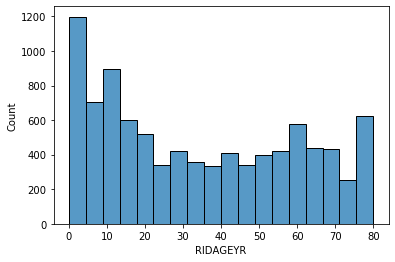

In [14]:
sns.histplot(age['RIDAGEYR'])

# all respondents 80 and older are top-coded at 80

In [15]:
# target can be found in this df
# target is HUD071 - were you a pt in a hospital over past 12 months?

huq_j.head(200)

SEQN  HUQ010  HUQ020  HUQ030   HUQ041  HUQ051  HUQ061  HUQ071  \
0   93703.00000 1.00000 3.00000 1.00000  2.00000 3.00000     nan 2.00000   
1   93704.00000 1.00000 3.00000 1.00000  2.00000 2.00000     nan 2.00000   
2   93705.00000 3.00000 3.00000 1.00000  1.00000 2.00000     nan 2.00000   
3   93706.00000 1.00000 3.00000 1.00000  2.00000 2.00000     nan 2.00000   
4   93707.00000 3.00000 3.00000 1.00000  2.00000 1.00000     nan 2.00000   
5   93708.00000 3.00000 3.00000 1.00000  2.00000 3.00000     nan 2.00000   
6   93709.00000 4.00000 3.00000 1.00000  2.00000 3.00000     nan 2.00000   
7   93710.00000 2.00000     nan 1.00000  2.00000 4.00000     nan 2.00000   
8   93711.00000 1.00000 3.00000 1.00000  2.00000 3.00000     nan 2.00000   
9   93712.00000 3.00000 1.00000 1.00000  1.00000 1.00000     nan 2.00000   
10  93713.00000 3.00000 3.00000 1.00000  2.00000 0.00000 3.00000 2.00000   
11  93714.00000 3.00000 3.00000 1.00000  2.00000 1.00000     nan 2.00000   
12  93715.00000 4.00000 2.00000 1.00000  2.00000 7.00000     nan 2.00000   
13  93716.00000 1.00000 3.00000 1.00000  2.00000 4.00000     nan 2.00000   
14  93717.00000 2.00000 1.00000 2.00000      nan 1.00000     nan 2.00000   
15  93718.00000 3.00000 1.00000 1.00000  2.00000 3.00000     nan 2.00000   
16  93719.00000 2.00000 3.00000 1.00000  2.00000 2.00000     nan 2.00000   
17  93720.00000 1.00000 3.00000 1.00000  2.00000 3.00000     nan 2.00000   
18  93721.00000 4.00000 1.00000 1.00000  1.00000 2.00000     nan 2.00000   
19  93722.00000 1.00000 2.00000 1.00000  2.00000 8.00000     nan 2.00000   
20  93723.00000 1.00000 3.00000 1.00000  1.00000 3.00000     nan 2.00000   
21  93724.00000 2.00000 3.00000 1.00000  2.00000 1.00000     nan 2.00000   
22  93725.00000 1.00000 3.00000 1.00000  2.00000 2.00000     nan 2.00000   
23  93726.00000 3.00000 1.00000 1.00000  1.00000 2.00000     nan 2.00000   
24  93727.00000 1.00000 3.00000 1.00000  2.00000 2.00000     nan 2.00000   
25  93728.00000 2.00000 3.00000 1.00000  2.00000 2.00000     nan 2.00000   
26  93729.00000 3.00000 3.00000 2.00000      nan 0.00000 4.00000 2.00000   
27  93730.00000 4.00000 3.00000 1.00000  2.00000 0.00000 2.00000 2.00000   
28  93731.00000 2.00000 3.00000 1.00000  2.00000 3.00000     nan 2.00000   
29  93732.00000 3.00000 1.00000 1.00000  2.00000 5.00000     nan 1.00000   
30  93733.00000 1.00000 3.00000 1.00000  2.00000 2.00000     nan 2.00000   
31  93734.00000 1.00000 3.00000 1.00000  2.00000 1.00000     nan 2.00000   
32  93735.00000 3.00000 2.00000 1.00000  1.00000 8.00000     nan 1.00000   
33  93736.00000 2.00000 3.00000 2.00000      nan 0.00000 3.00000 2.00000   
34  93737.00000 3.00000 3.00000 1.00000  2.00000 0.00000 2.00000 1.00000   
35  93738.00000 3.00000 1.00000 2.00000      nan 0.00000 3.00000 2.00000   
36  93739.00000 1.00000 3.00000 1.00000  1.00000 3.00000     nan 2.00000   
37  93740.00000 5.00000 2.00000 1.00000  4.00000 8.00000     nan 2.00000   
38  93741.00000 2.00000 3.00000 1.00000  2.00000 2.00000     nan 2.00000   
39  93742.00000 4.00000 2.00000 1.00000  2.00000 4.00000     nan 2.00000   
40  93743.00000 3.00000 1.00000 3.00000  3.00000 0.00000 3.00000 2.00000   
41  93744.00000 1.00000 3.00000 1.00000  1.00000 2.00000     nan 2.00000   
42  93745.00000 1.00000 3.00000 1.00000  1.00000 3.00000     nan 2.00000   
43  93746.00000 2.00000 2.00000 1.00000  2.00000 1.00000     nan 2.00000   
44  93747.00000 1.00000 3.00000 1.00000  2.00000 2.00000     nan 2.00000   
45  93748.00000 1.00000     nan 1.00000  1.00000 4.00000     nan 2.00000   
46  93749.00000 2.00000 3.00000 2.00000      nan 2.00000     nan 2.00000   
47  93750.00000 2.00000 1.00000 1.00000  2.00000 3.00000     nan 2.00000   
48  93751.00000 5.00000 2.00000 1.00000  2.00000 2.00000     nan 2.00000   
49  93752.00000 2.00000 3.00000 2.00000      nan 1.00000     nan 2.00000   
50  93753.00000 2.00000 3.00000 1.00000  2.00000 1.00000     nan 2.00000   
51  93754.00000 2.00000 3.00000 1.00000  1.00000 8.00000   

HUQ071	Overnight hospital patient in last year	{During the past 12 months, were you/{was} SP} a patient in a hospital overnight? Do not include an overnight stay in the emergency room.	

In [16]:
target = huq_j[['SEQN', 'HUQ071']]
target

SEQN  HUQ071
0     93703.00000 2.00000
1     93704.00000 2.00000
2     93705.00000 2.00000
3     93706.00000 2.00000
4     93707.00000 2.00000
...           ...     ...
9249 102952.00000 2.00000
9250 102953.00000 2.00000
9251 102954.00000 2.00000
9252 102955.00000 2.00000
9253 102956.00000 2.00000

[9254 rows x 2 columns]

In [17]:
# make binary target into 0 and 1, not 2 and 1

target.loc[target['HUQ071'] == 2, 'HUQ071'] = 0

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
target['HUQ071'].value_counts()

# three responses of don't know
# these rows should be removed

0.00000    8434
1.00000     817
9.00000       3
Name: HUQ071, dtype: int64

In [19]:
# remove 3 patients with '9' response ("don't know")

target = target.loc[target['HUQ071'] != 9.00000]

In [20]:
target['HUQ071'].value_counts(normalize=True)

# only 9 per cent of people were hospitalized

0.00000   0.91169
1.00000   0.08831
Name: HUQ071, dtype: float64

In [21]:
# https://www.hcup-us.ahrq.gov/faststats/NationalDiagnosesServlet

# start with medical conditions most likely to lead to an inpatient admission:
# circulatory system (in particular heart failure)
# respiratory system (in particular COPD)
# diabetes
# osteoarthritis
# also sickle cell anemia, but it's not here
# hip fractures, alcohol-related disorders, depressive disorders 




mcq_j

SEQN  MCQ010   MCQ025  MCQ035  MCQ040  MCQ050  AGQ030  MCQ053  \
0     93703.00000 2.00000      nan     nan     nan     nan     nan 2.00000   
1     93704.00000 2.00000      nan     nan     nan     nan     nan 2.00000   
2     93705.00000 1.00000 10.00000 2.00000     nan     nan     nan 2.00000   
3     93706.00000 2.00000      nan     nan     nan     nan     nan 2.00000   
4     93707.00000 2.00000      nan     nan     nan     nan     nan 2.00000   
...           ...     ...      ...     ...     ...     ...     ...     ...   
8892 102952.00000 2.00000      nan     nan     nan     nan     nan 2.00000   
8893 102953.00000 1.00000 42.00000 1.00000 1.00000 2.00000 1.00000 2.00000   
8894 102954.00000 2.00000      nan     nan     nan     nan     nan 2.00000   
8895 102955.00000 2.00000      nan     nan     nan     nan     nan 2.00000   
8896 102956.00000 2.00000      nan     nan     nan     nan     nan 2.00000   

      MCQ080  MCQ092  MCD093  MCQ149  MCQ151  RHD018  MCQ160A  MCD180A  \
0        nan     nan     nan     nan     nan     nan      nan      nan   
1        nan     nan     nan     nan     nan     nan      nan      nan   
2    2.00000 2.00000     nan     nan     nan     nan  1.00000 64.00000   
3    2.00000 2.00000     nan     nan     nan     nan      nan      nan   
4        nan 2.00000     nan     nan     nan     nan      nan      nan   
...      ...     ...     ...     ...     ...     ...      ...      ...   
8892 2.00000 2.00000     nan     nan     nan     nan  2.00000      nan   
8893 1.00000 2.00000     nan     nan     nan     nan  2.00000      nan   
8894 1.00000 2.00000     nan     nan     nan     nan  2.00000      nan   
8895     nan 2.00000     nan     nan     nan     nan      nan      nan   
8896 1.00000 2.00000     nan     nan     nan     nan  1.00000 27.00000   

      MCQ195  MCQ160N  MCD180N  MCQ160B  MCD180B  MCQ160C  MCD180C  MCQ160D  \
0        nan      nan      nan      nan      nan      nan      nan      nan   
1        nan      nan      nan      nan      nan      nan      nan      nan   
2    2.00000  2.00000      nan  2.00000      nan  2.00000      nan  2.00000   
3        nan      nan      nan      nan      nan      nan      nan      nan   
4        nan      nan      nan      nan      nan      nan      nan      nan   
...      ...      ...      ...      ...      ...      ...      ...      ...   
8892     nan  2.00000      nan  2.00000      nan  2.00000      nan  2.00000   
8893     nan  2.00000      nan  2.00000      nan  2.00000      nan  2.00000   
8894     nan  2.00000      nan  2.00000      nan  2.00000      nan  2.00000   
8895     nan      nan      nan      nan      nan      nan      nan      nan   
8896 1.00000  2.00000      nan  2.00000      nan  2.00000      nan  2.00000   

      MCD180D  MCQ160E  MCD180E  MCQ160F  MCD180F  MCQ160M  MCQ170M  MCD180M  \
0         nan      nan      nan      nan      nan      nan      nan      nan   
1         nan      nan      nan      nan      nan      nan      nan      nan   
2         nan  2.00000      nan  2.00000      nan  2.00000      nan      nan   
3         nan      nan      nan      nan      nan      nan      nan      nan   
4         nan      nan      nan      nan      nan      nan      nan      nan   
...       ...      ...      ...      ...      ...      ...      ...      ...   
8892      nan  2.00000      nan  2.00000      nan  2.00000      nan      nan   
8893      nan  2.00000      nan  2.00000      nan  2.00000      nan      nan   
8894      nan  2.00000      nan  2.00000      nan  2.00000      nan      nan   
8895      nan      nan      nan      nan      nan      nan      nan      nan   
8896      nan  2.00000      nan  2.00000      nan  2.00000      nan      nan   

      MCQ160G  MCD180G  MCQ160K  MCQ170K  MCD180K  MCQ160O  MCQ160L  MCQ170L  \
0         nan      nan      nan      nan      nan      nan      nan      nan   
1         nan      nan      nan      nan      nan      nan      nan      nan   
2     2.00000      nan  2.00000      

In [22]:
med_cond = mcq_j[['SEQN',
                  'MCD180A', # age when told you had arthritis
                  'MCQ195', # which type of arthritis was it
                  'MCD180B', # age when told you had heart failure
                 'MCD180C', # age when told you had CAD
                 'MCD180D', # age when told you had angina pectoris
                 'MCD180E', # age when told you had a heart attack
                 'MCD180F', # age when told you had a stroke
                 'MCD180G', # age when told you had emphysema
                 'MCD180K', # age when told you had chronic bronchitis
                 'MCQ160O', # ever told you had COPD?
                 'MCD180L', # age when told you had a liver condition
                 'MCQ170L', # do you still have a liver condition
                 'MCQ510A', # Liver condition: Fatty liver
                 'MCQ510B', # Liver condition: Liver fibrosis
                  'MCQ510C', # Liver condition: Liver cirrhosis
                 'MCQ510D', # Liver condition: Viral hepatitis
                 'MCQ510E', # Liver condition: Autoimmune hepatitis 
                 'MCQ510F', # Liver condition: Other liver disease
                 'MCD180M', # Age when told you had thyroid problem
                 'MCQ170M', # Do you still have thyroid problem
                 'MCD180N', # MCD180n - Age when told you had gout
                 'MCD240A', # Age 1st cancer (MCQ230a) diagnosed
                 'MCD240B', # Age 2nd cancer (MCQ230b) diagnosed
                 'MCD240C', # Age 3rd cancer (MCQ230c) diagnosed
                 'MCQ230A', # 1st cancer - what kind was it?
                  'MCQ230B', # 2nd cancer - what kind was it?
                  'MCQ230C', # 3rd cancer - what kind was it?
                 'MCQ025', # age when first had asthma
                 'MCQ035', # still have asthma
                 'MCQ206', # Age when told you have jaundice?
                 'MCQ300A', # Close relative had heart attack?
                 'MCQ300B', # Close relative had asthma?
                 'MCQ300C', # Close relative had diabetes?
                 'MCQ570' # Age when 1st had gallbladder surgery?
                 ]]

In [23]:
# create clean df for arthritis

arthritis = med_cond[['SEQN', 'MCQ195']]
arthritis

SEQN  MCQ195
0     93703.00000     nan
1     93704.00000     nan
2     93705.00000 2.00000
3     93706.00000     nan
4     93707.00000     nan
...           ...     ...
8892 102952.00000     nan
8893 102953.00000     nan
8894 102954.00000     nan
8895 102955.00000     nan
8896 102956.00000 1.00000

[8897 rows x 2 columns]

In [24]:
arthritis['MCQ195'].value_counts()

# Code or Value	Value Description	Count	Cumulative	Skip to Item
# 1	Osteoarthritis or degenerative arthritis	711	711	
# 2	Rheumatoid arthritis	337	1048	
# 3	Psoriatic arthritis	26	1074	
# 4	Other	175	1249	
# 7	Refused	3	1252	
# 9	Don't know	443	1695	
# .	Missing	7202	8897	

1.00000    711
9.00000    443
2.00000    337
4.00000    175
3.00000     26
7.00000      3
Name: MCQ195, dtype: int64

In [25]:
arthritis_2 = pd.get_dummies(data=arthritis, columns=['MCQ195'])
arthritis_2

SEQN  MCQ195_1.0  MCQ195_2.0  MCQ195_3.0  MCQ195_4.0  MCQ195_7.0  \
0     93703.00000           0           0           0           0           0   
1     93704.00000           0           0           0           0           0   
2     93705.00000           0           1           0           0           0   
3     93706.00000           0           0           0           0           0   
4     93707.00000           0           0           0           0           0   
...           ...         ...         ...         ...         ...         ...   
8892 102952.00000           0           0           0           0           0   
8893 102953.00000           0           0           0           0           0   
8894 102954.00000           0           0           0           0           0   
8895 102955.00000           0           0           0           0           0   
8896 102956.00000           1           0           0           0           0   

      MCQ195_9.0  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
8892           0  
8893           0  
8894           0  
8895           0  
8896           0  

[8897 rows x 7 columns]

In [26]:
# osteoarthritis is most likely to cause hospitalization - #1

arthritis_3 = arthritis_2.rename(columns = {'MCQ195_1.0': 'osteoarthritis'})

other_arth = ['MCQ195_2.0', 'MCQ195_3.0', 'MCQ195_4.0', 'MCQ195_7.0', 'MCQ195_9.0']

arthritis_3['other_arthritis'] = arthritis_3[other_arth].sum(axis = 1)

In [27]:
arthritis_4 = arthritis_3.drop(columns = other_arth)

arthritis_4

SEQN  osteoarthritis  other_arthritis
0     93703.00000               0                0
1     93704.00000               0                0
2     93705.00000               0                1
3     93706.00000               0                0
4     93707.00000               0                0
...           ...             ...              ...
8892 102952.00000               0                0
8893 102953.00000               0                0
8894 102954.00000               0                0
8895 102955.00000               0                0
8896 102956.00000               1                0

[8897 rows x 3 columns]

In [28]:
# check value counts

print(arthritis_3['osteoarthritis'].value_counts())
print(arthritis_3['MCQ195_2.0'].value_counts())
print(arthritis_3['MCQ195_3.0'].value_counts())
print(arthritis_3['MCQ195_4.0'].value_counts())
print(arthritis_3['MCQ195_7.0'].value_counts())
print(arthritis_3['MCQ195_9.0'].value_counts())

0    8186
1     711
Name: osteoarthritis, dtype: int64
0    8560
1     337
Name: MCQ195_2.0, dtype: int64
0    8871
1      26
Name: MCQ195_3.0, dtype: int64
0    8722
1     175
Name: MCQ195_4.0, dtype: int64
0    8894
1       3
Name: MCQ195_7.0, dtype: int64
0    8454
1     443
Name: MCQ195_9.0, dtype: int64


In [29]:
# matches numbers above

print(arthritis_4['osteoarthritis'].value_counts())
print(arthritis_4['other_arthritis'].value_counts())

0    8186
1     711
Name: osteoarthritis, dtype: int64
0    7913
1     984
Name: other_arthritis, dtype: int64


In [30]:
# get age diagnosed with arthritis

arthritis_5 = arthritis_4.merge(med_cond[['SEQN','MCD180A']], how='left', on='SEQN')

In [31]:
arthritis_5

SEQN  osteoarthritis  other_arthritis  MCD180A
0     93703.00000               0                0      nan
1     93704.00000               0                0      nan
2     93705.00000               0                1 64.00000
3     93706.00000               0                0      nan
4     93707.00000               0                0      nan
...           ...             ...              ...      ...
8892 102952.00000               0                0      nan
8893 102953.00000               0                0      nan
8894 102954.00000               0                0      nan
8895 102955.00000               0                0      nan
8896 102956.00000               1                0 27.00000

[8897 rows x 4 columns]

In [32]:
# check that every person with arthritis has a valid age

arthritis_5.loc[(arthritis_5['osteoarthritis'] == 1) | 
                (arthritis_5['other_arthritis'] == 1)]['MCD180A'].value_counts()

# need to do something about 99999 - impute the median


50.00000       148
60.00000       114
40.00000        90
55.00000        83
45.00000        65
65.00000        61
70.00000        54
35.00000        47
30.00000        46
80.00000        43
16.00000        38
52.00000        34
99999.00000     32
58.00000        31
49.00000        31
62.00000        30
56.00000        27
63.00000        26
67.00000        25
47.00000        25
38.00000        24
75.00000        24
53.00000        24
54.00000        23
25.00000        23
57.00000        23
59.00000        23
42.00000        21
48.00000        21
64.00000        20
44.00000        20
68.00000        20
43.00000        19
66.00000        18
28.00000        18
69.00000        18
72.00000        17
37.00000        16
61.00000        14
41.00000        14
74.00000        14
46.00000        14
32.00000        13
27.00000        13
22.00000        12
51.00000        12
20.00000        12
23.00000        12
73.00000        11
36.00000        11
39.00000        11
33.00000        10
21.00000    

In [33]:
def replace_with_median(col, value_to_replace):
    
    real_values = col.loc[(~col.isna()) & (col != value_to_replace)]

    true_median = real_values.median()

    return col.replace(value_to_replace, true_median)

In [34]:
# think about replacing this later after calculation of years with arth

arthritis_5['MCD180A'] = replace_with_median(arthritis_5['MCD180A'], 99999.00000)


In [35]:
arthritis_5['MCD180A'].value_counts()

50.00000    180
60.00000    114
40.00000     90
55.00000     83
45.00000     65
65.00000     61
70.00000     54
35.00000     47
30.00000     46
80.00000     43
16.00000     38
52.00000     34
58.00000     31
49.00000     31
62.00000     30
56.00000     27
63.00000     26
67.00000     25
47.00000     25
38.00000     24
53.00000     24
75.00000     24
57.00000     23
25.00000     23
54.00000     23
59.00000     23
48.00000     21
42.00000     21
64.00000     20
44.00000     20
68.00000     20
43.00000     19
69.00000     18
66.00000     18
28.00000     18
72.00000     17
37.00000     16
74.00000     14
46.00000     14
61.00000     14
41.00000     14
27.00000     13
32.00000     13
20.00000     12
51.00000     12
23.00000     12
22.00000     12
39.00000     11
73.00000     11
36.00000     11
33.00000     10
76.00000      9
34.00000      9
21.00000      9
26.00000      9
24.00000      8
71.00000      8
78.00000      8
18.00000      8
77.00000      7
31.00000      7
29.00000      6
19.00000

In [36]:
# get patient age

arthritis_6 = arthritis_5.merge(age, how='left', on='SEQN')
arthritis_6

SEQN  osteoarthritis  other_arthritis  MCD180A  RIDAGEYR
0     93703.00000               0                0      nan   2.00000
1     93704.00000               0                0      nan   2.00000
2     93705.00000               0                1 64.00000  66.00000
3     93706.00000               0                0      nan  18.00000
4     93707.00000               0                0      nan  13.00000
...           ...             ...              ...      ...       ...
8892 102952.00000               0                0      nan  70.00000
8893 102953.00000               0                0      nan  42.00000
8894 102954.00000               0                0      nan  41.00000
8895 102955.00000               0                0      nan  14.00000
8896 102956.00000               1                0 27.00000  38.00000

[8897 rows x 5 columns]

In [37]:
# create column with number of years with arthritis

arthritis_6['yrs_with_arth'] = arthritis_6['RIDAGEYR'] - arthritis_6['MCD180A']
arthritis_6

SEQN  osteoarthritis  other_arthritis  MCD180A  RIDAGEYR  \
0     93703.00000               0                0      nan   2.00000   
1     93704.00000               0                0      nan   2.00000   
2     93705.00000               0                1 64.00000  66.00000   
3     93706.00000               0                0      nan  18.00000   
4     93707.00000               0                0      nan  13.00000   
...           ...             ...              ...      ...       ...   
8892 102952.00000               0                0      nan  70.00000   
8893 102953.00000               0                0      nan  42.00000   
8894 102954.00000               0                0      nan  41.00000   
8895 102955.00000               0                0      nan  14.00000   
8896 102956.00000               1                0 27.00000  38.00000   

      yrs_with_arth  
0               nan  
1               nan  
2           2.00000  
3               nan  
4               nan  
...             ...  
8892            nan  
8893            nan  
8894            nan  
8895            nan  
8896       11.00000  

[8897 rows x 6 columns]

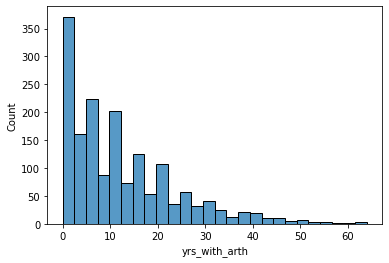

In [38]:
sns.histplot(arthritis_6['yrs_with_arth'])

In [39]:
arthritis_6.loc[arthritis_6['osteoarthritis'] == 1, 'osteoarthritis'] = arthritis_6['yrs_with_arth']
arthritis_6.loc[arthritis_6['other_arthritis'] == 1, 'other_arthritis'] = arthritis_6['yrs_with_arth']

In [40]:
arthritis_6.head(200)

SEQN  osteoarthritis  other_arthritis  MCD180A  RIDAGEYR  \
0   93703.00000         0.00000          0.00000      nan   2.00000   
1   93704.00000         0.00000          0.00000      nan   2.00000   
2   93705.00000         0.00000          2.00000 64.00000  66.00000   
3   93706.00000         0.00000          0.00000      nan  18.00000   
4   93707.00000         0.00000          0.00000      nan  13.00000   
5   93708.00000         0.00000          0.00000 66.00000  66.00000   
6   93709.00000         0.00000         28.00000 47.00000  75.00000   
7   93711.00000         0.00000          0.00000      nan  56.00000   
8   93712.00000         0.00000          0.00000      nan  18.00000   
9   93713.00000         0.00000          5.00000 62.00000  67.00000   
10  93714.00000         0.00000          0.00000      nan  54.00000   
11  93715.00000        46.00000          0.00000 25.00000  71.00000   
12  93716.00000         0.00000          3.00000 58.00000  61.00000   
13  93717.00000         0.00000          0.00000      nan  22.00000   
14  93718.00000         0.00000          0.00000      nan  45.00000   
15  93719.00000         0.00000          0.00000      nan  13.00000   
16  93720.00000         0.00000          0.00000      nan   1.00000   
17  93721.00000         0.00000          0.00000      nan  60.00000   
18  93722.00000         0.00000          0.00000      nan  60.00000   
19  93723.00000         1.00000          0.00000 63.00000  64.00000   
20  93724.00000         0.00000          0.00000      nan   5.00000   
21  93725.00000         0.00000          0.00000      nan   9.00000   
22  93726.00000         0.00000          0.00000      nan  67.00000   
23  93727.00000         0.00000          0.00000      nan  70.00000   
24  93728.00000         0.00000          0.00000      nan  53.00000   
25  93729.00000         0.00000          0.00000      nan  42.00000   
26  93730.00000         0.00000          0.00000      nan  57.00000   
27  93731.00000         0.00000          0.00000      nan  20.00000   
28  93732.00000         0.00000          0.00000      nan  72.00000   
29  93733.00000         0.00000          0.00000      nan  11.00000   
30  93734.00000         0.00000          0.00000      nan  13.00000   
31  93735.00000         0.00000          0.00000      nan  52.00000   
32  93736.00000         0.00000          0.00000      nan  11.00000   
33  93737.00000         0.00000          0.00000      nan   8.00000   
34  93738.00000         0.00000          0.00000      nan  26.00000   
35  93739.00000         0.00000          0.00000      nan   5.00000   
36  93740.00000         0.00000          2.00000 70.00000  72.00000   
37  93741.00000         0.00000          0.00000      nan   9.00000   
38  93742.00000        22.00000          0.00000 50.00000  72.00000   
39  93743.00000         0.00000         14.00000 47.00000  61.00000   
40  93744.00000         0.00000          0.00000      nan  10.00000   
41  93745.00000         0.00000          0.00000      nan   5.00000   
42  93746.00000         0.00000          0.00000      nan  25.00000   
43  93747.00000         0.00000          0.00000      nan  13.00000   
44  93749.00000         0.00000          0.00000      nan   1.00000   
45  93750.00000         0.00000          0.00000      nan  52.00000   
46  93751.00000         0.00000          0.00000      nan   7.00000   
47  93752.00000         0.00000          0.00000      nan  73.00000   
48  93753.00000         0.00000          0.00000      nan  10.00000   
49  93754.00000         0.00000          0.00000      nan  72.00000   
50  93755.00000         0.00000          0.00000      nan  26.00000   
51  93756.00000         0.00000          0.00000      nan  64.00000   
52  93757.00000         0.00000          2.00000 61.00000  63.00000   
53  93758.00000        21.00000          0.00000 34.00000  55.00000   
54  93759.00000         0.00000          0.00000      nan  60.00000   
55  93760.00000         0.00000    

In [41]:
arth_yrs = arthritis_6[['SEQN', 'osteoarthritis', 'other_arthritis']]
arth_yrs.rename(columns = {'osteoarthritis': 'osteo_yrs', 'other_arthritis': 'other_arth_yrs'}, inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [42]:
arth_yrs.head(200)

SEQN  osteo_yrs  other_arth_yrs
0   93703.00000    0.00000         0.00000
1   93704.00000    0.00000         0.00000
2   93705.00000    0.00000         2.00000
3   93706.00000    0.00000         0.00000
4   93707.00000    0.00000         0.00000
5   93708.00000    0.00000         0.00000
6   93709.00000    0.00000        28.00000
7   93711.00000    0.00000         0.00000
8   93712.00000    0.00000         0.00000
9   93713.00000    0.00000         5.00000
10  93714.00000    0.00000         0.00000
11  93715.00000   46.00000         0.00000
12  93716.00000    0.00000         3.00000
13  93717.00000    0.00000         0.00000
14  93718.00000    0.00000         0.00000
15  93719.00000    0.00000         0.00000
16  93720.00000    0.00000         0.00000
17  93721.00000    0.00000         0.00000
18  93722.00000    0.00000         0.00000
19  93723.00000    1.00000         0.00000
20  93724.00000    0.00000         0.00000
21  93725.00000    0.00000         0.00000
22  93726.00000    0.00000         0.00000
23  93727.00000    0.00000         0.00000
24  93728.00000    0.00000         0.00000
25  93729.00000    0.00000         0.00000
26  93730.00000    0.00000         0.00000
27  93731.00000    0.00000         0.00000
28  93732.00000    0.00000         0.00000
29  93733.00000    0.00000         0.00000
30  93734.00000    0.00000         0.00000
31  93735.00000    0.00000         0.00000
32  93736.00000    0.00000         0.00000
33  93737.00000    0.00000         0.00000
34  93738.00000    0.00000         0.00000
35  93739.00000    0.00000         0.00000
36  93740.00000    0.00000         2.00000
37  93741.00000    0.00000         0.00000
38  93742.00000   22.00000         0.00000
39  93743.00000    0.00000        14.00000
40  93744.00000    0.00000         0.00000
41  93745.00000    0.00000         0.00000
42  93746.00000    0.00000         0.00000
43  93747.00000    0.00000         0.00000
44  93749.00000    0.00000         0.00000
45  93750.00000    0.00000         0.00000
46  93751.00000    0.00000         0.00000
47  93752.00000    0.00000         0.00000
48  93753.00000    0.00000         0.00000
49  93754.00000    0.00000         0.00000
50  93755.00000    0.00000         0.00000
51  93756.00000    0.00000         0.00000
52  93757.00000    0.00000         2.00000
53  93758.00000   21.00000         0.00000
54  93759.00000    0.00000         0.00000
55  93760.00000    0.00000         0.00000
56  93761.00000    0.00000         0.00000
57  93762.00000    0.00000        12.00000
58  93763.00000    5.00000         0.00000
59  93764.00000    0.00000         0.00000
60  93765.00000    0.00000         0.00000
61  93766.00000    0.00000         0.00000
62  93767.00000   11.00000         0.00000
63  93768.00000    0.00000         0.00000
64  93769.00000    0.00000         0.00000
65  93770.00000    0.00000        15.00000
66  93771.00000    0.00000         0.00000
67  93772.00000   37.00000         0.00000
68  93773.00000    0.00000         0.00000
69  93774.00000    0.00000         0.00000
70  93775.00000    0.00000         0.00000
71  93776.00000    0.00000         0.00000
72  93777.00000    0.00000         0.00000
73  93778.00000    0.00000         0.00000
74  93779.00000    0.00000         0.00000
75  93780.00000    5.00000         0.00000
76  93781.00000    0.00000         0.00000
77  93782.00000    0.00000         0.00000
78  93783.00000    0.00000         0.00000
79  93784.00000    0.00000         0.00000
80  93785.00000   40.00000         0.00000
81  93787.00000    0.00000         0.00000
82  93788.00000    0.00000         0.00000
83  93789.00000    0.00000         0.00000
84  93790.00000    0.00000         0.00000
85  93791.00000    0.00000         0.00000
86  93792.00000    0.00000         0.00000
87  93793.00000    0.00000         0.00000
88  93794.00000    0.00000         7.00000
89  93795.00000    0.00000         0.00000
90  93796.00000    0.00000        10.00000
91  93797.00000   17.00000         0.00000
92  93798.00

In [43]:
arthritis_7 = arth_yrs.copy()

In [44]:
arth_col = ['osteo_yrs', 'other_arth_yrs']

arthritis_7[arth_col] = arthritis_7[arth_col].applymap(lambda x: 1 if x > 0 else 0)
    
arthritis_7.head(200)

SEQN  osteo_yrs  other_arth_yrs
0   93703.00000          0               0
1   93704.00000          0               0
2   93705.00000          0               1
3   93706.00000          0               0
4   93707.00000          0               0
5   93708.00000          0               0
6   93709.00000          0               1
7   93711.00000          0               0
8   93712.00000          0               0
9   93713.00000          0               1
10  93714.00000          0               0
11  93715.00000          1               0
12  93716.00000          0               1
13  93717.00000          0               0
14  93718.00000          0               0
15  93719.00000          0               0
16  93720.00000          0               0
17  93721.00000          0               0
18  93722.00000          0               0
19  93723.00000          1               0
20  93724.00000          0               0
21  93725.00000          0               0
22  93726.00000          0               0
23  93727.00000          0               0
24  93728.00000          0               0
25  93729.00000          0               0
26  93730.00000          0               0
27  93731.00000          0               0
28  93732.00000          0               0
29  93733.00000          0               0
30  93734.00000          0               0
31  93735.00000          0               0
32  93736.00000          0               0
33  93737.00000          0               0
34  93738.00000          0               0
35  93739.00000          0               0
36  93740.00000          0               1
37  93741.00000          0               0
38  93742.00000          1               0
39  93743.00000          0               1
40  93744.00000          0               0
41  93745.00000          0               0
42  93746.00000          0               0
43  93747.00000          0               0
44  93749.00000          0               0
45  93750.00000          0               0
46  93751.00000          0               0
47  93752.00000          0               0
48  93753.00000          0               0
49  93754.00000          0               0
50  93755.00000          0               0
51  93756.00000          0               0
52  93757.00000          0               1
53  93758.00000          1               0
54  93759.00000          0               0
55  93760.00000          0               0
56  93761.00000          0               0
57  93762.00000          0               1
58  93763.00000          1               0
59  93764.00000          0               0
60  93765.00000          0               0
61  93766.00000          0               0
62  93767.00000          1               0
63  93768.00000          0               0
64  93769.00000          0               0
65  93770.00000          0               1
66  93771.00000          0               0
67  93772.00000          1               0
68  93773.00000          0               0
69  93774.00000          0               0
70  93775.00000          0               0
71  93776.00000          0               0
72  93777.00000          0               0
73  93778.00000          0               0
74  93779.00000          0               0
75  93780.00000          1               0
76  93781.00000          0               0
77  93782.00000          0               0
78  93783.00000          0               0
79  93784.00000          0               0
80  93785.00000          1               0
81  93787.00000          0               0
82  93788.00000          0               0
83  93789.00000          0               0
84  93790.00000          0               0
85  93791.00000          0               0
86  93792.00000          0               0
87  93793.00000          0               0
88  93794.00000          0               1
89  93795.00000          0               0
90  93796.00000          0               1
91  93797.00000          1               0
92  93798.00

In [45]:
arth_binary = arthritis_7.copy()

In [46]:
# check arthritis_5 against arthritis_7
# it's good that arthritis_7 has fewer patients marked osteoporosis
# because it excludes patients who have had it for less than 1 year

print(arthritis_5['osteoarthritis'].value_counts())
print(arthritis_7['osteo_yrs'].value_counts())

0    8186
1     711
Name: osteoarthritis, dtype: int64
0    8225
1     672
Name: osteo_yrs, dtype: int64


In [47]:
# clean up circulatory conditions

circ = med_cond[['SEQN',
                 'MCD180B', # age when told you had heart failure
                 'MCD180C', # age when told you had CAD
                 'MCD180D', # age when told you had angina pectoris
                 'MCD180E', # age when told you had a heart attack
                 'MCD180F' # age when told you had a stroke
                   ]]

In [48]:
circ['MCD180F'].value_counts()

# need to remove 99999.00000

55.00000       17
80.00000       16
50.00000       13
62.00000       13
65.00000       11
70.00000       10
53.00000       10
43.00000        8
58.00000        8
75.00000        7
48.00000        7
76.00000        6
54.00000        6
64.00000        6
56.00000        6
69.00000        6
60.00000        6
52.00000        5
59.00000        5
77.00000        5
47.00000        5
42.00000        5
79.00000        5
99999.00000     5
71.00000        4
45.00000        4
68.00000        4
49.00000        4
67.00000        4
40.00000        4
36.00000        4
57.00000        3
39.00000        3
63.00000        3
66.00000        3
51.00000        3
34.00000        3
46.00000        2
28.00000        2
78.00000        2
73.00000        2
61.00000        2
21.00000        2
25.00000        2
38.00000        2
44.00000        2
22.00000        2
30.00000        2
74.00000        2
35.00000        2
32.00000        1
16.00000        1
33.00000        1
18.00000        1
23.00000        1
17.00000  

In [49]:
# replace 99999.00000 with median in all age columns

for col_name in ['MCD180B', 'MCD180C', 'MCD180D', 'MCD180E', 'MCD180F']:
    circ[col_name] = replace_with_median(circ[col_name], 99999.00000)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [50]:
# recheck age columns

circ['MCD180D'].value_counts()

60.00000    12
53.00000    10
45.00000     7
55.00000     7
62.00000     6
58.00000     6
35.00000     5
50.00000     5
80.00000     5
57.00000     5
40.00000     4
47.00000     4
65.00000     4
48.00000     4
16.00000     4
23.00000     3
30.00000     3
59.00000     3
44.00000     3
72.00000     3
42.00000     3
46.00000     3
64.00000     3
69.00000     3
61.00000     3
51.00000     3
70.00000     3
36.00000     2
56.00000     2
20.00000     2
63.00000     2
25.00000     2
67.00000     2
38.00000     2
34.00000     2
33.00000     2
74.00000     2
54.00000     2
68.00000     1
26.00000     1
29.00000     1
78.00000     1
31.00000     1
52.00000     1
77.00000     1
49.00000     1
41.00000     1
37.00000     1
39.00000     1
66.00000     1
43.00000     1
27.00000     1
71.00000     1
Name: MCD180D, dtype: int64

In [51]:
# get patient age

circ_2 = circ.merge(age, how='left', on='SEQN')

circ_2.head(200)

SEQN  MCD180B  MCD180C  MCD180D  MCD180E  MCD180F  RIDAGEYR
0   93703.00000      nan      nan      nan      nan      nan   2.00000
1   93704.00000      nan      nan      nan      nan      nan   2.00000
2   93705.00000      nan      nan      nan      nan      nan  66.00000
3   93706.00000      nan      nan      nan      nan      nan  18.00000
4   93707.00000      nan      nan      nan      nan      nan  13.00000
5   93708.00000      nan      nan      nan      nan      nan  66.00000
6   93709.00000      nan      nan      nan      nan 60.00000  75.00000
7   93711.00000      nan      nan      nan      nan      nan  56.00000
8   93712.00000      nan      nan      nan      nan      nan  18.00000
9   93713.00000      nan      nan      nan      nan      nan  67.00000
10  93714.00000      nan      nan      nan      nan      nan  54.00000
11  93715.00000 71.00000      nan      nan      nan      nan  71.00000
12  93716.00000      nan      nan      nan      nan      nan  61.00000
13  93717.00000      nan      nan      nan      nan      nan  22.00000
14  93718.00000      nan      nan      nan      nan      nan  45.00000
15  93719.00000      nan      nan      nan      nan      nan  13.00000
16  93720.00000      nan      nan      nan      nan      nan   1.00000
17  93721.00000      nan      nan      nan      nan      nan  60.00000
18  93722.00000      nan      nan      nan      nan      nan  60.00000
19  93723.00000      nan      nan      nan      nan      nan  64.00000
20  93724.00000      nan      nan      nan      nan      nan   5.00000
21  93725.00000      nan      nan      nan      nan      nan   9.00000
22  93726.00000      nan      nan      nan      nan      nan  67.00000
23  93727.00000      nan      nan      nan      nan      nan  70.00000
24  93728.00000      nan      nan      nan      nan      nan  53.00000
25  93729.00000      nan      nan      nan      nan      nan  42.00000
26  93730.00000      nan      nan      nan      nan      nan  57.00000
27  93731.00000      nan      nan      nan      nan      nan  20.00000
28  93732.00000      nan 72.00000 72.00000 72.00000      nan  72.00000
29  93733.00000      nan      nan      nan      nan      nan  11.00000
30  93734.00000      nan      nan      nan      nan      nan  13.00000
31  93735.00000      nan      nan      nan      nan 49.00000  52.00000
32  93736.00000      nan      nan      nan      nan      nan  11.00000
33  93737.00000      nan      nan      nan      nan      nan   8.00000
34  93738.00000      nan      nan      nan      nan      nan  26.00000
35  93739.00000      nan      nan      nan      nan      nan   5.00000
36  93740.00000 66.00000      nan      nan 65.00000      nan  72.00000
37  93741.00000      nan      nan      nan      nan      nan   9.00000
38  93742.00000      nan 69.00000      nan      nan 69.00000  72.00000
39  93743.00000      nan      nan      nan      nan      nan  61.00000
40  93744.00000      nan      nan      nan      nan      nan  10.00000
41  93745.00000      nan      nan      nan      nan      nan   5.00000
42  93746.00000      nan      nan      nan      nan      nan  25.00000
43  93747.00000      nan      nan      nan      nan      nan  13.00000
44  93749.00000      nan      nan      nan      nan      nan   1.00000
45  93750.00000      nan      nan      nan      nan      nan  52.00000
46  93751.00000      nan      nan      nan      nan      nan   7.00000
47  93752.00000      nan      nan      nan      nan      nan  73.00000
48  93753.00000      nan      nan      nan      nan      nan  10.00000
49  93754.00000      nan      nan      nan      nan      nan  72.00000
50  93755.00000      nan      nan      nan      nan      nan  26.00000
51  93756.00000      nan      nan      nan      nan      nan  64.00000
52  93757.00000      nan      nan      nan      nan      nan  63.00000
53  93758.00000      nan 40.00000 43.00000 48.00000 48.00000  55.00000
54  93759.00000      nan      nan      nan 60.00000      nan  60.00000
55  93760.00000      nan      nan  

In [52]:
# label heart failure - leading cause of hospitalizations

circ_3 = circ_2.rename(columns = {'MCD180B': 'heart_failure'})
circ_3

SEQN  heart_failure  MCD180C  MCD180D  MCD180E  MCD180F  RIDAGEYR
0     93703.00000            nan      nan      nan      nan      nan   2.00000
1     93704.00000            nan      nan      nan      nan      nan   2.00000
2     93705.00000            nan      nan      nan      nan      nan  66.00000
3     93706.00000            nan      nan      nan      nan      nan  18.00000
4     93707.00000            nan      nan      nan      nan      nan  13.00000
...           ...            ...      ...      ...      ...      ...       ...
8892 102952.00000            nan      nan      nan      nan      nan  70.00000
8893 102953.00000            nan      nan      nan      nan      nan  42.00000
8894 102954.00000            nan      nan      nan      nan      nan  41.00000
8895 102955.00000            nan      nan      nan      nan      nan  14.00000
8896 102956.00000            nan      nan      nan      nan      nan  38.00000

[8897 rows x 7 columns]

In [53]:
# combine other circulatory conditions - use minimum age of diagnosis

other_circ_cond = ['MCD180C', 'MCD180D', 'MCD180E', 'MCD180F']

circ_3['age_oth_cond'] = circ_3[other_circ_cond].min(axis=1)
circ_3.head(200)

SEQN  heart_failure  MCD180C  MCD180D  MCD180E  MCD180F  RIDAGEYR  \
0   93703.00000            nan      nan      nan      nan      nan   2.00000   
1   93704.00000            nan      nan      nan      nan      nan   2.00000   
2   93705.00000            nan      nan      nan      nan      nan  66.00000   
3   93706.00000            nan      nan      nan      nan      nan  18.00000   
4   93707.00000            nan      nan      nan      nan      nan  13.00000   
5   93708.00000            nan      nan      nan      nan      nan  66.00000   
6   93709.00000            nan      nan      nan      nan 60.00000  75.00000   
7   93711.00000            nan      nan      nan      nan      nan  56.00000   
8   93712.00000            nan      nan      nan      nan      nan  18.00000   
9   93713.00000            nan      nan      nan      nan      nan  67.00000   
10  93714.00000            nan      nan      nan      nan      nan  54.00000   
11  93715.00000       71.00000      nan      nan      nan      nan  71.00000   
12  93716.00000            nan      nan      nan      nan      nan  61.00000   
13  93717.00000            nan      nan      nan      nan      nan  22.00000   
14  93718.00000            nan      nan      nan      nan      nan  45.00000   
15  93719.00000            nan      nan      nan      nan      nan  13.00000   
16  93720.00000            nan      nan      nan      nan      nan   1.00000   
17  93721.00000            nan      nan      nan      nan      nan  60.00000   
18  93722.00000            nan      nan      nan      nan      nan  60.00000   
19  93723.00000            nan      nan      nan      nan      nan  64.00000   
20  93724.00000            nan      nan      nan      nan      nan   5.00000   
21  93725.00000            nan      nan      nan      nan      nan   9.00000   
22  93726.00000            nan      nan      nan      nan      nan  67.00000   
23  93727.00000            nan      nan      nan      nan      nan  70.00000   
24  93728.00000            nan      nan      nan      nan      nan  53.00000   
25  93729.00000            nan      nan      nan      nan      nan  42.00000   
26  93730.00000            nan      nan      nan      nan      nan  57.00000   
27  93731.00000            nan      nan      nan      nan      nan  20.00000   
28  93732.00000            nan 72.00000 72.00000 72.00000      nan  72.00000   
29  93733.00000            nan      nan      nan      nan      nan  11.00000   
30  93734.00000            nan      nan      nan      nan      nan  13.00000   
31  93735.00000            nan      nan      nan      nan 49.00000  52.00000   
32  93736.00000            nan      nan      nan      nan      nan  11.00000   
33  93737.00000            nan      nan      nan      nan      nan   8.00000   
34  93738.00000            nan      nan      nan      nan      nan  26.00000   
35  93739.00000            nan      nan      nan      nan      nan   5.00000   
36  93740.00000       66.00000      nan      nan 65.00000      nan  72.00000   
37  93741.00000            nan      nan      nan      nan      nan   9.00000   
38  93742.00000            nan 69.00000      nan      nan 69.00000  72.00000   
39  93743.00000            nan      nan      nan      nan      nan  61.00000   
40  93744.00000            nan      nan      nan      nan      nan  10.00000   
41  93745.00000            nan      nan      nan      nan      nan   5.00000   
42  93746.00000            nan      nan      nan      nan      nan  25.00000   
43  93747.00000            nan      nan      nan      nan      nan  13.00000   
44  93749.00000            nan      nan      nan      nan      nan   1.00000   
45  93750.00000            nan      nan      nan      nan      nan  52.00000   
46  93751.00000            nan      nan      nan      nan      nan   7.00000   
47  93752.00000            nan      nan      nan      nan      nan  73.00000   
48  93753.00000            nan      nan      nan      nan      nan  10.00000   
49  93754.0

In [54]:
# find number of years with conditions

circ_3['yrs_heart_fail'] = circ_3['RIDAGEYR'] - circ_3['heart_failure']
circ_3['yrs_other_cond'] = circ_3['RIDAGEYR'] - circ_3['age_oth_cond']
circ_3.head(200)

SEQN  heart_failure  MCD180C  MCD180D  MCD180E  MCD180F  RIDAGEYR  \
0   93703.00000            nan      nan      nan      nan      nan   2.00000   
1   93704.00000            nan      nan      nan      nan      nan   2.00000   
2   93705.00000            nan      nan      nan      nan      nan  66.00000   
3   93706.00000            nan      nan      nan      nan      nan  18.00000   
4   93707.00000            nan      nan      nan      nan      nan  13.00000   
5   93708.00000            nan      nan      nan      nan      nan  66.00000   
6   93709.00000            nan      nan      nan      nan 60.00000  75.00000   
7   93711.00000            nan      nan      nan      nan      nan  56.00000   
8   93712.00000            nan      nan      nan      nan      nan  18.00000   
9   93713.00000            nan      nan      nan      nan      nan  67.00000   
10  93714.00000            nan      nan      nan      nan      nan  54.00000   
11  93715.00000       71.00000      nan      nan      nan      nan  71.00000   
12  93716.00000            nan      nan      nan      nan      nan  61.00000   
13  93717.00000            nan      nan      nan      nan      nan  22.00000   
14  93718.00000            nan      nan      nan      nan      nan  45.00000   
15  93719.00000            nan      nan      nan      nan      nan  13.00000   
16  93720.00000            nan      nan      nan      nan      nan   1.00000   
17  93721.00000            nan      nan      nan      nan      nan  60.00000   
18  93722.00000            nan      nan      nan      nan      nan  60.00000   
19  93723.00000            nan      nan      nan      nan      nan  64.00000   
20  93724.00000            nan      nan      nan      nan      nan   5.00000   
21  93725.00000            nan      nan      nan      nan      nan   9.00000   
22  93726.00000            nan      nan      nan      nan      nan  67.00000   
23  93727.00000            nan      nan      nan      nan      nan  70.00000   
24  93728.00000            nan      nan      nan      nan      nan  53.00000   
25  93729.00000            nan      nan      nan      nan      nan  42.00000   
26  93730.00000            nan      nan      nan      nan      nan  57.00000   
27  93731.00000            nan      nan      nan      nan      nan  20.00000   
28  93732.00000            nan 72.00000 72.00000 72.00000      nan  72.00000   
29  93733.00000            nan      nan      nan      nan      nan  11.00000   
30  93734.00000            nan      nan      nan      nan      nan  13.00000   
31  93735.00000            nan      nan      nan      nan 49.00000  52.00000   
32  93736.00000            nan      nan      nan      nan      nan  11.00000   
33  93737.00000            nan      nan      nan      nan      nan   8.00000   
34  93738.00000            nan      nan      nan      nan      nan  26.00000   
35  93739.00000            nan      nan      nan      nan      nan   5.00000   
36  93740.00000       66.00000      nan      nan 65.00000      nan  72.00000   
37  93741.00000            nan      nan      nan      nan      nan   9.00000   
38  93742.00000            nan 69.00000      nan      nan 69.00000  72.00000   
39  93743.00000            nan      nan      nan      nan      nan  61.00000   
40  93744.00000            nan      nan      nan      nan      nan  10.00000   
41  93745.00000            nan      nan      nan      nan      nan   5.00000   
42  93746.00000            nan      nan      nan      nan      nan  25.00000   
43  93747.00000            nan      nan      nan      nan      nan  13.00000   
44  93749.00000            nan      nan      nan      nan      nan   1.00000   
45  93750.00000            nan      nan      nan      nan      nan  52.00000   
46  93751.00000            nan      nan      nan      nan      nan   7.00000   
47  93752.00000            nan      nan      nan      nan      nan  73.00000   
48  93753.00000            nan      nan      nan      nan      nan  10.00000   
49  93754.0

In [55]:
# define final circ_yrs df

circ_yrs = circ_3[['SEQN', 'yrs_heart_fail', 'yrs_other_cond']].fillna(0)
circ_yrs.head(200)

SEQN  yrs_heart_fail  yrs_other_cond
0   93703.00000         0.00000         0.00000
1   93704.00000         0.00000         0.00000
2   93705.00000         0.00000         0.00000
3   93706.00000         0.00000         0.00000
4   93707.00000         0.00000         0.00000
5   93708.00000         0.00000         0.00000
6   93709.00000         0.00000        15.00000
7   93711.00000         0.00000         0.00000
8   93712.00000         0.00000         0.00000
9   93713.00000         0.00000         0.00000
10  93714.00000         0.00000         0.00000
11  93715.00000         0.00000         0.00000
12  93716.00000         0.00000         0.00000
13  93717.00000         0.00000         0.00000
14  93718.00000         0.00000         0.00000
15  93719.00000         0.00000         0.00000
16  93720.00000         0.00000         0.00000
17  93721.00000         0.00000         0.00000
18  93722.00000         0.00000         0.00000
19  93723.00000         0.00000         0.00000
20  93724.00000         0.00000         0.00000
21  93725.00000         0.00000         0.00000
22  93726.00000         0.00000         0.00000
23  93727.00000         0.00000         0.00000
24  93728.00000         0.00000         0.00000
25  93729.00000         0.00000         0.00000
26  93730.00000         0.00000         0.00000
27  93731.00000         0.00000         0.00000
28  93732.00000         0.00000         0.00000
29  93733.00000         0.00000         0.00000
30  93734.00000         0.00000         0.00000
31  93735.00000         0.00000         3.00000
32  93736.00000         0.00000         0.00000
33  93737.00000         0.00000         0.00000
34  93738.00000         0.00000         0.00000
35  93739.00000         0.00000         0.00000
36  93740.00000         6.00000         7.00000
37  93741.00000         0.00000         0.00000
38  93742.00000         0.00000         3.00000
39  93743.00000         0.00000         0.00000
40  93744.00000         0.00000         0.00000
41  93745.00000         0.00000         0.00000
42  93746.00000         0.00000         0.00000
43  93747.00000         0.00000         0.00000
44  93749.00000         0.00000         0.00000
45  93750.00000         0.00000         0.00000
46  93751.00000         0.00000         0.00000
47  93752.00000         0.00000         0.00000
48  93753.00000         0.00000         0.00000
49  93754.00000         0.00000         0.00000
50  93755.00000         0.00000         0.00000
51  93756.00000         0.00000         0.00000
52  93757.00000         0.00000         0.00000
53  93758.00000         0.00000        15.00000
54  93759.00000         0.00000         0.00000
55  93760.00000         0.00000         0.00000
56  93761.00000         0.00000         0.00000
57  93762.00000         0.00000         0.00000
58  93763.00000         0.00000         0.00000
59  93764.00000         0.00000         0.00000
60  93765.00000         0.00000         0.00000
61  93766.00000         0.00000         0.00000
62  93767.00000         0.00000         0.00000
63  93768.00000         0.00000         3.00000
64  93769.00000         0.00000         0.00000
65  93770.00000         0.00000         0.00000
66  93771.00000         0.00000         0.00000
67  93772.00000         6.00000         6.00000
68  93773.00000         0.00000         0.00000
69  93774.00000         0.00000         0.00000
70  93775.00000         0.00000         0.00000
71  93776.00000         0.00000         0.00000
72  93777.00000         0.00000         0.00000
73  93778.00000         0.00000         0.00000
74  93779.00000         0.00000         0.00000
75  93780.00000         0.00000        22.00000
76  93781.00000         0.00000         0.00000
77  93782.00000         0.00000         0.00000
78  93783.00000         0.00000         0.00000
79  93784.00000         0.00000         0.00000
80  93785.00000         0.00000         0.00000
81  93787.00000         0.00000         0.00000
82  93788.00000         0.0

In [56]:
# start making circ_binary df

circ_4 = circ_yrs.copy()

circ_col = ['yrs_heart_fail', 'yrs_other_cond']

circ_4[circ_col] = circ_4[circ_col].applymap(lambda x: 1 if x > 0 else 0)
circ_4.head(200)

SEQN  yrs_heart_fail  yrs_other_cond
0   93703.00000               0               0
1   93704.00000               0               0
2   93705.00000               0               0
3   93706.00000               0               0
4   93707.00000               0               0
5   93708.00000               0               0
6   93709.00000               0               1
7   93711.00000               0               0
8   93712.00000               0               0
9   93713.00000               0               0
10  93714.00000               0               0
11  93715.00000               0               0
12  93716.00000               0               0
13  93717.00000               0               0
14  93718.00000               0               0
15  93719.00000               0               0
16  93720.00000               0               0
17  93721.00000               0               0
18  93722.00000               0               0
19  93723.00000               0               0
20  93724.00000               0               0
21  93725.00000               0               0
22  93726.00000               0               0
23  93727.00000               0               0
24  93728.00000               0               0
25  93729.00000               0               0
26  93730.00000               0               0
27  93731.00000               0               0
28  93732.00000               0               0
29  93733.00000               0               0
30  93734.00000               0               0
31  93735.00000               0               1
32  93736.00000               0               0
33  93737.00000               0               0
34  93738.00000               0               0
35  93739.00000               0               0
36  93740.00000               1               1
37  93741.00000               0               0
38  93742.00000               0               1
39  93743.00000               0               0
40  93744.00000               0               0
41  93745.00000               0               0
42  93746.00000               0               0
43  93747.00000               0               0
44  93749.00000               0               0
45  93750.00000               0               0
46  93751.00000               0               0
47  93752.00000               0               0
48  93753.00000               0               0
49  93754.00000               0               0
50  93755.00000               0               0
51  93756.00000               0               0
52  93757.00000               0               0
53  93758.00000               0               1
54  93759.00000               0               0
55  93760.00000               0               0
56  93761.00000               0               0
57  93762.00000               0               0
58  93763.00000               0               0
59  93764.00000               0               0
60  93765.00000               0               0
61  93766.00000               0               0
62  93767.00000               0               0
63  93768.00000               0               1
64  93769.00000               0               0
65  93770.00000               0               0
66  93771.00000               0               0
67  93772.00000               1               1
68  93773.00000               0               0
69  93774.00000               0               0
70  93775.00000               0               0
71  93776.00000               0               0
72  93777.00000               0               0
73  93778.00000               0               0
74  93779.00000               0               0
75  93780.00000               0               1
76  93781.00000               0               0
77  93782.00000               0               0
78  93783.00000               0               0
79  93784.00000               0               0
80  93785.00000               0               0
81  93787.00000               0               0
82  93788.00000            

In [57]:
circ_binary = circ_4.rename(columns = 
                           {'yrs_heart_fail': 'heart_fail_binary',
                           'yrs_other_cond': 'other_cond_binary'})
circ_binary.head(200)

SEQN  heart_fail_binary  other_cond_binary
0   93703.00000                  0                  0
1   93704.00000                  0                  0
2   93705.00000                  0                  0
3   93706.00000                  0                  0
4   93707.00000                  0                  0
5   93708.00000                  0                  0
6   93709.00000                  0                  1
7   93711.00000                  0                  0
8   93712.00000                  0                  0
9   93713.00000                  0                  0
10  93714.00000                  0                  0
11  93715.00000                  0                  0
12  93716.00000                  0                  0
13  93717.00000                  0                  0
14  93718.00000                  0                  0
15  93719.00000                  0                  0
16  93720.00000                  0                  0
17  93721.00000                  0                  0
18  93722.00000                  0                  0
19  93723.00000                  0                  0
20  93724.00000                  0                  0
21  93725.00000                  0                  0
22  93726.00000                  0                  0
23  93727.00000                  0                  0
24  93728.00000                  0                  0
25  93729.00000                  0                  0
26  93730.00000                  0                  0
27  93731.00000                  0                  0
28  93732.00000                  0                  0
29  93733.00000                  0                  0
30  93734.00000                  0                  0
31  93735.00000                  0                  1
32  93736.00000                  0                  0
33  93737.00000                  0                  0
34  93738.00000                  0                  0
35  93739.00000                  0                  0
36  93740.00000                  1                  1
37  93741.00000                  0                  0
38  93742.00000                  0                  1
39  93743.00000                  0                  0
40  93744.00000                  0                  0
41  93745.00000                  0                  0
42  93746.00000                  0                  0
43  93747.00000                  0                  0
44  93749.00000                  0                  0
45  93750.00000                  0                  0
46  93751.00000                  0                  0
47  93752.00000                  0                  0
48  93753.00000                  0                  0
49  93754.00000                  0                  0
50  93755.00000                  0                  0
51  93756.00000                  0                  0
52  93757.00000                  0                  0
53  93758.00000                  0                  1
54  93759.00000                  0                  0
55  93760.00000                  0                  0
56  93761.00000                  0                  0
57  93762.00000                  0                  0
58  93763.00000                  0                  0
59  93764.00000                  0                  0
60  93765.00000                  0                  0
61  93766.00000                  0                  0
62  93767.00000                  0                  0
63  93768.00000                  0                  1
64  93769.00000                  0                  0
65  93770.00000                  0                  0
66  93771.00000                  0                  0
67  93772.00000                  1                  1
68  93773.00000                  0                  0
69  93774.00000                  0                  0
70  93775.00000                  0                  0
71  93776.00000                  0                  0
72  93777.00000                  0                  0
73  93778.00000

In [58]:
# clean up respiratory conditions

resp = med_cond[['SEQN',
                'MCD180G', # age when told you had emphysema
                 'MCD180K', # age when told you had chronic bronchitis
                 'MCQ160O', # ever told you had COPD?
                 'MCQ025'] # age when first had asthma
       ]
# resp['MCQ025'].value_counts()
resp.info()
# asthma is much much more common than other things - 15% of ppl have had asthma??
# separate COPD since it's common hospital dx
# keep in mind, COPD is unusual because it's "ever told" not "age when"
# separate out ashthma since it's so common
# combine the other two
# make all binary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8897 entries, 0 to 8896
Data columns (total 5 columns):
SEQN       8897 non-null float64
MCD180G    106 non-null float64
MCD180K    395 non-null float64
MCQ160O    5569 non-null float64
MCQ025     1325 non-null float64
dtypes: float64(5)
memory usage: 347.7 KB


In [59]:
# look at ages - need to replace 99999.00000

resp['MCD180K'].value_counts()

16.00000       81
99999.00000    18
35.00000       16
40.00000       16
25.00000       15
30.00000       15
50.00000       13
45.00000       12
55.00000       11
20.00000       10
60.00000        9
32.00000        8
27.00000        8
22.00000        8
70.00000        7
80.00000        6
19.00000        6
42.00000        6
17.00000        6
65.00000        6
24.00000        5
21.00000        5
75.00000        5
43.00000        5
47.00000        5
26.00000        5
23.00000        5
52.00000        4
58.00000        4
48.00000        4
67.00000        4
34.00000        3
28.00000        3
73.00000        3
61.00000        3
51.00000        3
62.00000        3
56.00000        3
69.00000        3
53.00000        3
54.00000        3
39.00000        3
36.00000        2
74.00000        2
41.00000        2
18.00000        2
31.00000        2
63.00000        2
29.00000        2
49.00000        2
38.00000        2
66.00000        2
68.00000        2
46.00000        2
59.00000        1
57.00000  

In [60]:
col_to_edit = ['MCD180G', 'MCD180K', 'MCQ025']

for col_name in col_to_edit:
    resp[col_name] = replace_with_median(resp[col_name], 99999.00000)

# recheck value counts

for col_name in col_to_edit:
    print(resp[col_name].value_counts().head(200))

60.00000    7
45.00000    7
50.00000    6
54.00000    5
40.00000    4
70.00000    4
61.00000    4
67.00000    3
48.00000    3
62.00000    3
76.00000    3
53.00000    3
30.00000    3
68.00000    3
43.00000    3
71.00000    2
55.00000    2
58.00000    2
32.00000    2
35.00000    2
65.00000    2
69.00000    2
39.00000    2
72.00000    2
36.00000    2
80.00000    2
59.00000    2
74.00000    2
16.00000    1
56.00000    1
44.00000    1
28.00000    1
64.00000    1
66.00000    1
41.00000    1
47.00000    1
75.00000    1
34.00000    1
33.00000    1
51.00000    1
57.00000    1
63.00000    1
49.00000    1
42.00000    1
52.00000    1
26.00000    1
27.00000    1
Name: MCD180G, dtype: int64
16.00000    81
34.00000    21
40.00000    16
35.00000    16
30.00000    15
25.00000    15
50.00000    13
45.00000    12
55.00000    11
20.00000    10
60.00000     9
22.00000     8
27.00000     8
32.00000     8
70.00000     7
42.00000     6
17.00000     6
80.00000     6
65.00000     6
19.00000     6
75.00000     5

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [61]:
resp.head(200)

SEQN  MCD180G  MCD180K  MCQ160O   MCQ025
0   93703.00000      nan      nan      nan      nan
1   93704.00000      nan      nan      nan      nan
2   93705.00000      nan      nan  2.00000 10.00000
3   93706.00000      nan      nan      nan      nan
4   93707.00000      nan      nan      nan      nan
5   93708.00000      nan      nan  2.00000      nan
6   93709.00000      nan      nan  2.00000      nan
7   93711.00000      nan      nan  2.00000      nan
8   93712.00000      nan      nan      nan  5.00000
9   93713.00000      nan      nan  2.00000      nan
10  93714.00000      nan      nan  2.00000      nan
11  93715.00000 30.00000 60.00000  1.00000      nan
12  93716.00000      nan      nan  2.00000  5.00000
13  93717.00000      nan      nan  2.00000      nan
14  93718.00000      nan      nan  2.00000      nan
15  93719.00000      nan      nan      nan  7.00000
16  93720.00000      nan      nan      nan      nan
17  93721.00000      nan      nan  2.00000      nan
18  93722.00000      nan      nan  2.00000 20.00000
19  93723.00000      nan      nan  2.00000      nan
20  93724.00000      nan      nan      nan      nan
21  93725.00000      nan      nan      nan      nan
22  93726.00000      nan      nan  2.00000      nan
23  93727.00000      nan      nan  2.00000      nan
24  93728.00000      nan      nan  2.00000      nan
25  93729.00000      nan      nan  2.00000      nan
26  93730.00000      nan      nan  2.00000      nan
27  93731.00000      nan      nan  2.00000      nan
28  93732.00000      nan      nan  2.00000      nan
29  93733.00000      nan      nan      nan      nan
30  93734.00000      nan      nan      nan      nan
31  93735.00000      nan      nan  2.00000      nan
32  93736.00000      nan      nan      nan      nan
33  93737.00000      nan      nan      nan      nan
34  93738.00000      nan      nan  2.00000      nan
35  93739.00000      nan      nan      nan      nan
36  93740.00000      nan      nan  1.00000 70.00000
37  93741.00000      nan      nan      nan  1.00000
38  93742.00000      nan      nan  2.00000      nan
39  93743.00000      nan      nan  2.00000      nan
40  93744.00000      nan      nan      nan      nan
41  93745.00000      nan      nan      nan      nan
42  93746.00000      nan      nan  2.00000      nan
43  93747.00000      nan      nan      nan      nan
44  93749.00000      nan      nan      nan      nan
45  93750.00000      nan      nan  2.00000      nan
46  93751.00000      nan      nan      nan      nan
47  93752.00000      nan      nan  2.00000      nan
48  93753.00000      nan      nan      nan      nan
49  93754.00000      nan      nan  2.00000 60.00000
50  93755.00000      nan 16.00000  2.00000      nan
51  93756.00000      nan      nan  2.00000      nan
52  93757.00000      nan      nan  2.00000      nan
53  93758.00000      nan 53.00000  1.00000 34.00000
54  93759.00000      nan      nan  2.00000      nan
55  93760.00000      nan      nan  2.00000      nan
56  93761.00000      nan      nan  2.00000      nan
57  93762.00000      nan      nan  2.00000      nan
58  93763.00000      nan 16.00000  2.00000      nan
59  93764.00000      nan      nan      nan      nan
60  93765.00000      nan      nan      nan  2.00000
61  93766.00000      nan      nan  2.00000      nan
62  93767.00000      nan      nan  2.00000      nan
63  93768.00000      nan      nan  2.00000      nan
64  93769.00000      nan      nan      nan      nan
65  93770.00000      nan      nan  2.00000      nan
66  93771.00000      nan      nan      nan      nan
67  93772.00000      nan 36.00000  1.00000 17.00000
68  93773.00000      nan      nan  2.00000      nan
69  93774.00000      nan      nan  2.00000      nan
70  93775.00000      nan      nan  2.00000 32.00000
71  93776.00000      nan      nan  2.00000 29.00000
72  93777.00000      nan      nan  2.00000      nan
73  93778.00000      nan      nan      nan      nan
74  93779.00000      nan      nan      nan      nan
75  93780.00000      nan      nan  2.00000      nan
76  937

In [62]:
# for COPD, change to 1 and 0 for binary instead of 1 and 2
# also change 9 (don't know) to 0

resp.loc[resp['MCQ160O'].isin([2, 9]), 'MCQ160O'] = 0

#check
resp['MCQ160O'].value_counts()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0.00000    5276
1.00000     293
Name: MCQ160O, dtype: int64

In [63]:
resp_2 = resp.merge(age, how='left', on='SEQN')
resp_2

SEQN  MCD180G  MCD180K  MCQ160O   MCQ025  RIDAGEYR
0     93703.00000      nan      nan      nan      nan   2.00000
1     93704.00000      nan      nan      nan      nan   2.00000
2     93705.00000      nan      nan  0.00000 10.00000  66.00000
3     93706.00000      nan      nan      nan      nan  18.00000
4     93707.00000      nan      nan      nan      nan  13.00000
...           ...      ...      ...      ...      ...       ...
8892 102952.00000      nan      nan  0.00000      nan  70.00000
8893 102953.00000      nan      nan  0.00000 42.00000  42.00000
8894 102954.00000      nan      nan  0.00000      nan  41.00000
8895 102955.00000      nan      nan      nan      nan  14.00000
8896 102956.00000      nan      nan  0.00000      nan  38.00000

[8897 rows x 6 columns]

In [64]:
# label COPD (leading cause of hospitalizations) and asthma (which is very common)

resp_2.rename(columns = {'MCQ160O': 'COPD', 'MCQ025': 'asthma'}, inplace=True)
resp_2

SEQN  MCD180G  MCD180K    COPD   asthma  RIDAGEYR
0     93703.00000      nan      nan     nan      nan   2.00000
1     93704.00000      nan      nan     nan      nan   2.00000
2     93705.00000      nan      nan 0.00000 10.00000  66.00000
3     93706.00000      nan      nan     nan      nan  18.00000
4     93707.00000      nan      nan     nan      nan  13.00000
...           ...      ...      ...     ...      ...       ...
8892 102952.00000      nan      nan 0.00000      nan  70.00000
8893 102953.00000      nan      nan 0.00000 42.00000  42.00000
8894 102954.00000      nan      nan 0.00000      nan  41.00000
8895 102955.00000      nan      nan     nan      nan  14.00000
8896 102956.00000      nan      nan 0.00000      nan  38.00000

[8897 rows x 6 columns]

In [65]:
# combine other respiratory conditions

resp_2['other_resp_age'] = resp_2[['MCD180G', 'MCD180K']].min(axis=1)
resp_2.head(200)

SEQN  MCD180G  MCD180K    COPD   asthma  RIDAGEYR  other_resp_age
0   93703.00000      nan      nan     nan      nan   2.00000             nan
1   93704.00000      nan      nan     nan      nan   2.00000             nan
2   93705.00000      nan      nan 0.00000 10.00000  66.00000             nan
3   93706.00000      nan      nan     nan      nan  18.00000             nan
4   93707.00000      nan      nan     nan      nan  13.00000             nan
5   93708.00000      nan      nan 0.00000      nan  66.00000             nan
6   93709.00000      nan      nan 0.00000      nan  75.00000             nan
7   93711.00000      nan      nan 0.00000      nan  56.00000             nan
8   93712.00000      nan      nan     nan  5.00000  18.00000             nan
9   93713.00000      nan      nan 0.00000      nan  67.00000             nan
10  93714.00000      nan      nan 0.00000      nan  54.00000             nan
11  93715.00000 30.00000 60.00000 1.00000      nan  71.00000        30.00000
12  93716.00000      nan      nan 0.00000  5.00000  61.00000             nan
13  93717.00000      nan      nan 0.00000      nan  22.00000             nan
14  93718.00000      nan      nan 0.00000      nan  45.00000             nan
15  93719.00000      nan      nan     nan  7.00000  13.00000             nan
16  93720.00000      nan      nan     nan      nan   1.00000             nan
17  93721.00000      nan      nan 0.00000      nan  60.00000             nan
18  93722.00000      nan      nan 0.00000 20.00000  60.00000             nan
19  93723.00000      nan      nan 0.00000      nan  64.00000             nan
20  93724.00000      nan      nan     nan      nan   5.00000             nan
21  93725.00000      nan      nan     nan      nan   9.00000             nan
22  93726.00000      nan      nan 0.00000      nan  67.00000             nan
23  93727.00000      nan      nan 0.00000      nan  70.00000             nan
24  93728.00000      nan      nan 0.00000      nan  53.00000             nan
25  93729.00000      nan      nan 0.00000      nan  42.00000             nan
26  93730.00000      nan      nan 0.00000      nan  57.00000             nan
27  93731.00000      nan      nan 0.00000      nan  20.00000             nan
28  93732.00000      nan      nan 0.00000      nan  72.00000             nan
29  93733.00000      nan      nan     nan      nan  11.00000             nan
30  93734.00000      nan      nan     nan      nan  13.00000             nan
31  93735.00000      nan      nan 0.00000      nan  52.00000             nan
32  93736.00000      nan      nan     nan      nan  11.00000             nan
33  93737.00000      nan      nan     nan      nan   8.00000             nan
34  93738.00000      nan      nan 0.00000      nan  26.00000             nan
35  93739.00000      nan      nan     nan      nan   5.00000             nan
36  93740.00000      nan      nan 1.00000 70.00000  72.00000             nan
37  93741.00000      nan      nan     nan  1.00000   9.00000             nan
38  93742.00000      nan      nan 0.00000      nan  72.00000             nan
39  93743.00000      nan      nan 0.00000      nan  61.00000             nan
40  93744.00000      nan      nan     nan      nan  10.00000             nan
41  93745.00000      nan      nan     nan      nan   5.00000             nan
42  93746.00000      nan      nan 0.00000      nan  25.00000             nan
43  93747.00000      nan      nan     nan      nan  13.00000             nan
44  93749.00000      nan      nan     nan      nan   1.00000             nan
45  93750.00000      nan      nan 0.00000      nan  52.00000             nan
46  93751.00000      nan      nan     nan      nan   7.00000             nan
47  93752.00000      nan      nan 0.00000      nan  73.00000             nan
48  93753.00000      nan      nan     nan      nan  10.00000             nan
49  93754.00000      nan      nan 0.00000 60.00000  72.00000             nan
50  93755.00000      nan 16.00000 0.00000      nan  26.00000        16.00000
51  937

In [66]:
# get yrs with resp conditions

resp_2['asthma_yrs'] = resp_2['RIDAGEYR'] - resp_2['asthma']
resp_2['other_resp_yrs'] = resp_2['RIDAGEYR'] - resp_2['other_resp_age']
resp_2.head(200)

SEQN  MCD180G  MCD180K    COPD   asthma  RIDAGEYR  other_resp_age  \
0   93703.00000      nan      nan     nan      nan   2.00000             nan   
1   93704.00000      nan      nan     nan      nan   2.00000             nan   
2   93705.00000      nan      nan 0.00000 10.00000  66.00000             nan   
3   93706.00000      nan      nan     nan      nan  18.00000             nan   
4   93707.00000      nan      nan     nan      nan  13.00000             nan   
5   93708.00000      nan      nan 0.00000      nan  66.00000             nan   
6   93709.00000      nan      nan 0.00000      nan  75.00000             nan   
7   93711.00000      nan      nan 0.00000      nan  56.00000             nan   
8   93712.00000      nan      nan     nan  5.00000  18.00000             nan   
9   93713.00000      nan      nan 0.00000      nan  67.00000             nan   
10  93714.00000      nan      nan 0.00000      nan  54.00000             nan   
11  93715.00000 30.00000 60.00000 1.00000      nan  71.00000        30.00000   
12  93716.00000      nan      nan 0.00000  5.00000  61.00000             nan   
13  93717.00000      nan      nan 0.00000      nan  22.00000             nan   
14  93718.00000      nan      nan 0.00000      nan  45.00000             nan   
15  93719.00000      nan      nan     nan  7.00000  13.00000             nan   
16  93720.00000      nan      nan     nan      nan   1.00000             nan   
17  93721.00000      nan      nan 0.00000      nan  60.00000             nan   
18  93722.00000      nan      nan 0.00000 20.00000  60.00000             nan   
19  93723.00000      nan      nan 0.00000      nan  64.00000             nan   
20  93724.00000      nan      nan     nan      nan   5.00000             nan   
21  93725.00000      nan      nan     nan      nan   9.00000             nan   
22  93726.00000      nan      nan 0.00000      nan  67.00000             nan   
23  93727.00000      nan      nan 0.00000      nan  70.00000             nan   
24  93728.00000      nan      nan 0.00000      nan  53.00000             nan   
25  93729.00000      nan      nan 0.00000      nan  42.00000             nan   
26  93730.00000      nan      nan 0.00000      nan  57.00000             nan   
27  93731.00000      nan      nan 0.00000      nan  20.00000             nan   
28  93732.00000      nan      nan 0.00000      nan  72.00000             nan   
29  93733.00000      nan      nan     nan      nan  11.00000             nan   
30  93734.00000      nan      nan     nan      nan  13.00000             nan   
31  93735.00000      nan      nan 0.00000      nan  52.00000             nan   
32  93736.00000      nan      nan     nan      nan  11.00000             nan   
33  93737.00000      nan      nan     nan      nan   8.00000             nan   
34  93738.00000      nan      nan 0.00000      nan  26.00000             nan   
35  93739.00000      nan      nan     nan      nan   5.00000             nan   
36  93740.00000      nan      nan 1.00000 70.00000  72.00000             nan   
37  93741.00000      nan      nan     nan  1.00000   9.00000             nan   
38  93742.00000      nan      nan 0.00000      nan  72.00000             nan   
39  93743.00000      nan      nan 0.00000      nan  61.00000             nan   
40  93744.00000      nan      nan     nan      nan  10.00000             nan   
41  93745.00000      nan      nan     nan      nan   5.00000             nan   
42  93746.00000      nan      nan 0.00000      nan  25.00000             nan   
43  93747.00000      nan      nan     nan      nan  13.00000             nan   
44  93749.00000      nan      nan     nan      nan   1.00000             nan   
45  93750.00000      nan      nan 0.00000      nan  52.00000             nan   
46  93751.00000      nan      nan     nan      nan   7.00000             nan   
47  93752.00000      nan      nan 0.00000      nan  73.00000             nan   
48  93753.00000      nan      nan     nan      nan  10.00000             nan   
49  93754.0

In [67]:
# drop original columns

resp_3 = resp_2[['SEQN', 'COPD', 'asthma_yrs', 'other_resp_yrs']].fillna(0)
resp_3.head(200)

SEQN    COPD  asthma_yrs  other_resp_yrs
0   93703.00000 0.00000     0.00000         0.00000
1   93704.00000 0.00000     0.00000         0.00000
2   93705.00000 0.00000    56.00000         0.00000
3   93706.00000 0.00000     0.00000         0.00000
4   93707.00000 0.00000     0.00000         0.00000
5   93708.00000 0.00000     0.00000         0.00000
6   93709.00000 0.00000     0.00000         0.00000
7   93711.00000 0.00000     0.00000         0.00000
8   93712.00000 0.00000    13.00000         0.00000
9   93713.00000 0.00000     0.00000         0.00000
10  93714.00000 0.00000     0.00000         0.00000
11  93715.00000 1.00000     0.00000        41.00000
12  93716.00000 0.00000    56.00000         0.00000
13  93717.00000 0.00000     0.00000         0.00000
14  93718.00000 0.00000     0.00000         0.00000
15  93719.00000 0.00000     6.00000         0.00000
16  93720.00000 0.00000     0.00000         0.00000
17  93721.00000 0.00000     0.00000         0.00000
18  93722.00000 0.00000    40.00000         0.00000
19  93723.00000 0.00000     0.00000         0.00000
20  93724.00000 0.00000     0.00000         0.00000
21  93725.00000 0.00000     0.00000         0.00000
22  93726.00000 0.00000     0.00000         0.00000
23  93727.00000 0.00000     0.00000         0.00000
24  93728.00000 0.00000     0.00000         0.00000
25  93729.00000 0.00000     0.00000         0.00000
26  93730.00000 0.00000     0.00000         0.00000
27  93731.00000 0.00000     0.00000         0.00000
28  93732.00000 0.00000     0.00000         0.00000
29  93733.00000 0.00000     0.00000         0.00000
30  93734.00000 0.00000     0.00000         0.00000
31  93735.00000 0.00000     0.00000         0.00000
32  93736.00000 0.00000     0.00000         0.00000
33  93737.00000 0.00000     0.00000         0.00000
34  93738.00000 0.00000     0.00000         0.00000
35  93739.00000 0.00000     0.00000         0.00000
36  93740.00000 1.00000     2.00000         0.00000
37  93741.00000 0.00000     8.00000         0.00000
38  93742.00000 0.00000     0.00000         0.00000
39  93743.00000 0.00000     0.00000         0.00000
40  93744.00000 0.00000     0.00000         0.00000
41  93745.00000 0.00000     0.00000         0.00000
42  93746.00000 0.00000     0.00000         0.00000
43  93747.00000 0.00000     0.00000         0.00000
44  93749.00000 0.00000     0.00000         0.00000
45  93750.00000 0.00000     0.00000         0.00000
46  93751.00000 0.00000     0.00000         0.00000
47  93752.00000 0.00000     0.00000         0.00000
48  93753.00000 0.00000     0.00000         0.00000
49  93754.00000 0.00000    12.00000         0.00000
50  93755.00000 0.00000     0.00000        10.00000
51  93756.00000 0.00000     0.00000         0.00000
52  93757.00000 0.00000     0.00000         0.00000
53  93758.00000 1.00000    21.00000         2.00000
54  93759.00000 0.00000     0.00000         0.00000
55  93760.00000 0.00000     0.00000         0.00000
56  93761.00000 0.00000     0.00000         0.00000
57  93762.00000 0.00000     0.00000         0.00000
58  93763.00000 0.00000     0.00000        24.00000
59  93764.00000 0.00000     0.00000         0.00000
60  93765.00000 0.00000    17.00000         0.00000
61  93766.00000 0.00000     0.00000         0.00000
62  93767.00000 0.00000     0.00000         0.00000
63  93768.00000 0.00000     0.00000         0.00000
64  93769.00000 0.00000     0.00000         0.00000
65  93770.00000 0.00000     0.00000         0.00000
66  93771.00000 0.00000     0.00000         0.00000
67  93772.00000 1.00000    38.00000        19.00000
68  93773.00000 0.00000     0.00000         0.00000
69  93774.00000 0.00000     0.00000         0.00000
70  93775.00000 0.00000    15.00000         0.00000
71  93776.00000 0.00000     3.00000         0.00000
72  93777.00000 0.00000     0.00000         0.00000
73  93778.00000 0.00000     0.00000         0.00000
74  93779.00000 0.00000     0.00000         0.00000
75  93780.00000 0.00000     0.00000         0.00000
76  937

In [68]:
# define final resp_yrs df

resp_yrs = resp_3.copy()

In [69]:
# start making resp_binary df

resp_4 = resp_3.copy()

resp_col = ['asthma_yrs', 'other_resp_yrs']

resp_4[resp_col] = resp_4[resp_col].applymap(lambda x: 1 if x > 0 else 0)
resp_4.head(200)

SEQN    COPD  asthma_yrs  other_resp_yrs
0   93703.00000 0.00000           0               0
1   93704.00000 0.00000           0               0
2   93705.00000 0.00000           1               0
3   93706.00000 0.00000           0               0
4   93707.00000 0.00000           0               0
5   93708.00000 0.00000           0               0
6   93709.00000 0.00000           0               0
7   93711.00000 0.00000           0               0
8   93712.00000 0.00000           1               0
9   93713.00000 0.00000           0               0
10  93714.00000 0.00000           0               0
11  93715.00000 1.00000           0               1
12  93716.00000 0.00000           1               0
13  93717.00000 0.00000           0               0
14  93718.00000 0.00000           0               0
15  93719.00000 0.00000           1               0
16  93720.00000 0.00000           0               0
17  93721.00000 0.00000           0               0
18  93722.00000 0.00000           1               0
19  93723.00000 0.00000           0               0
20  93724.00000 0.00000           0               0
21  93725.00000 0.00000           0               0
22  93726.00000 0.00000           0               0
23  93727.00000 0.00000           0               0
24  93728.00000 0.00000           0               0
25  93729.00000 0.00000           0               0
26  93730.00000 0.00000           0               0
27  93731.00000 0.00000           0               0
28  93732.00000 0.00000           0               0
29  93733.00000 0.00000           0               0
30  93734.00000 0.00000           0               0
31  93735.00000 0.00000           0               0
32  93736.00000 0.00000           0               0
33  93737.00000 0.00000           0               0
34  93738.00000 0.00000           0               0
35  93739.00000 0.00000           0               0
36  93740.00000 1.00000           1               0
37  93741.00000 0.00000           1               0
38  93742.00000 0.00000           0               0
39  93743.00000 0.00000           0               0
40  93744.00000 0.00000           0               0
41  93745.00000 0.00000           0               0
42  93746.00000 0.00000           0               0
43  93747.00000 0.00000           0               0
44  93749.00000 0.00000           0               0
45  93750.00000 0.00000           0               0
46  93751.00000 0.00000           0               0
47  93752.00000 0.00000           0               0
48  93753.00000 0.00000           0               0
49  93754.00000 0.00000           1               0
50  93755.00000 0.00000           0               1
51  93756.00000 0.00000           0               0
52  93757.00000 0.00000           0               0
53  93758.00000 1.00000           1               1
54  93759.00000 0.00000           0               0
55  93760.00000 0.00000           0               0
56  93761.00000 0.00000           0               0
57  93762.00000 0.00000           0               0
58  93763.00000 0.00000           0               1
59  93764.00000 0.00000           0               0
60  93765.00000 0.00000           1               0
61  93766.00000 0.00000           0               0
62  93767.00000 0.00000           0               0
63  93768.00000 0.00000           0               0
64  93769.00000 0.00000           0               0
65  93770.00000 0.00000           0               0
66  93771.00000 0.00000           0               0
67  93772.00000 1.00000           1               1
68  93773.00000 0.00000           0               0
69  93774.00000 0.00000           0               0
70  93775.00000 0.00000           1               0
71  93776.00000 0.00000           1               0
72  93777.00000 0.00000           0               0
73  93778.00000 0.00000           0               0
74  93779.00000 0.00000           0               0
75  93780.00000 0.00000           0               0
76  937

In [70]:
# define final resp_binary df

resp_binary = resp_4.copy()

In [71]:
# clean up diabetes data

diabetes = diq_j[['SEQN',
                 'DID040', # Age when first told you had diabetes
                 'DID060', # How long taking insulin
                 'DIQ060U' # Unit of measure (month/year)
                ]].merge(age, how='left', on='SEQN')

diabetes.head(200)

SEQN    DID040   DID060  DIQ060U  RIDAGEYR
0   93703.00000       nan      nan      nan   2.00000
1   93704.00000       nan      nan      nan   2.00000
2   93705.00000       nan      nan      nan  66.00000
3   93706.00000       nan      nan      nan  18.00000
4   93707.00000       nan      nan      nan  13.00000
5   93708.00000       nan      nan      nan  66.00000
6   93709.00000       nan      nan      nan  75.00000
7   93711.00000       nan      nan      nan  56.00000
8   93712.00000       nan      nan      nan  18.00000
9   93713.00000       nan      nan      nan  67.00000
10  93714.00000  35.00000 11.00000  2.00000  54.00000
11  93715.00000       nan      nan      nan  71.00000
12  93716.00000       nan      nan      nan  61.00000
13  93717.00000       nan      nan      nan  22.00000
14  93718.00000       nan      nan      nan  45.00000
15  93719.00000       nan      nan      nan  13.00000
16  93720.00000       nan      nan      nan   1.00000
17  93721.00000       nan      nan      nan  60.00000
18  93722.00000       nan      nan      nan  60.00000
19  93723.00000       nan      nan      nan  64.00000
20  93724.00000       nan      nan      nan   5.00000
21  93725.00000       nan      nan      nan   9.00000
22  93726.00000       nan      nan      nan  67.00000
23  93727.00000       nan      nan      nan  70.00000
24  93728.00000       nan      nan      nan  53.00000
25  93729.00000       nan      nan      nan  42.00000
26  93730.00000  54.00000      nan      nan  57.00000
27  93731.00000       nan      nan      nan  20.00000
28  93732.00000       nan      nan      nan  72.00000
29  93733.00000       nan      nan      nan  11.00000
30  93734.00000       nan      nan      nan  13.00000
31  93735.00000       nan      nan      nan  52.00000
32  93736.00000       nan      nan      nan  11.00000
33  93737.00000       nan      nan      nan   8.00000
34  93738.00000       nan      nan      nan  26.00000
35  93739.00000       nan      nan      nan   5.00000
36  93740.00000  65.00000      nan      nan  72.00000
37  93741.00000       nan      nan      nan   9.00000
38  93742.00000  50.00000      nan      nan  72.00000
39  93743.00000       nan      nan      nan  61.00000
40  93744.00000       nan      nan      nan  10.00000
41  93745.00000       nan      nan      nan   5.00000
42  93746.00000       nan      nan      nan  25.00000
43  93747.00000       nan      nan      nan  13.00000
44  93749.00000       nan      nan      nan   1.00000
45  93750.00000       nan      nan      nan  52.00000
46  93751.00000       nan      nan      nan   7.00000
47  93752.00000       nan      nan      nan  73.00000
48  93753.00000       nan      nan      nan  10.00000
49  93754.00000       nan      nan      nan  72.00000
50  93755.00000       nan      nan      nan  26.00000
51  93756.00000       nan      nan      nan  64.00000
52  93757.00000       nan      nan      nan  63.00000
53  93758.00000  38.00000      nan      nan  55.00000
54  93759.00000  55.00000      nan      nan  60.00000
55  93760.00000       nan      nan      nan  54.00000
56  93761.00000       nan      nan      nan  44.00000
57  93762.00000  58.00000      nan      nan  74.00000
58  93763.00000       nan      nan      nan  40.00000
59  93764.00000       nan      nan      nan   1.00000
60  93765.00000       nan      nan      nan  19.00000
61  93766.00000  34.00000      nan      nan  36.00000
62  93767.00000  50.00000      nan      nan  61.00000
63  93768.00000  77.00000      nan      nan  80.00000
64  93769.00000       nan      nan      nan   6.00000
65  93770.00000       nan      nan      nan  55.00000
66  93771.00000       nan      nan      nan   3.00000
67  93772.00000       nan      nan      nan  55.00000
68  93773.00000       nan      nan      nan  69.00000
69  93774.00000       nan      nan      nan  41.00000
70  93775.00000       nan      nan      nan  47.00000
71  93776.00000       nan      nan      nan  32.00000
72  93777.00000       nan      nan      nan  72.00000
73  93778.00000

In [72]:
diabetes['DID040'].value_counts()

# in this data 'I don't know' is 999.00000
# and 'less than 1 year 'is 666.00000 - meaning person has been diabetic their whole life for DID040

50.00000     79
40.00000     48
45.00000     45
55.00000     45
60.00000     42
58.00000     31
59.00000     23
62.00000     23
30.00000     22
48.00000     21
65.00000     20
54.00000     20
52.00000     20
53.00000     19
47.00000     19
46.00000     18
35.00000     18
42.00000     17
38.00000     17
57.00000     17
56.00000     16
68.00000     16
70.00000     15
61.00000     14
63.00000     13
64.00000     11
80.00000     11
37.00000     11
999.00000    10
41.00000     10
49.00000      9
51.00000      8
66.00000      8
32.00000      8
33.00000      8
67.00000      7
69.00000      7
73.00000      7
25.00000      7
71.00000      6
78.00000      6
39.00000      6
43.00000      6
34.00000      6
28.00000      6
36.00000      6
44.00000      6
29.00000      5
72.00000      5
75.00000      5
76.00000      5
21.00000      4
22.00000      4
26.00000      4
20.00000      3
23.00000      3
9.00000       3
17.00000      3
18.00000      3
12.00000      3
77.00000      3
74.00000      3
16.00000

In [73]:
# replace 666.00000 with respondent's age (since they've had it their whole life)

diabetes.loc[diabetes['DID040'] == 666.00000, 'DID040'] = diabetes['RIDAGEYR']

In [74]:
diabetes['DID040'].value_counts()

50.00000     79
40.00000     48
45.00000     45
55.00000     45
60.00000     42
58.00000     31
59.00000     23
62.00000     23
30.00000     22
48.00000     21
65.00000     20
54.00000     20
52.00000     20
53.00000     19
47.00000     19
46.00000     18
35.00000     18
57.00000     17
42.00000     17
38.00000     17
68.00000     16
56.00000     16
70.00000     15
61.00000     14
63.00000     13
37.00000     11
80.00000     11
64.00000     11
41.00000     10
999.00000    10
49.00000      9
32.00000      8
51.00000      8
66.00000      8
33.00000      8
73.00000      7
67.00000      7
69.00000      7
25.00000      7
43.00000      6
34.00000      6
28.00000      6
71.00000      6
36.00000      6
78.00000      6
39.00000      6
44.00000      6
76.00000      5
72.00000      5
75.00000      5
29.00000      5
26.00000      4
21.00000      4
22.00000      4
16.00000      4
20.00000      3
9.00000       3
18.00000      3
12.00000      3
17.00000      3
23.00000      3
77.00000      3
74.00000

In [75]:
# for DID060, '666.00000' means 'less than 1 month' (taking insulin) --> replace with 0

diabetes.loc[diabetes['DID060'] == 666.00000, 'DID060'] = 0

# take out values for taking insulin less than 1 yr

In [76]:
# replace 999.00000 with median value

diabetes['DID040'] = replace_with_median(diabetes['DID040'], 999.00000)
diabetes['DID060'] = replace_with_median(diabetes['DID060'], 999.00000)

In [77]:
diabetes['DID060'].value_counts()

3.00000     29
2.00000     29
5.00000     25
6.00000     22
10.00000    21
1.00000     18
20.00000    15
8.00000      9
4.00000      8
7.00000      8
30.00000     8
15.00000     7
0.00000      7
18.00000     6
13.00000     5
11.00000     5
9.00000      4
12.00000     3
27.00000     2
17.00000     2
23.00000     2
29.00000     2
22.00000     2
16.00000     2
19.00000     2
34.00000     1
40.00000     1
14.00000     1
32.00000     1
21.00000     1
35.00000     1
59.00000     1
36.00000     1
50.00000     1
51.00000     1
41.00000     1
Name: DID060, dtype: int64

In [78]:
# find years with diabetes

diabetes['yrs_with_dm'] = diabetes['RIDAGEYR'] - diabetes['DID040']
diabetes.iloc[124]

SEQN          93830.00000
DID040           39.00000
DID060           29.00000
DIQ060U           2.00000
RIDAGEYR         67.00000
yrs_with_dm      28.00000
Name: 124, dtype: float64

In [79]:
diabetes_2 = diabetes.copy()

In [80]:
# DIQ060U - Unit of measure (month/year)
# Variable Name:DIQ060USAS Label:Unit of measure (month/year)English Text:UNIT OF MEASUREEnglish Instructions:ENTER UNIT.Target:Both males and females 1 YEARS - 150 YEARS
# Code or Value	Value Description	Count	Cumulative	Skip to Item
# 1	Months	36	36	
# 2	Years	209	245	
# .	Missing	8652	8897

In [81]:
# where unit of measurement = 1 (months), divide length of time by 12 to get years

diabetes_2.loc[diabetes_2['DIQ060U'] == 1, 'DID060'] = diabetes_2['DID060'] / 12

In [82]:
dm_yrs = diabetes_2[['SEQN', 'yrs_with_dm', 'DID060']].fillna(0)
dm_yrs.rename(columns = {'DID060': 'yrs_taking_ins'}, inplace=True)
dm_yrs.head(200)

SEQN  yrs_with_dm  yrs_taking_ins
0   93703.00000      0.00000         0.00000
1   93704.00000      0.00000         0.00000
2   93705.00000      0.00000         0.00000
3   93706.00000      0.00000         0.00000
4   93707.00000      0.00000         0.00000
5   93708.00000      0.00000         0.00000
6   93709.00000      0.00000         0.00000
7   93711.00000      0.00000         0.00000
8   93712.00000      0.00000         0.00000
9   93713.00000      0.00000         0.00000
10  93714.00000     19.00000        11.00000
11  93715.00000      0.00000         0.00000
12  93716.00000      0.00000         0.00000
13  93717.00000      0.00000         0.00000
14  93718.00000      0.00000         0.00000
15  93719.00000      0.00000         0.00000
16  93720.00000      0.00000         0.00000
17  93721.00000      0.00000         0.00000
18  93722.00000      0.00000         0.00000
19  93723.00000      0.00000         0.00000
20  93724.00000      0.00000         0.00000
21  93725.00000      0.00000         0.00000
22  93726.00000      0.00000         0.00000
23  93727.00000      0.00000         0.00000
24  93728.00000      0.00000         0.00000
25  93729.00000      0.00000         0.00000
26  93730.00000      3.00000         0.00000
27  93731.00000      0.00000         0.00000
28  93732.00000      0.00000         0.00000
29  93733.00000      0.00000         0.00000
30  93734.00000      0.00000         0.00000
31  93735.00000      0.00000         0.00000
32  93736.00000      0.00000         0.00000
33  93737.00000      0.00000         0.00000
34  93738.00000      0.00000         0.00000
35  93739.00000      0.00000         0.00000
36  93740.00000      7.00000         0.00000
37  93741.00000      0.00000         0.00000
38  93742.00000     22.00000         0.00000
39  93743.00000      0.00000         0.00000
40  93744.00000      0.00000         0.00000
41  93745.00000      0.00000         0.00000
42  93746.00000      0.00000         0.00000
43  93747.00000      0.00000         0.00000
44  93749.00000      0.00000         0.00000
45  93750.00000      0.00000         0.00000
46  93751.00000      0.00000         0.00000
47  93752.00000      0.00000         0.00000
48  93753.00000      0.00000         0.00000
49  93754.00000      0.00000         0.00000
50  93755.00000      0.00000         0.00000
51  93756.00000      0.00000         0.00000
52  93757.00000      0.00000         0.00000
53  93758.00000     17.00000         0.00000
54  93759.00000      5.00000         0.00000
55  93760.00000      0.00000         0.00000
56  93761.00000      0.00000         0.00000
57  93762.00000     16.00000         0.00000
58  93763.00000      0.00000         0.00000
59  93764.00000      0.00000         0.00000
60  93765.00000      0.00000         0.00000
61  93766.00000      2.00000         0.00000
62  93767.00000     11.00000         0.00000
63  93768.00000      3.00000         0.00000
64  93769.00000      0.00000         0.00000
65  93770.00000      0.00000         0.00000
66  93771.00000      0.00000         0.00000
67  93772.00000      0.00000         0.00000
68  93773.00000      0.00000         0.00000
69  93774.00000      0.00000         0.00000
70  93775.00000      0.00000         0.00000
71  93776.00000      0.00000         0.00000
72  93777.00000      0.00000         0.00000
73  93778.00000      0.00000         0.00000
74  93779.00000      0.00000         0.00000
75  93780.00000      0.00000         0.00000
76  93781.00000      0.00000         0.00000
77  93782.00000      0.00000         0.00000
78  93783.00000      0.00000         0.00000
79  93784.00000      0.00000         0.00000
80  93785.00000      0.00000         0.00000
81  93787.00000      0.00000         0.00000
82  93788.00000      6.00000         0.41667
83  93789.00000      0.00000         0.00000
84  93790.00000      0.00000         0.00000
85  93791.00000      0.00000         0.00000
86  93792.00000      0.00000         0.00000
87  93793.00000      0.00000         0.00000
88  93

In [83]:
diabetes_3 = dm_yrs.copy()

dm_col = ['yrs_with_dm', 'yrs_taking_ins']

diabetes_3[dm_col] = diabetes_3[dm_col].applymap(lambda x: 1 if x > 0 else 0)
    
diabetes_3.rename(columns={'yrs_with_dm': 'dm_binary', 
                           'yrs_taking_ins': 'insulin_binary'},
                  inplace=True)

dm_binary = diabetes_3.copy()

dm_binary.head(200)

SEQN  dm_binary  insulin_binary
0   93703.00000          0               0
1   93704.00000          0               0
2   93705.00000          0               0
3   93706.00000          0               0
4   93707.00000          0               0
5   93708.00000          0               0
6   93709.00000          0               0
7   93711.00000          0               0
8   93712.00000          0               0
9   93713.00000          0               0
10  93714.00000          1               1
11  93715.00000          0               0
12  93716.00000          0               0
13  93717.00000          0               0
14  93718.00000          0               0
15  93719.00000          0               0
16  93720.00000          0               0
17  93721.00000          0               0
18  93722.00000          0               0
19  93723.00000          0               0
20  93724.00000          0               0
21  93725.00000          0               0
22  93726.00000          0               0
23  93727.00000          0               0
24  93728.00000          0               0
25  93729.00000          0               0
26  93730.00000          1               0
27  93731.00000          0               0
28  93732.00000          0               0
29  93733.00000          0               0
30  93734.00000          0               0
31  93735.00000          0               0
32  93736.00000          0               0
33  93737.00000          0               0
34  93738.00000          0               0
35  93739.00000          0               0
36  93740.00000          1               0
37  93741.00000          0               0
38  93742.00000          1               0
39  93743.00000          0               0
40  93744.00000          0               0
41  93745.00000          0               0
42  93746.00000          0               0
43  93747.00000          0               0
44  93749.00000          0               0
45  93750.00000          0               0
46  93751.00000          0               0
47  93752.00000          0               0
48  93753.00000          0               0
49  93754.00000          0               0
50  93755.00000          0               0
51  93756.00000          0               0
52  93757.00000          0               0
53  93758.00000          1               0
54  93759.00000          1               0
55  93760.00000          0               0
56  93761.00000          0               0
57  93762.00000          1               0
58  93763.00000          0               0
59  93764.00000          0               0
60  93765.00000          0               0
61  93766.00000          1               0
62  93767.00000          1               0
63  93768.00000          1               0
64  93769.00000          0               0
65  93770.00000          0               0
66  93771.00000          0               0
67  93772.00000          0               0
68  93773.00000          0               0
69  93774.00000          0               0
70  93775.00000          0               0
71  93776.00000          0               0
72  93777.00000          0               0
73  93778.00000          0               0
74  93779.00000          0               0
75  93780.00000          0               0
76  93781.00000          0               0
77  93782.00000          0               0
78  93783.00000          0               0
79  93784.00000          0               0
80  93785.00000          0               0
81  93787.00000          0               0
82  93788.00000          1               1
83  93789.00000          0               0
84  93790.00000          0               0
85  93791.00000          0               0
86  93792.00000          0               0
87  93793.00000          0               0
88  93794.00000          0               0
89  93795.00000          0               0
90  93796.00000          0               0
91  93797.00000          0               0
92  93798.00

In [84]:
# why is this person taking insulin but doesn't have a diabetes age when diagnosed?
# looks like there are a few SEQNs who have diabetes but have nan for age when diagnosed - just 23

diq_j.loc[diq_j['SEQN'] == 93869.00000]

SEQN  DIQ010   DID040  DIQ160  DIQ170  DIQ172  DIQ175A  DIQ175B  \
161 93869.00000 1.00000 80.00000     nan     nan     nan      nan      nan   

     DIQ175C  DIQ175D  DIQ175E  DIQ175F  DIQ175G  DIQ175H  DIQ175I  DIQ175J  \
161      nan      nan      nan      nan      nan      nan      nan      nan   

     DIQ175K  DIQ175L  DIQ175M  DIQ175N  DIQ175O  DIQ175P  DIQ175Q  DIQ175R  \
161      nan      nan      nan      nan      nan      nan      nan      nan   

     DIQ175S  DIQ175T  DIQ175U  DIQ175V  DIQ175W  DIQ175X  DIQ180  DIQ050  \
161      nan      nan      nan      nan      nan      nan     nan 1.00000   

     DID060  DIQ060U  DIQ070  DIQ230  DIQ240  DID250  DID260  DIQ260U  DIQ275  \
161 2.00000  2.00000 1.00000 1.00000 1.00000 2.00000 0.00000      nan 1.00000   

     DIQ280   DIQ291    DIQ300S    DIQ300D    DID310S    DID310D     DID320  \
161 2.30000 99.00000 9999.00000 9999.00000 9999.00000 9999.00000 9999.00000   

        DID330     DID341  DID350  DIQ350U  DIQ360  DIQ080  
161 9999.00000 9999.00000 1.00000  1.00000 1.00000 2.00000

In [85]:
dfs_to_merge = [arth_yrs, circ_yrs, resp_yrs, dm_yrs, target]

yrs_df = age.copy()

for df in dfs_to_merge:
    yrs_df = yrs_df.merge(df, how='left', on='SEQN')

yrs_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9254 entries, 0 to 9253
Data columns (total 12 columns):
SEQN              9254 non-null float64
RIDAGEYR          9254 non-null float64
osteo_yrs         8897 non-null float64
other_arth_yrs    8897 non-null float64
yrs_heart_fail    8897 non-null float64
yrs_other_cond    8897 non-null float64
COPD              8897 non-null float64
asthma_yrs        8897 non-null float64
other_resp_yrs    8897 non-null float64
yrs_with_dm       8897 non-null float64
yrs_taking_ins    8897 non-null float64
HUQ071            9251 non-null float64
dtypes: float64(12)
memory usage: 939.9 KB


In [86]:
# the people with nulls in all the health questions are babies - remove them
# check examples:

demo_j.loc[demo_j['SEQN'] == 93710.00000]

SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
7 93710.00000  10.00000   2.00000   2.00000   0.00000  11.00000   3.00000   

   RIDRETH3  RIDEXMON  RIDEXAGM  DMQMILIZ  DMQADFC  DMDBORN4  DMDCITZN  \
7   3.00000   2.00000  13.00000       nan      nan   1.00000   1.00000   

   DMDYRSUS  DMDEDUC3  DMDEDUC2  DMDMARTL  RIDEXPRG  SIALANG  SIAPROXY  \
7       nan       nan       nan       nan       nan  1.00000   1.00000   

   SIAINTRP  FIALANG  FIAPROXY  FIAINTRP  MIALANG  MIAPROXY  MIAINTRP  \
7   2.00000  1.00000   2.00000   2.00000      nan       nan       nan   

   AIALANGA  DMDHHSIZ  DMDFMSIZ  DMDHHSZA  DMDHHSZB  DMDHHSZE  DMDHRGND  \
7       nan   3.00000   3.00000   1.00000   0.00000   0.00000   1.00000   

   DMDHRAGZ  DMDHREDZ  DMDHRMAZ  DMDHSEDZ    WTINT2YR    WTMEC2YR  SDMVPSU  \
7   2.00000   3.00000   1.00000   3.00000 16418.29842 16848.02012  1.00000   

   SDMVSTRA  INDHHIN2  INDFMIN2  INDFMPIR  
7 134.00000  15.00000  15.00000   4.90000

In [87]:
yrs_df_2 = yrs_df.loc[~yrs_df['osteo_yrs'].isna()]
yrs_df_2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8897 entries, 0 to 9253
Data columns (total 12 columns):
SEQN              8897 non-null float64
RIDAGEYR          8897 non-null float64
osteo_yrs         8897 non-null float64
other_arth_yrs    8897 non-null float64
yrs_heart_fail    8897 non-null float64
yrs_other_cond    8897 non-null float64
COPD              8897 non-null float64
asthma_yrs        8897 non-null float64
other_resp_yrs    8897 non-null float64
yrs_with_dm       8897 non-null float64
yrs_taking_ins    8897 non-null float64
HUQ071            8894 non-null float64
dtypes: float64(12)
memory usage: 903.6 KB


In [88]:
# we need the target!  remove rows where target is null

yrs_df_3 = yrs_df_2.loc[~yrs_df_2['HUQ071'].isna()].set_index('SEQN')
yrs_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8894 entries, 93703.0 to 102956.0
Data columns (total 11 columns):
RIDAGEYR          8894 non-null float64
osteo_yrs         8894 non-null float64
other_arth_yrs    8894 non-null float64
yrs_heart_fail    8894 non-null float64
yrs_other_cond    8894 non-null float64
COPD              8894 non-null float64
asthma_yrs        8894 non-null float64
other_resp_yrs    8894 non-null float64
yrs_with_dm       8894 non-null float64
yrs_taking_ins    8894 non-null float64
HUQ071            8894 non-null float64
dtypes: float64(11)
memory usage: 833.8 KB


In [89]:
# minority class is just 8.5 %

yrs_df_3['HUQ071'].value_counts(normalize=True)

0.00000   0.91455
1.00000   0.08545
Name: HUQ071, dtype: float64

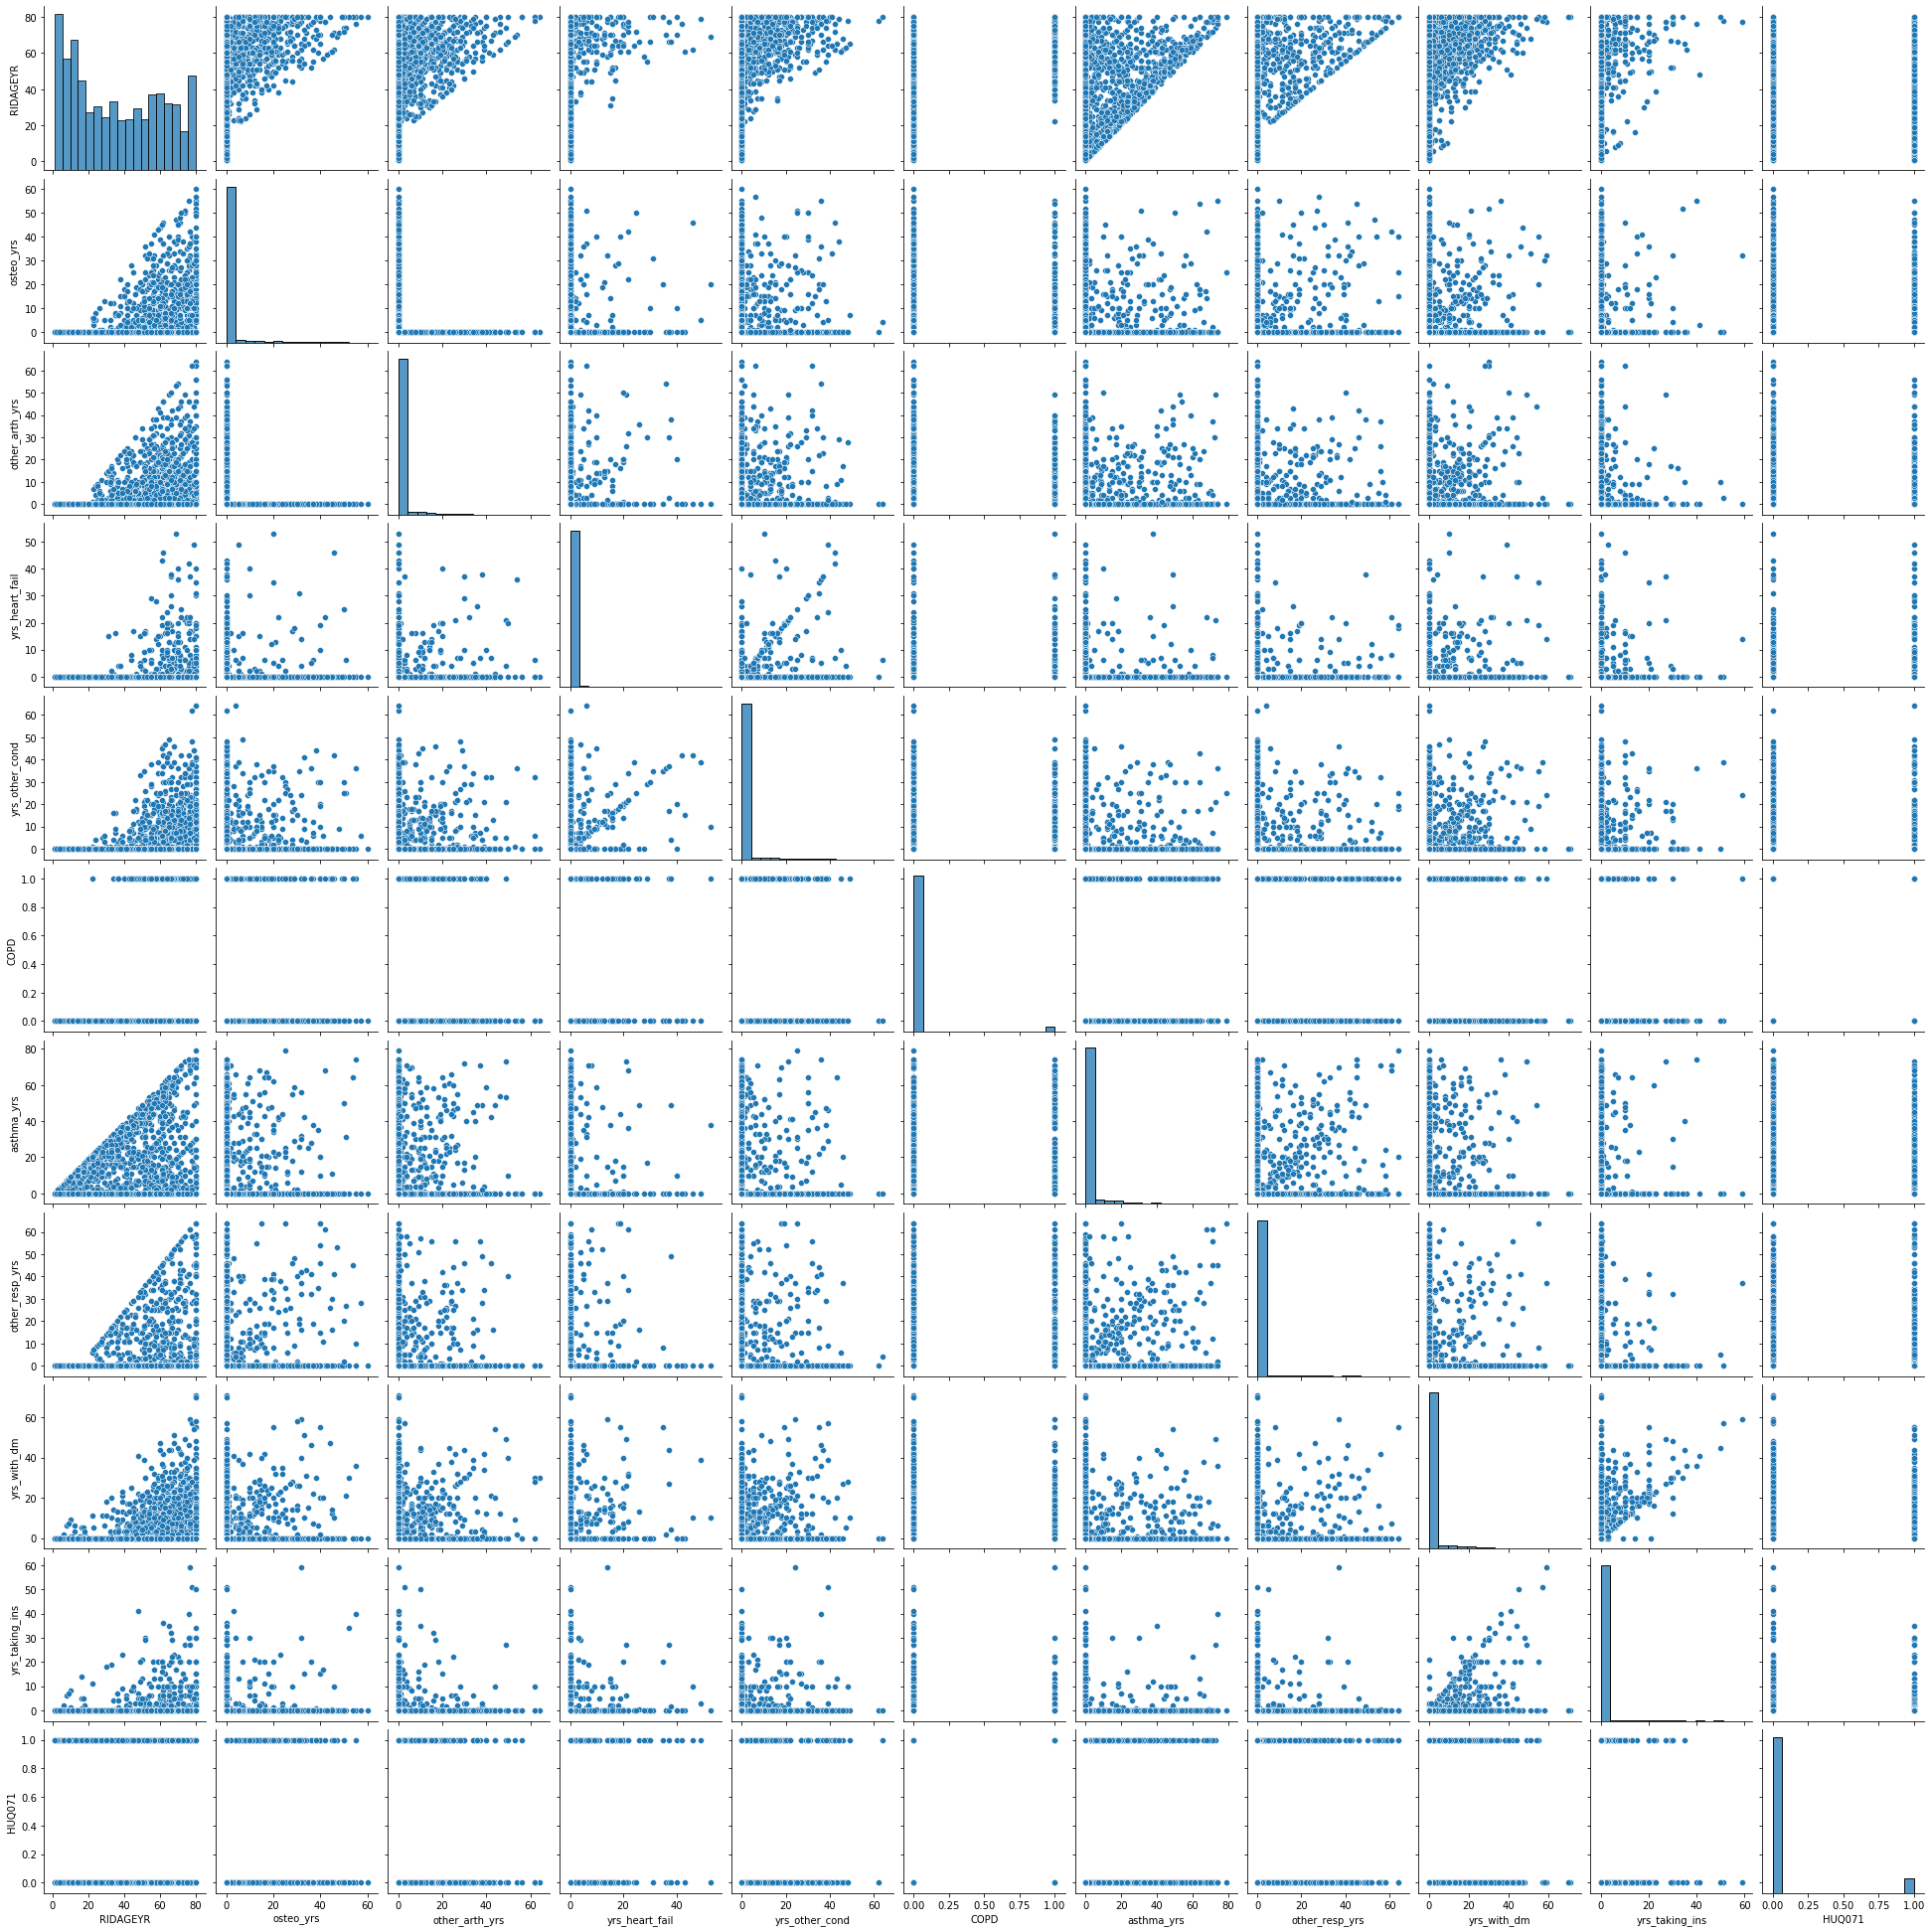

In [90]:
sns.pairplot(yrs_df_3)

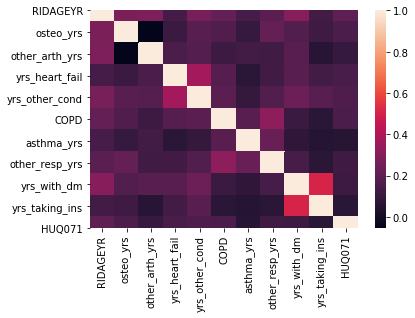

In [91]:
corr = yrs_df_3.corr()
sns.heatmap(corr)

# no strong correlations
# even diabetes and taking insulin is only 50% correlated
# nothing is strongly correlated with hospitalization (HUQ071)

In [92]:
# define X and y

X = yrs_df_3.drop(columns = 'HUQ071')
y = yrs_df_3['HUQ071']

In [93]:
# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

# look at cross_validate instead of doing by hand
# and ideally scale in here

In [94]:
def k_fold_validator(X, y, classifier, cv=5):

    """Uses k-fold cross-validation to calculate the mean recall, precision, and f1 scores 
    for train and test sets for a model.  Also plots a confusion matrix for each test set.
    
    Parameters
    ----------
    
    X : DataFrame, Predictors
    
    y : series, Labels assigned
    
    classifier : An instance of a classifier.
    
    cv : int, How many folds to use when cross-validating.  Default = 5.
    
    Returns
    -------
    
    No objects returned.
    
    Prints mean recall, precision, and f1 scores for train and test sets.
    
    Plots a confusion matrix for each test set."""
    
    kf = KFold(n_splits=cv)
    clf = classifier

    train_recall_scores = []
    train_precision_scores = []
    train_f1_scores = []
    test_recall_scores = []
    test_precision_scores = []
    test_f1_scores = []
    
    print('Classifier:', clf)
    print('Cross-validation folds:', cv)
    
    print('\n')
    print('ROC-AUC Cross Validation:', cross_val_score(clf, X, y, scoring='roc_auc'))
    print('Mean ROC-AUC Score:', round(cross_val_score(clf, X, y, scoring='roc_auc').mean(), 3))
    
    
    for train_index, test_index in kf.split(X):

        X_tr, X_test = X.iloc[train_index].astype(str), X.iloc[test_index].astype(str)
        y_tr, y_test = y.iloc[train_index].astype(str), y.iloc[test_index].astype(str)
        
        clf.fit(X_tr, y_tr)

        y_pred_tr = clf.predict(X_tr)
        y_pred_test = clf.predict(X_test)

        train_recall_scores.append(recall_score(y_tr, y_pred_tr, pos_label='1.0'))
        train_precision_scores.append(precision_score(y_tr, y_pred_tr, pos_label='1.0'))
        train_f1_scores.append(f1_score(y_tr, y_pred_tr, pos_label='1.0'))       
        test_recall_scores.append(recall_score(y_test, y_pred_test, pos_label='1.0'))
        test_precision_scores.append(precision_score(y_test, y_pred_test, pos_label='1.0'))
        test_f1_scores.append(f1_score(y_test, y_pred_test, pos_label='1.0'))       
        
        plot_confusion_matrix(clf, X_test, y_test)
        plt.title('Test set')
        
    print('\n')
    
    print('Train mean recall: {} +/- {}'.format(round(pd.Series(train_recall_scores).mean(), 2), 
                                               round(pd.Series(train_recall_scores).std(), 2)))
    
    print('Train mean precision: {} +/- {}'.format(round(pd.Series(train_precision_scores).mean(), 2),
                                                  round(pd.Series(train_precision_scores).std(), 2)))
    
    print('Train mean F1: {} +/- {}'.format(round(pd.Series(train_f1_scores).mean(), 2),
                                           round(pd.Series(train_f1_scores).std(), 2)))
    print('\n')
    
    print('Test mean recall: {} +/- {}'.format(round(pd.Series(test_recall_scores).mean(), 2),
                                               round(pd.Series(test_recall_scores).std(), 2)))
    
    print('Test mean precision: {} +/- {}'.format(round(pd.Series(test_precision_scores).mean(), 2),
                                                  round(pd.Series(test_precision_scores).std(), 2)))
    
    print('Test mean F1: {} +/- {}'.format(round(pd.Series(test_f1_scores).mean(), 2),
                                           round(pd.Series(test_f1_scores).std(), 2)))

In [95]:
def order_features(weights, X_train):
    
    coef_dict = {}

    for n, c in enumerate(X_train.columns):
        coef_dict[c]=round(weights[0][n],4)

    sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse=True)}
    df = pd.DataFrame.from_dict(sorted_coef_dict, orient='index', columns=['weight'])
    df['abs_weight']=np.abs(df['weight'])
    weights_df = df.sort_values(by = 'abs_weight', ascending=False)
    
    return weights_df

Classifier: LogisticRegression(max_iter=10000)
Cross-validation folds: 5


ROC-AUC Cross Validation: [0.74940422 0.70891048 0.70168232 0.71642121 0.73566166]
Mean ROC-AUC Score: 0.722


Train mean recall: 0.03 +/- 0.01
Train mean precision: 0.55 +/- 0.12
Train mean F1: 0.06 +/- 0.02


Test mean recall: 0.03 +/- 0.02
Test mean precision: 0.51 +/- 0.34
Test mean F1: 0.05 +/- 0.04


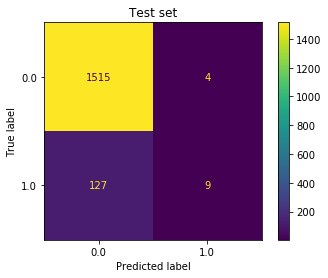

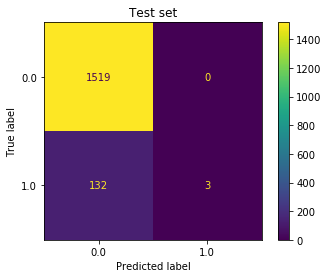

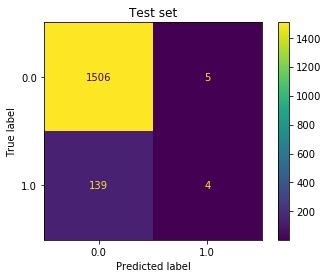

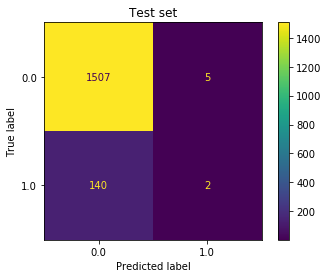

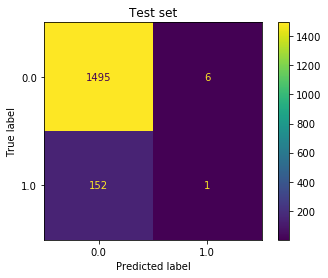

In [96]:
# try a logistic regression
# why does MinMaxScaler have slightly lower recall than StandardScaler?

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

logreg = LogisticRegression(max_iter=10000)

logreg.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, logreg)

In [97]:
order_features(logreg.coef_, X_train_scaled)

weight  abs_weight
yrs_heart_fail  2.00570     2.00570
RIDAGEYR        1.73080     1.73080
osteo_yrs       1.53810     1.53810
yrs_other_cond  1.22520     1.22520
COPD            0.75800     0.75800
yrs_with_dm     0.71940     0.71940
other_arth_yrs  0.40500     0.40500
asthma_yrs      0.18520     0.18520
yrs_taking_ins -0.17200     0.17200
other_resp_yrs  0.16580     0.16580

Classifier: ComplementNB()
Cross-validation folds: 5


ROC-AUC Cross Validation: [0.58462108 0.55597118 0.54862043 0.49013758 0.58750885]
Mean ROC-AUC Score: 0.553


Train mean recall: 0.31 +/- 0.0
Train mean precision: 0.26 +/- 0.01
Train mean F1: 0.28 +/- 0.01


Test mean recall: 0.3 +/- 0.03
Test mean precision: 0.26 +/- 0.03
Test mean F1: 0.28 +/- 0.03


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


weight  abs_weight
yrs_heart_fail 5.31280     5.31280
yrs_taking_ins 4.91030     4.91030
yrs_other_cond 3.95910     3.95910
other_resp_yrs 3.78690     3.78690
osteo_yrs      3.66670     3.66670
yrs_with_dm    3.54990     3.54990
other_arth_yrs 3.44500     3.44500
COPD           3.14700     3.14700
asthma_yrs     2.83580     2.83580
RIDAGEYR       0.27690     0.27690

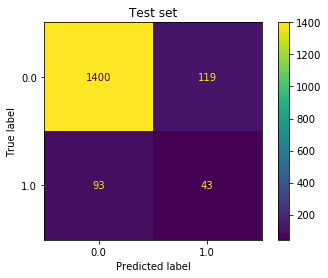

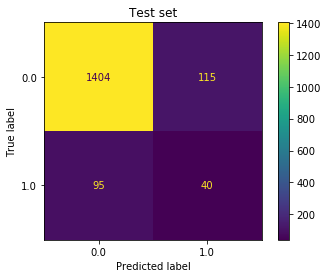

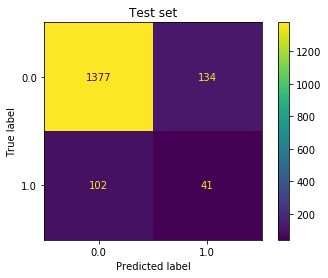

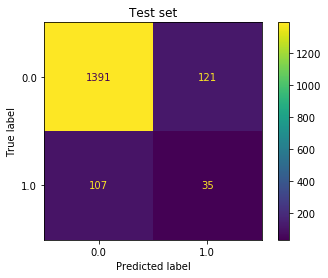

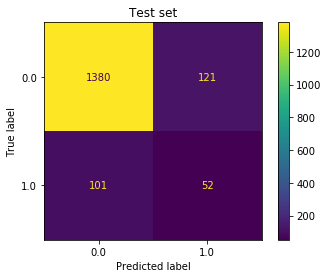

In [98]:
# try a complement naive Bayes

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)

Classifier: DecisionTreeClassifier(max_depth=6, min_samples_split=15)
Cross-validation folds: 5


ROC-AUC Cross Validation: [0.66053592 0.71281283 0.68816603 0.70622112 0.71370119]
Mean ROC-AUC Score: 0.696


Train mean recall: 0.12 +/- 0.02
Train mean precision: 0.78 +/- 0.07
Train mean F1: 0.21 +/- 0.02


Test mean recall: 0.06 +/- 0.03
Test mean precision: 0.37 +/- 0.12
Test mean F1: 0.1 +/- 0.04


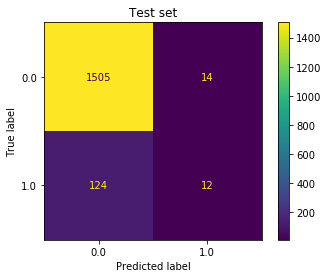

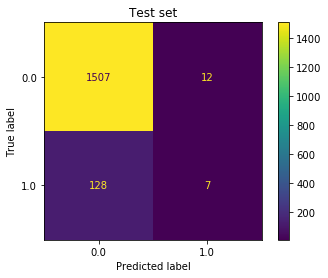

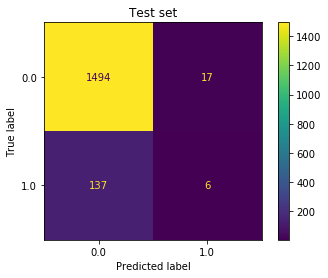

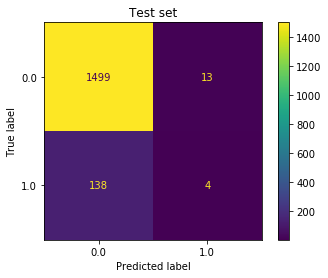

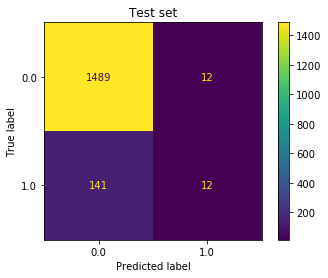

In [99]:
# try a decision tree
# overfit - tried to prune but not successful

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

tree = DecisionTreeClassifier(max_depth=6, min_samples_split=15)

tree.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, tree)

In [100]:
def order_features_2(weights, X_train):
    
    coef_dict = {}

    for n, c in enumerate(X_train.columns):
        coef_dict[c]=round(weights[n],4)

    sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse=True)}
    df = pd.DataFrame.from_dict(sorted_coef_dict, orient='index', columns=['weight'])
    df['abs_weight']=np.abs(df['weight'])
    weights_df = df.sort_values(by = 'abs_weight', ascending=False)
    
    return weights_df

In [101]:
order_features_2(tree.feature_importances_, X_train_scaled)

weight  abs_weight
yrs_other_cond 0.37800     0.37800
RIDAGEYR       0.19480     0.19480
other_resp_yrs 0.12230     0.12230
yrs_heart_fail 0.11260     0.11260
osteo_yrs      0.08780     0.08780
yrs_with_dm    0.03530     0.03530
other_arth_yrs 0.02950     0.02950
yrs_taking_ins 0.01540     0.01540
COPD           0.01500     0.01500
asthma_yrs     0.00920     0.00920

In [102]:
# explore PCA.  I'm confused

pca = PCA(n_components=9)
pca.fit(X_training, y_training)

pca.components_
# pca.explained_variance_
# pca.get_params()
# pca.singular_values_

array([[ 9.89643184e-01,  5.73542089e-02,  6.18478978e-02,
         1.39270231e-02,  4.75629774e-02,  1.62352729e-03,
         6.31603788e-02,  4.69903946e-02,  6.83066535e-02,
         1.30282899e-02],
       [-8.34407422e-02,  4.20949312e-02,  7.62440236e-02,
         1.83863999e-02,  3.66578753e-02,  3.67621644e-03,
         9.71629243e-01,  1.94735514e-01,  4.08088457e-02,
         1.03181892e-02],
       [-1.03167651e-01,  3.48056152e-01,  1.82799403e-01,
         1.10459958e-01,  3.07216124e-01,  6.58617354e-03,
        -2.00287077e-01,  6.21093280e-01,  5.31290261e-01,
         1.41527685e-01],
       [-3.11395132e-02, -5.18555425e-01,  7.26881687e-01,
         5.67323076e-02,  1.20394225e-01, -2.20797027e-03,
        -5.27709881e-05, -2.83189172e-01,  3.14594247e-01,
         6.99268570e-02],
       [-1.74040572e-02,  2.28204862e-01, -3.75059299e-01,
         2.19209029e-02,  6.98997284e-02, -4.39328944e-03,
         1.07472552e-01, -6.02475485e-01,  6.27182387e-01,
         1.

In [103]:
# other features to try:
# lang spoken at home
# liver condition
# depression
# alcohol-related disorders
# childbirth - exclude 70 ppl who had babies in the past 12 months? RHQ197 - How many months ago have baby?
# sickle cell
# language

# other things to try:
# svm
# neural net

In [104]:
dfs_to_merge = [arth_binary, circ_binary, resp_binary, dm_binary, target]

binary_df = age.copy()

for df in dfs_to_merge:
    binary_df = binary_df.merge(df, how='left', on='SEQN')

binary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9254 entries, 0 to 9253
Data columns (total 12 columns):
SEQN                 9254 non-null float64
RIDAGEYR             9254 non-null float64
osteo_yrs            8897 non-null float64
other_arth_yrs       8897 non-null float64
heart_fail_binary    8897 non-null float64
other_cond_binary    8897 non-null float64
COPD                 8897 non-null float64
asthma_yrs           8897 non-null float64
other_resp_yrs       8897 non-null float64
dm_binary            8897 non-null float64
insulin_binary       8897 non-null float64
HUQ071               9251 non-null float64
dtypes: float64(12)
memory usage: 939.9 KB


In [105]:
# the people with nulls in all the health questions are babies - remove them

binary_df = binary_df.loc[~binary_df['osteo_yrs'].isna()]
binary_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8897 entries, 0 to 9253
Data columns (total 12 columns):
SEQN                 8897 non-null float64
RIDAGEYR             8897 non-null float64
osteo_yrs            8897 non-null float64
other_arth_yrs       8897 non-null float64
heart_fail_binary    8897 non-null float64
other_cond_binary    8897 non-null float64
COPD                 8897 non-null float64
asthma_yrs           8897 non-null float64
other_resp_yrs       8897 non-null float64
dm_binary            8897 non-null float64
insulin_binary       8897 non-null float64
HUQ071               8894 non-null float64
dtypes: float64(12)
memory usage: 903.6 KB


In [106]:
# we need the target!  remove rows where target is null

binary_df_2 = binary_df.loc[~yrs_df_2['HUQ071'].isna()].set_index('SEQN')
binary_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8894 entries, 93703.0 to 102956.0
Data columns (total 11 columns):
RIDAGEYR             8894 non-null float64
osteo_yrs            8894 non-null float64
other_arth_yrs       8894 non-null float64
heart_fail_binary    8894 non-null float64
other_cond_binary    8894 non-null float64
COPD                 8894 non-null float64
asthma_yrs           8894 non-null float64
other_resp_yrs       8894 non-null float64
dm_binary            8894 non-null float64
insulin_binary       8894 non-null float64
HUQ071               8894 non-null float64
dtypes: float64(11)
memory usage: 833.8 KB


In [107]:
# minority class is just 8.5 %

binary_df_2['HUQ071'].value_counts(normalize=True)

0.00000   0.91455
1.00000   0.08545
Name: HUQ071, dtype: float64

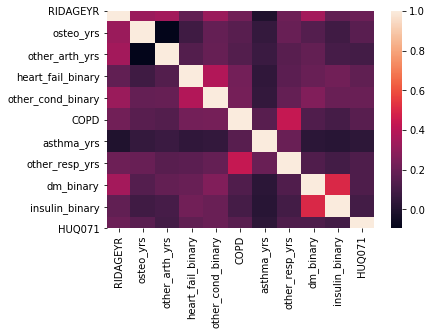

In [108]:
corr = binary_df_2.corr()
sns.heatmap(corr)

# no strong correlations
# even diabetes and taking insulin is only 50% correlated
# nothing is strongly correlated with hospitalization (HUQ071)

In [109]:
# define X and y

X = binary_df_2.drop(columns = 'HUQ071')
y = binary_df_2['HUQ071']

In [110]:
# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

Classifier: ComplementNB()
Cross-validation folds: 5


ROC-AUC Cross Validation: [0.64855757 0.59904    0.57133309 0.5980862  0.63321829]
Mean ROC-AUC Score: 0.61


Train mean recall: 0.44 +/- 0.01
Train mean precision: 0.25 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.44 +/- 0.04
Test mean precision: 0.24 +/- 0.02
Test mean F1: 0.31 +/- 0.02


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


weight  abs_weight
heart_fail_binary 4.23220     4.23220
COPD              3.68120     3.68120
insulin_binary    3.63370     3.63370
other_resp_yrs    3.18290     3.18290
other_cond_binary 2.90800     2.90800
osteo_yrs         2.71870     2.71870
dm_binary         2.43440     2.43440
other_arth_yrs    2.34650     2.34650
asthma_yrs        1.93680     1.93680
RIDAGEYR          0.81110     0.81110

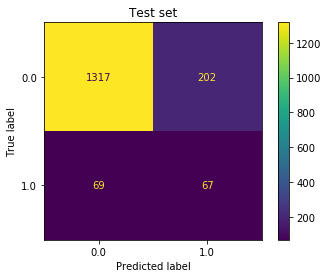

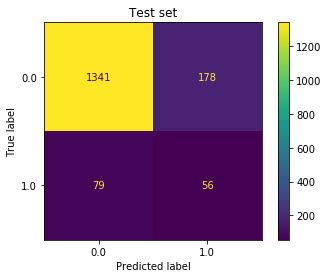

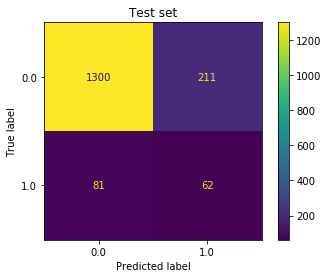

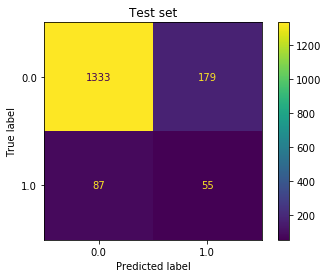

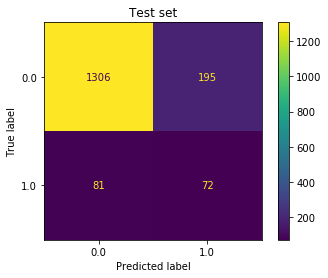

In [111]:
# try a complement naive Bayes

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)

In [112]:
# add race

# RIDRETH3 - Race/Hispanic origin w/ NH Asian
# Variable Name:RIDRETH3SAS Label:Race/Hispanic origin w/ NH AsianEnglish Text:Recode of reported race and Hispanic origin information, with Non-Hispanic Asian CategoryTarget:Both males and females 0 YEARS - 150 YEARS
# Code or Value	Value Description	Count	Cumulative	Skip to Item
# 1	Mexican American	1367	1367	
# 2	Other Hispanic	820	2187	
# 3	Non-Hispanic White	3150	5337	
# 4	Non-Hispanic Black	2115	7452	
# 6	Non-Hispanic Asian	1168	8620	
# 7	Other Race - Including Multi-Racial	634	9254	
# .	Missing	0	9254	

race = demo_j[['SEQN', 'RIDRETH3']]
race_2 = pd.get_dummies(race, columns=['RIDRETH3'])
race_3 = race_2.drop(columns = ['RIDRETH3_7.0'])
race_3

SEQN  RIDRETH3_1.0  RIDRETH3_2.0  RIDRETH3_3.0  RIDRETH3_4.0  \
0     93703.00000             0             0             0             0   
1     93704.00000             0             0             1             0   
2     93705.00000             0             0             0             1   
3     93706.00000             0             0             0             0   
4     93707.00000             0             0             0             0   
...           ...           ...           ...           ...           ...   
9249 102952.00000             0             0             0             0   
9250 102953.00000             1             0             0             0   
9251 102954.00000             0             0             0             1   
9252 102955.00000             0             0             0             1   
9253 102956.00000             0             0             1             0   

      RIDRETH3_6.0  
0                1  
1                0  
2                0  
3                1  
4                0  
...            ...  
9249             1  
9250             0  
9251             0  
9252             0  
9253             0  

[9254 rows x 6 columns]

In [113]:
binary_df_3 = binary_df_2.merge(race_3, how='left', on='SEQN').set_index('SEQN')
binary_df_3.head(200)

RIDAGEYR  osteo_yrs  other_arth_yrs  heart_fail_binary  \
SEQN                                                                  
93703.00000   2.00000    0.00000         0.00000            0.00000   
93704.00000   2.00000    0.00000         0.00000            0.00000   
93705.00000  66.00000    0.00000         1.00000            0.00000   
93706.00000  18.00000    0.00000         0.00000            0.00000   
93707.00000  13.00000    0.00000         0.00000            0.00000   
93708.00000  66.00000    0.00000         0.00000            0.00000   
93709.00000  75.00000    0.00000         1.00000            0.00000   
93711.00000  56.00000    0.00000         0.00000            0.00000   
93712.00000  18.00000    0.00000         0.00000            0.00000   
93713.00000  67.00000    0.00000         1.00000            0.00000   
93714.00000  54.00000    0.00000         0.00000            0.00000   
93715.00000  71.00000    1.00000         0.00000            0.00000   
93716.00000  61.00000    0.00000         1.00000            0.00000   
93717.00000  22.00000    0.00000         0.00000            0.00000   
93718.00000  45.00000    0.00000         0.00000            0.00000   
93719.00000  13.00000    0.00000         0.00000            0.00000   
93720.00000   1.00000    0.00000         0.00000            0.00000   
93721.00000  60.00000    0.00000         0.00000            0.00000   
93722.00000  60.00000    0.00000         0.00000            0.00000   
93723.00000  64.00000    1.00000         0.00000            0.00000   
93724.00000   5.00000    0.00000         0.00000            0.00000   
93725.00000   9.00000    0.00000         0.00000            0.00000   
93726.00000  67.00000    0.00000         0.00000            0.00000   
93727.00000  70.00000    0.00000         0.00000            0.00000   
93728.00000  53.00000    0.00000         0.00000            0.00000   
93729.00000  42.00000    0.00000         0.00000            0.00000   
93730.00000  57.00000    0.00000         0.00000            0.00000   
93731.00000  20.00000    0.00000         0.00000            0.00000   
93732.00000  72.00000    0.00000         0.00000            0.00000   
93733.00000  11.00000    0.00000         0.00000            0.00000   
93734.00000  13.00000    0.00000         0.00000            0.00000   
93735.00000  52.00000    0.00000         0.00000            0.00000   
93736.00000  11.00000    0.00000         0.00000            0.00000   
93737.00000   8.00000    0.00000         0.00000            0.00000   
93738.00000  26.00000    0.00000         0.00000            0.00000   
93739.00000   5.00000    0.00000         0.00000            0.00000   
93740.00000  72.00000    0.00000         1.00000            1.00000   
93741.00000   9.00000    0.00000         0.00000            0.00000   
93742.00000  72.00000    1.00000         0.00000            0.00000   
93743.00000  61.00000    0.00000         1.00000            0.00000   
93744.00000  10.00000    0.00000         0.00000            0.00000   
93745.00000   5.00000    0.00000         0.00000            0.00000   
93746.00000  25.00000    0.00000         0.00000            0.00000   
93747.00000  13.00000    0.00000         0.00000            0.00000   
93749.00000   1.00000    0.00000         0.00000            0.00000   
93750.00000  52.00000    0.00000         0.00000            0.00000   
93751.00000   7.00000    0.00000         0.00000            0.00000   
93752.00000  73.00000    0.00000         0.00000            0.00000   
93753.00000  10.00000    0.00000         0.00000            0.00000   
93754.00000  72.00000    0.00000         0.00000            0.00000   
93755.00000  26.00000    0.00000         0.00000            0.00000   
93756.00000  64.00000    0.00000         0.00000            0.00000   
93757.00000  63.00000    0.00000         1.00000            0.00000   
93758.00000  55.00000    1.00000         0.00000            0.00000   
93759.00000  60.00000    0.00000     

Classifier: ComplementNB()
Cross-validation folds: 5


ROC-AUC Cross Validation: [0.7484198  0.68945498 0.67410481 0.67269823 0.70056217]
Mean ROC-AUC Score: 0.697


Train mean recall: 0.51 +/- 0.01
Train mean precision: 0.23 +/- 0.01
Train mean F1: 0.31 +/- 0.01


Test mean recall: 0.5 +/- 0.04
Test mean precision: 0.22 +/- 0.02
Test mean F1: 0.31 +/- 0.02


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


weight  abs_weight
heart_fail_binary 4.92100     4.92100
COPD              4.37000     4.37000
insulin_binary    4.32260     4.32260
other_resp_yrs    3.87180     3.87180
other_cond_binary 3.59690     3.59690
osteo_yrs         3.40760     3.40760
dm_binary         3.12330     3.12330
RIDRETH3_2.0      3.07840     3.07840
other_arth_yrs    3.03540     3.03540
RIDRETH3_6.0      2.63420     2.63420
asthma_yrs        2.62570     2.62570
RIDRETH3_1.0      2.51010     2.51010
RIDRETH3_4.0      2.09990     2.09990
RIDRETH3_3.0      1.73550     1.73550
RIDAGEYR          1.50000     1.50000

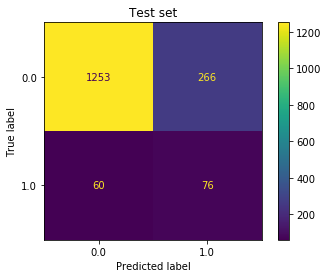

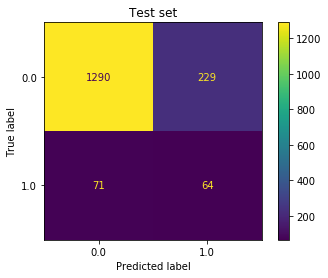

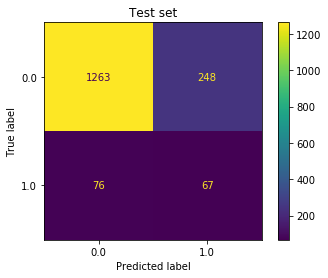

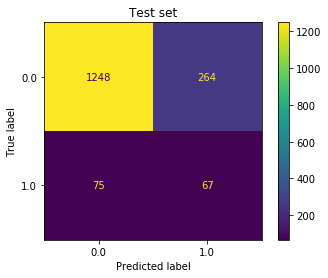

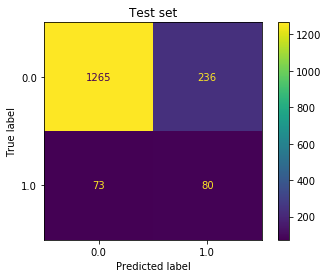

In [114]:
# define X and y

X = binary_df_3.drop(columns = 'HUQ071')
y = binary_df_3['HUQ071']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

# try a complement naive Bayes

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)

# wow!  recall improves and precision worsens only a little

In [115]:
# explore prescription drug use table

rxq_rx_j.head(200)

SEQN  RXDUSE                            RXDDRUG RXDDRGID  RXQSEEN  \
0   93703.00000 2.00000                                                  nan   
1   93704.00000 2.00000                                                  nan   
2   93705.00000 1.00000     ENALAPRIL; HYDROCHLOROTHIAZIDE   d03740  1.00000   
3   93705.00000 1.00000                          MELOXICAM   d04532  1.00000   
4   93705.00000 1.00000                         OMEPRAZOLE   d00325  1.00000   
5   93706.00000 2.00000                                                  nan   
6   93707.00000 2.00000                                                  nan   
7   93708.00000 1.00000                         AMLODIPINE   d00689  2.00000   
8   93708.00000 1.00000                           LOSARTAN   d03821  2.00000   
9   93708.00000 1.00000                        SIMVASTATIN   d00746  2.00000   
10  93709.00000 1.00000                         AMLODIPINE   d00689  1.00000   
11  93709.00000 1.00000                           NAPROXEN   d00019  1.00000   
12  93709.00000 1.00000                         SERTRALINE   d00880  1.00000   
13  93709.00000 1.00000                         TAMSULOSIN   d04121  1.00000   
14  93710.00000 2.00000                                                  nan   
15  93711.00000 2.00000                                                  nan   
16  93712.00000 2.00000                                                  nan   
17  93713.00000 1.00000           ACETAMINOPHEN; OXYCODONE   d03431  1.00000   
18  93714.00000 1.00000  INSULIN ISOPHANE; INSULIN REGULAR   d04374  1.00000   
19  93715.00000 1.00000           ACETAMINOPHEN; OXYCODONE   d03431  1.00000   
20  93715.00000 1.00000                       ATORVASTATIN   d04105  1.00000   
21  93715.00000 1.00000            FLUTICASONE; VILANTEROL   d08100  1.00000   
22  93715.00000 1.00000                      LEVOTHYROXINE   d00278  1.00000   
23  93715.00000 1.00000                         PREDNISONE   d00350  1.00000   
24  93715.00000 1.00000                         SERTRALINE   d00880  1.00000   
25  93715.00000 1.00000                         SILDENAFIL   d04299  1.00000   
26  93715.00000 1.00000                       UMECLIDINIUM   d08187  1.00000   
27  93716.00000 2.00000                                                  nan   
28  93717.00000 2.00000                                                  nan   
29  93718.00000 1.00000                         LISINOPRIL   d00732  1.00000   
30  93719.00000 1.00000                          ALBUTEROL   d00749  2.00000   
31  93719.00000 1.00000                         CETIRIZINE   d03827  1.00000   
32  93720.00000 1.00000           POLYETHYLENE GLYCOL 3350   d05350  1.00000   
33  93721.00000 2.00000                                                  nan   
34  93722.00000 1.00000                        ALENDRONATE   d03849  1.00000   
35  93722.00000 1.00000                        BENZONATATE   d00796  1.00000   
36  93722.00000 1.00000                         BUTALBITAL   d03061  1.00000   
37  93722.00000 1.00000                           FENTANYL   d00233  1.00000   
38  93722.00000 1.00000                        FLUTICASONE   d01296  1.00000   
39  93722.00000 1.00000                          IBUPROFEN   d00015  1.00000   
40  93722.00000 1.00000                  LIDOCAINE TOPICAL   d00683  1.00000   
41  93722.00000 1.00000                        MONTELUKAST   d04289  1.00000   
42  93722.00000 1.00000                        PRAMIPEXOLE   d04145  1.00000   
43  93722.00000 1.00000                           ZOLPIDEM   d00910  1.00000   
44  93723.00000 2.00000                                                  nan   
45  93724.00000 2.00000                                                  nan   
46  93725.00000 2.00000                                                  nan   
47  93726.00000 1.00000                       PANTOPRAZOLE   d04514  1.00000   
48  93727.00000 1.00000                      LEVETIRACETAM   d04499  1.00000   
49  93727.0

In [116]:
rxq_rx_j['SEQN'].nunique()

9254

In [117]:
rxq_rx_j.duplicated().sum()

# looks like there are a few true duplicate lines in the data

15

In [118]:
# view duplicates
# looks like data entry errors - eliminate duplicates

dups = rxq_rx_j.loc[rxq_rx_j.duplicated(keep = False) == True].sort_values(by=['SEQN'], ascending=True).head(200)
dups

SEQN  RXDUSE               RXDDRUG RXDDRGID  RXQSEEN    RXDDAYS  \
899    94109.00000 1.00000             ALBUTEROL   d00749  1.00000 1825.00000   
900    94109.00000 1.00000             ALBUTEROL   d00749  1.00000 1825.00000   
4092   95596.00000 1.00000             ALBUTEROL   d00749  1.00000    6.00000   
4093   95596.00000 1.00000             ALBUTEROL   d00749  1.00000    6.00000   
5929   96435.00000 1.00000             ALBUTEROL   d00749  1.00000 1460.00000   
5930   96435.00000 1.00000             ALBUTEROL   d00749  1.00000 1460.00000   
7262   97058.00000 1.00000          PIOGLITAZONE   d04442  1.00000 7300.00000   
7263   97058.00000 1.00000          PIOGLITAZONE   d04442  1.00000 7300.00000   
8935   97871.00000 1.00000          ATORVASTATIN   d04105  2.00000 1460.00000   
8936   97871.00000 1.00000          ATORVASTATIN   d04105  2.00000 1460.00000   
10593  98696.00000 1.00000             ALBUTEROL   d00749  1.00000 1825.00000   
10594  98696.00000 1.00000             ALBUTEROL   d00749  1.00000 1825.00000   
10793  98787.00000 1.00000             ALBUTEROL   d00749  1.00000  182.00000   
10794  98787.00000 1.00000             ALBUTEROL   d00749  1.00000  182.00000   
13194  99934.00000 1.00000  KETOCONAZOLE TOPICAL   d03202  2.00000   91.00000   
13193  99934.00000 1.00000  KETOCONAZOLE TOPICAL   d03202  2.00000   91.00000   
14230 100409.00000 1.00000       METHYLPHENIDATE   d00900  1.00000  122.00000   
14231 100409.00000 1.00000       METHYLPHENIDATE   d00900  1.00000  122.00000   
15575 101057.00000 1.00000       METHYLPHENIDATE   d00900  1.00000 1825.00000   
15576 101057.00000 1.00000       METHYLPHENIDATE   d00900  1.00000 1825.00000   
15615 101081.00000 1.00000             ALBUTEROL   d00749  1.00000 3650.00000   
15616 101081.00000 1.00000             ALBUTEROL   d00749  1.00000 3650.00000   
15717 101123.00000 1.00000             ALBUTEROL   d00749  1.00000 1825.00000   
15718 101123.00000 1.00000             ALBUTEROL   d00749  1.00000 1825.00000   
17136 101764.00000 1.00000             ALBUTEROL   d00749  1.00000   45.00000   
17137 101764.00000 1.00000             ALBUTEROL   d00749  1.00000   45.00000   
17505 101945.00000 1.00000             ALBUTEROL   d00749  1.00000 3650.00000   
17506 101945.00000 1.00000             ALBUTEROL   d00749  1.00000 3650.00000   
18467 102419.00000 1.00000       METHYLPHENIDATE   d00900  1.00000   91.00000   
18468 102419.00000 1.00000       METHYLPHENIDATE   d00900  1.00000   91.00000   

      RXDRSC1 RXDRSC2 RXDRSC3  \
899       J45                   
900       J45                   
4092    J20.9                   
4093    J20.9                   
5929      J45                   
5930      J45                   
7262      E11                   
7263      E11                   
8935   E78.0P                   
8936   E78.0P                   
10593     J45                   
10594     J45                   
10793     J45                   
10794     J45                   
13194   L30.9                   
13193   L30.9                   
14230     F90                   
14231     F90                   
15575     F90                   
15576     F90                   
15615   J20.9     J45   R06.2   
15616   J20.9     J45   R06.2   
15717   J44.9                   
15718   J44.9                   
17136     J45                   
17137     J45                   
17505     J43   J44.9           
17506     J43   J44.9           
18467     F90                   
18468     F90                   

                                                  RXDRSD1  \
899                                                Asthma   
900                                                Asthma   
4092                        Acute bronchitis, unspecified   
4093                        Acute bronchitis, unspecified   
5929                                               Asthma   
5930                                               Asthma   
7262                             Type 2 diabetes me

In [119]:
# eliminate duplicates

rx_df = rxq_rx_j.drop_duplicates()

In [120]:
# create df showing just rx and days, to create a table of how many rx per patient
# eliminate 9 (refuse to answer) and 7 (don't remember)

rx_df = rx_df[['SEQN','RXDDRUG','RXDDAYS']].loc[rx_df['RXDUSE'].isin([1,2])]

In [121]:
rx_df

SEQN                         RXDDRUG    RXDDAYS
0      93703.00000                                        nan
1      93704.00000                                        nan
2      93705.00000  ENALAPRIL; HYDROCHLOROTHIAZIDE 5475.00000
3      93705.00000                       MELOXICAM   61.00000
4      93705.00000                      OMEPRAZOLE 3650.00000
...            ...                             ...        ...
19638 102956.00000                      CETIRIZINE    4.00000
19639 102956.00000                      DULOXETINE  365.00000
19640 102956.00000               FLUTICASONE NASAL    4.00000
19641 102956.00000                      GABAPENTIN  365.00000
19642 102956.00000                   NORTRIPTYLINE  365.00000

[19617 rows x 3 columns]

In [122]:
rx_df['SEQN'].nunique()

9243

In [123]:
# still some duplicates, why?

rx_df.duplicated().sum()

10

In [124]:
# view duplicates

dups = rx_df.loc[rx_df.duplicated(keep = False) == True].sort_values(by=['SEQN'], ascending=True).head(200)
dups

SEQN       RXDDRUG    RXDDAYS
5233   96122.00000   MONTELUKAST 3650.00000
5234   96122.00000   MONTELUKAST 3650.00000
7744   97281.00000     ALBUTEROL 2190.00000
7745   97281.00000     ALBUTEROL 2190.00000
11841  99298.00000     ALBUTEROL 2190.00000
11842  99298.00000     ALBUTEROL 2190.00000
14914 100728.00000     MELOXICAM  365.00000
14915 100728.00000     MELOXICAM  365.00000
15010 100780.00000      MORPHINE 3285.00000
15009 100780.00000      MORPHINE 3285.00000
15931 101213.00000  ESCITALOPRAM 1825.00000
15932 101213.00000  ESCITALOPRAM 1825.00000
17059 101737.00000     ALBUTEROL  365.00000
17060 101737.00000     ALBUTEROL  365.00000
18049 102230.00000     ALBUTEROL 1095.00000
18050 102230.00000     ALBUTEROL 1095.00000
18503 102441.00000         55555 4380.00000
18504 102441.00000         55555 4380.00000
19238 102775.00000     ALBUTEROL 2555.00000
19239 102775.00000     ALBUTEROL 2555.00000

In [125]:
# view SEQNs in original data

rxq_rx_j.loc[rxq_rx_j['SEQN'] == 102775.00000]

# I see, drugs are the same but diagnoses are different
# or RXQSEEN is different (whether interviewer saw the rx)

# looks like data entry errors - eliminate these as well, since we're just looking at counting drugs per patient

SEQN  RXDUSE                   RXDDRUG RXDDRGID  RXQSEEN  \
19238 102775.00000 1.00000                 ALBUTEROL   d00749  1.00000   
19239 102775.00000 1.00000                 ALBUTEROL   d00749  1.00000   
19240 102775.00000 1.00000              ATORVASTATIN   d04105  1.00000   
19241 102775.00000 1.00000             CANAGLIFLOZIN   d08080  1.00000   
19242 102775.00000 1.00000                FLUOXETINE   d00236  1.00000   
19243 102775.00000 1.00000       HYDROCHLOROTHIAZIDE   d00253  1.00000   
19244 102775.00000 1.00000           INSULIN DETEMIR   d05436  1.00000   
19245 102775.00000 1.00000                LISINOPRIL   d00732  1.00000   
19246 102775.00000 1.00000                OMEPRAZOLE   d00325  1.00000   
19247 102775.00000 1.00000                PREGABALIN   d05508  1.00000   
19248 102775.00000 1.00000  UMECLIDINIUM; VILANTEROL   d08188  1.00000   

         RXDDAYS RXDRSC1 RXDRSC2 RXDRSC3  \
19238 2555.00000   J44.9     J45           
19239 2555.00000     J45                   
19240 2555.00000   E78.0                   
19241 1095.00000     E11                   
19242 2555.00000   F32.9                   
19243 2555.00000     I10                   
19244 1460.00000     E11                   
19245 2555.00000     I10                   
19246 2555.00000     K21                   
19247  274.00000   E11.4                   
19248   14.00000   J44.9                   

                                                        RXDRSD1 RXDRSD2  \
19238        Chronic obstructive pulmonary disease, unspecified  Asthma   
19239                                                    Asthma           
19240                                 Pure hypercholesterolemia           
19241                                  Type 2 diabetes mellitus           
19242    Major depressive disorder, single episode, unspecified           
19243                          Essential (primary) hypertension           
19244                                  Type 2 diabetes mellitus           
19245                          Essential (primary) hypertension           
19246                          Gastro-esophageal reflux disease           
19247  Type 2 diabetes mellitus with neurological complications           
19248        Chronic obstructive pulmonary disease, unspecified           

      RXDRSD3  RXDCOUNT  
19238          11.00000  
19239          11.00000  
19240          11.00000  
19241          11.00000  
19242          11.00000  
19243          11.00000  
19244          11.00000  
19245          11.00000  
19246          11.00000  
19247          11.00000  
19248          11.00000

In [126]:
rx_df.drop_duplicates(inplace=True)

In [127]:
# recheck duplicates

rx_df.duplicated().sum()

0

In [128]:
# mark meds taken greater than 365 as 1

rx_df.loc[rx_df['RXDDAYS'] >= 365, 'rx_one_year_plus'] = 1
rx_df

SEQN                         RXDDRUG    RXDDAYS  \
0      93703.00000                                        nan   
1      93704.00000                                        nan   
2      93705.00000  ENALAPRIL; HYDROCHLOROTHIAZIDE 5475.00000   
3      93705.00000                       MELOXICAM   61.00000   
4      93705.00000                      OMEPRAZOLE 3650.00000   
...            ...                             ...        ...   
19638 102956.00000                      CETIRIZINE    4.00000   
19639 102956.00000                      DULOXETINE  365.00000   
19640 102956.00000               FLUTICASONE NASAL    4.00000   
19641 102956.00000                      GABAPENTIN  365.00000   
19642 102956.00000                   NORTRIPTYLINE  365.00000   

       rx_one_year_plus  
0                   nan  
1                   nan  
2               1.00000  
3                   nan  
4               1.00000  
...                 ...  
19638               nan  
19639           1.00000  
19640               nan  
19641           1.00000  
19642           1.00000  

[19607 rows x 4 columns]

In [129]:
# now need to look at same drug with different numbers of days and keep longer days

rx_df.loc[rx_df[['SEQN','RXDDRUG']].duplicated(keep = False) == True].sort_values(by=['SEQN', 'RXDDRUG', 'RXDDAYS'], ascending=True).head(200)


SEQN                  RXDDRUG     RXDDAYS  rx_one_year_plus
287    93830.00000               TAMSULOSIN  1825.00000           1.00000
288    93830.00000               TAMSULOSIN 14600.00000           1.00000
387    93875.00000                ALBUTEROL   730.00000           1.00000
388    93875.00000                ALBUTEROL 10950.00000           1.00000
873    94097.00000                ALBUTEROL    10.00000               nan
874    94097.00000                ALBUTEROL  7300.00000           1.00000
1540   94402.00000                ALBUTEROL   152.00000               nan
1541   94402.00000                ALBUTEROL   730.00000           1.00000
1542   94402.00000  FLUTICASONE; SALMETEROL    61.00000               nan
1543   94402.00000  FLUTICASONE; SALMETEROL   365.00000           1.00000
1610   94430.00000                ALBUTEROL   365.00000           1.00000
1611   94430.00000                ALBUTEROL  1095.00000           1.00000
2302   94756.00000                MEMANTINE   365.00000           1.00000
2303   94756.00000                MEMANTINE  1460.00000           1.00000
2601   94917.00000                CLONIDINE    30.00000               nan
2602   94917.00000                CLONIDINE  1460.00000           1.00000
3433   95303.00000                ALBUTEROL   152.00000               nan
3434   95303.00000                ALBUTEROL  2920.00000           1.00000
4522   95777.00000              CLOPIDOGREL   365.00000           1.00000
4523   95777.00000              CLOPIDOGREL  1825.00000           1.00000
7012   96944.00000              VENLAFAXINE    90.00000               nan
7013   96944.00000              VENLAFAXINE  4015.00000           1.00000
7491   97172.00000                ALBUTEROL   730.00000           1.00000
7492   97172.00000                ALBUTEROL  2189.00000           1.00000
8361   97577.00000                ALBUTEROL   182.00000               nan
8362   97577.00000                ALBUTEROL  1095.00000           1.00000
9679   98259.00000                ALBUTEROL   730.00000           1.00000
9680   98259.00000                ALBUTEROL  1825.00000           1.00000
9701   98270.00000   BRIMONIDINE OPHTHALMIC    91.00000               nan
9702   98270.00000   BRIMONIDINE OPHTHALMIC  3650.00000           1.00000
9885   98360.00000               GABAPENTIN    21.00000               nan
9886   98360.00000               GABAPENTIN    61.00000               nan
9946   98386.00000                ALBUTEROL  5110.00000           1.00000
9947   98386.00000                ALBUTEROL  5475.00000           1.00000
10260  98538.00000                ALBUTEROL  1095.00000           1.00000
10261  98538.00000                ALBUTEROL  1460.00000           1.00000
10705  98746.00000                ALBUTEROL    14.00000               nan
10706  98746.00000                ALBUTEROL  6570.00000           1.00000
11117  98939.00000               QUETIAPINE    91.00000               nan
11118  98939.00000               QUETIAPINE  7300.00000           1.00000
11237  98990.00000               LISINOPRIL   334.00000               nan
11238  98990.00000               LISINOPRIL   365.00000           1.00000
11257  98996.00000             ROSUVASTATIN    30.00000               nan
11258  98996.00000             ROSUVASTATIN  3650.00000           1.00000
11642  99205.00000                ALBUTEROL  2190.00000           1.00000
11643  99205.00000                ALBUTEROL  3103.00000           1.00000
12608  99646.00000              SIMVASTATIN   730.00000           1.00000
12609  99646.00000              SIMVASTATIN  1825.00000           1.00000
14122 100380.00000        DIVALPROEX SODIUM   365.00000           1.00000
14123 100380.00000        DIVALPROEX SODIUM  1095.00000           1.00000
14434 100501.00000         INSULIN GLARGINE   365.00000           1.00000
14435 100501.00000         INSULIN GLARGINE   730.00000           1.00000
14972 100763.00000                ALBUTEROL   730.00000           1.00000
14973 100763.00000

In [130]:
# drop duplicates with same SEQN and diagnosis - keep row with greatest days

rx_df.drop_duplicates(subset=['SEQN','RXDDRUG'], keep='last', inplace=True)

In [131]:
rx_df

SEQN                         RXDDRUG    RXDDAYS  \
0      93703.00000                                        nan   
1      93704.00000                                        nan   
2      93705.00000  ENALAPRIL; HYDROCHLOROTHIAZIDE 5475.00000   
3      93705.00000                       MELOXICAM   61.00000   
4      93705.00000                      OMEPRAZOLE 3650.00000   
...            ...                             ...        ...   
19638 102956.00000                      CETIRIZINE    4.00000   
19639 102956.00000                      DULOXETINE  365.00000   
19640 102956.00000               FLUTICASONE NASAL    4.00000   
19641 102956.00000                      GABAPENTIN  365.00000   
19642 102956.00000                   NORTRIPTYLINE  365.00000   

       rx_one_year_plus  
0                   nan  
1                   nan  
2               1.00000  
3                   nan  
4               1.00000  
...                 ...  
19638               nan  
19639           1.00000  
19640               nan  
19641           1.00000  
19642           1.00000  

[19569 rows x 4 columns]

In [132]:
# number of unique patients has not changed

rx_df['SEQN'].nunique()

9243

In [133]:
rx_df_2 = rx_df.drop(columns = ['RXDDAYS', 'RXDDRUG']).fillna(0)
rx_df_2.head(200)

SEQN  rx_one_year_plus
0   93703.00000           0.00000
1   93704.00000           0.00000
2   93705.00000           1.00000
3   93705.00000           0.00000
4   93705.00000           1.00000
5   93706.00000           0.00000
6   93707.00000           0.00000
7   93708.00000           1.00000
8   93708.00000           1.00000
9   93708.00000           1.00000
10  93709.00000           1.00000
11  93709.00000           1.00000
12  93709.00000           1.00000
13  93709.00000           1.00000
14  93710.00000           0.00000
15  93711.00000           0.00000
16  93712.00000           0.00000
17  93713.00000           0.00000
18  93714.00000           1.00000
19  93715.00000           1.00000
20  93715.00000           1.00000
21  93715.00000           1.00000
22  93715.00000           1.00000
23  93715.00000           1.00000
24  93715.00000           1.00000
25  93715.00000           0.00000
26  93715.00000           1.00000
27  93716.00000           0.00000
28  93717.00000           0.00000
29  93718.00000           1.00000
30  93719.00000           1.00000
31  93719.00000           1.00000
32  93720.00000           0.00000
33  93721.00000           0.00000
34  93722.00000           1.00000
35  93722.00000           1.00000
36  93722.00000           1.00000
37  93722.00000           1.00000
38  93722.00000           1.00000
39  93722.00000           1.00000
40  93722.00000           0.00000
41  93722.00000           1.00000
42  93722.00000           1.00000
43  93722.00000           1.00000
44  93723.00000           0.00000
45  93724.00000           0.00000
46  93725.00000           0.00000
47  93726.00000           1.00000
48  93727.00000           1.00000
49  93727.00000           1.00000
50  93728.00000           1.00000
51  93728.00000           1.00000
52  93728.00000           1.00000
53  93728.00000           1.00000
54  93728.00000           1.00000
55  93728.00000           1.00000
56  93729.00000           0.00000
57  93730.00000           0.00000
58  93731.00000           0.00000
59  93732.00000           0.00000
60  93732.00000           0.00000
61  93732.00000           0.00000
62  93733.00000           0.00000
63  93734.00000           0.00000
64  93735.00000           1.00000
65  93735.00000           0.00000
66  93736.00000           0.00000
67  93737.00000           0.00000
68  93738.00000           0.00000
69  93739.00000           0.00000
70  93740.00000           0.00000
71  93740.00000           1.00000
72  93740.00000           1.00000
73  93740.00000           0.00000
74  93740.00000           0.00000
75  93740.00000           1.00000
76  93740.00000           0.00000
77  93740.00000           1.00000
78  93740.00000           0.00000
79  93741.00000           0.00000
80  93742.00000           1.00000
81  93742.00000           1.00000
82  93742.00000           1.00000
83  93742.00000           1.00000
84  93742.00000           1.00000
85  93742.00000           1.00000
86  93742.00000           1.00000
87  93742.00000           1.00000
88  93742.00000           1.00000
89  93743.00000           0.00000
90  93744.00000           0.00000
91  93745.00000           0.00000
92  93746.00000           1.00000
93  93747.00000           0.00000
94  93748.00000           0.00000
95  93749.00000           0.00000
96  93750.00000           1.00000
97  93750.00000           1.00000
98  93750.00000           0.00000
99  93750.00000           1.00000
100 93751.00000           0.00000
101 93752.00000           0.00000
102 93753.00000           0.00000
103 93754.00000           1.00000
104 93754.00000           1.00000
105 93754.00000           1.00000
106 93754.00000           1.00000
107 93754.00000           1.00000
108 93754.00000           1.00000
109 93754.00000           1.00000
110 93755.00000           0.00000
111 93756.00000           0.00000
112 93757.00000           0.00000
113 93758.00000           1.00000
114 93758.00000           1.00000
115 93758.00000           1.00000
116 93759.00000           1.00000

In [134]:
rx_counts = rx_df_2.groupby(['SEQN']).sum()
rx_counts.head(200)

rx_one_year_plus
SEQN                         
93703.00000           0.00000
93704.00000           0.00000
93705.00000           2.00000
93706.00000           0.00000
93707.00000           0.00000
93708.00000           3.00000
93709.00000           4.00000
93710.00000           0.00000
93711.00000           0.00000
93712.00000           0.00000
93713.00000           0.00000
93714.00000           1.00000
93715.00000           7.00000
93716.00000           0.00000
93717.00000           0.00000
93718.00000           1.00000
93719.00000           2.00000
93720.00000           0.00000
93721.00000           0.00000
93722.00000           9.00000
93723.00000           0.00000
93724.00000           0.00000
93725.00000           0.00000
93726.00000           1.00000
93727.00000           2.00000
93728.00000           6.00000
93729.00000           0.00000
93730.00000           0.00000
93731.00000           0.00000
93732.00000           0.00000
93733.00000           0.00000
93734.00000           0.00000
93735.00000           1.00000
93736.00000           0.00000
93737.00000           0.00000
93738.00000           0.00000
93739.00000           0.00000
93740.00000           4.00000
93741.00000           0.00000
93742.00000           9.00000
93743.00000           0.00000
93744.00000           0.00000
93745.00000           0.00000
93746.00000           1.00000
93747.00000           0.00000
93748.00000           0.00000
93749.00000           0.00000
93750.00000           3.00000
93751.00000           0.00000
93752.00000           0.00000
93753.00000           0.00000
93754.00000           7.00000
93755.00000           0.00000
93756.00000           0.00000
93757.00000           0.00000
93758.00000           3.00000
93759.00000           7.00000
93760.00000           0.00000
93761.00000           0.00000
93762.00000           2.00000
93763.00000           2.00000
93764.00000           0.00000
93765.00000           0.00000
93766.00000           0.00000
93767.00000           8.00000
93768.00000           2.00000
93769.00000           0.00000
93770.00000           4.00000
93771.00000           0.00000
93772.00000           7.00000
93773.00000           2.00000
93774.00000           1.00000
93775.00000           0.00000
93776.00000           2.00000
93777.00000           1.00000
93778.00000           0.00000
93779.00000           0.00000
93780.00000           6.00000
93781.00000           0.00000
93782.00000           0.00000
93783.00000           0.00000
93784.00000           0.00000
93785.00000           6.00000
93786.00000           0.00000
93787.00000           0.00000
93788.00000           6.00000
93789.00000           1.00000
93790.00000           0.00000
93791.00000           0.00000
93792.00000           0.00000
93793.00000           0.00000
93794.00000           2.00000
93795.00000           0.00000
93796.00000           2.00000
93797.00000           1.00000
93798.00000           1.00000
93799.00000           0.00000
93800.00000           3.00000
93801.00000           3.00000
93802.00000           0.00000
93803.00000           0.00000
93804.00000           0.00000
93805.00000          11.00000
93806.00000           0.00000
93807.00000           0.00000
93808.00000           0.00000
93809.00000           0.00000
93810.00000           0.00000
93811.00000           0.00000
93812.00000           6.00000
93813.00000           0.00000
93814.00000           0.00000
93815.00000           0.00000
93816.00000           0.00000
93817.00000           1.00000
93818.00000           0.00000
93819.00000           0.00000
93820.00000           0.00000
93821.00000           0.00000
93822.00000           0.00000
93823.00000           1.00000
93824.00000           0.00000
93825.00000           2.00000
93826.00000           4.00000
93827.00000           0.00000
93828.00000           0.00000
93829.00000           3.00000
93830.00000          13.00000
93831.00000           7.00000
93832.00000           3.00000
93833.00000           0.00000
93834.00000           4

In [135]:
len(rx_counts)

9243

In [136]:
binary_df_4 = binary_df_3.merge(rx_counts, how='left', on='SEQN').fillna(0)
binary_df_4.head(200)

RIDAGEYR  osteo_yrs  other_arth_yrs  heart_fail_binary  \
SEQN                                                                  
93703.00000   2.00000    0.00000         0.00000            0.00000   
93704.00000   2.00000    0.00000         0.00000            0.00000   
93705.00000  66.00000    0.00000         1.00000            0.00000   
93706.00000  18.00000    0.00000         0.00000            0.00000   
93707.00000  13.00000    0.00000         0.00000            0.00000   
93708.00000  66.00000    0.00000         0.00000            0.00000   
93709.00000  75.00000    0.00000         1.00000            0.00000   
93711.00000  56.00000    0.00000         0.00000            0.00000   
93712.00000  18.00000    0.00000         0.00000            0.00000   
93713.00000  67.00000    0.00000         1.00000            0.00000   
93714.00000  54.00000    0.00000         0.00000            0.00000   
93715.00000  71.00000    1.00000         0.00000            0.00000   
93716.00000  61.00000    0.00000         1.00000            0.00000   
93717.00000  22.00000    0.00000         0.00000            0.00000   
93718.00000  45.00000    0.00000         0.00000            0.00000   
93719.00000  13.00000    0.00000         0.00000            0.00000   
93720.00000   1.00000    0.00000         0.00000            0.00000   
93721.00000  60.00000    0.00000         0.00000            0.00000   
93722.00000  60.00000    0.00000         0.00000            0.00000   
93723.00000  64.00000    1.00000         0.00000            0.00000   
93724.00000   5.00000    0.00000         0.00000            0.00000   
93725.00000   9.00000    0.00000         0.00000            0.00000   
93726.00000  67.00000    0.00000         0.00000            0.00000   
93727.00000  70.00000    0.00000         0.00000            0.00000   
93728.00000  53.00000    0.00000         0.00000            0.00000   
93729.00000  42.00000    0.00000         0.00000            0.00000   
93730.00000  57.00000    0.00000         0.00000            0.00000   
93731.00000  20.00000    0.00000         0.00000            0.00000   
93732.00000  72.00000    0.00000         0.00000            0.00000   
93733.00000  11.00000    0.00000         0.00000            0.00000   
93734.00000  13.00000    0.00000         0.00000            0.00000   
93735.00000  52.00000    0.00000         0.00000            0.00000   
93736.00000  11.00000    0.00000         0.00000            0.00000   
93737.00000   8.00000    0.00000         0.00000            0.00000   
93738.00000  26.00000    0.00000         0.00000            0.00000   
93739.00000   5.00000    0.00000         0.00000            0.00000   
93740.00000  72.00000    0.00000         1.00000            1.00000   
93741.00000   9.00000    0.00000         0.00000            0.00000   
93742.00000  72.00000    1.00000         0.00000            0.00000   
93743.00000  61.00000    0.00000         1.00000            0.00000   
93744.00000  10.00000    0.00000         0.00000            0.00000   
93745.00000   5.00000    0.00000         0.00000            0.00000   
93746.00000  25.00000    0.00000         0.00000            0.00000   
93747.00000  13.00000    0.00000         0.00000            0.00000   
93749.00000   1.00000    0.00000         0.00000            0.00000   
93750.00000  52.00000    0.00000         0.00000            0.00000   
93751.00000   7.00000    0.00000         0.00000            0.00000   
93752.00000  73.00000    0.00000         0.00000            0.00000   
93753.00000  10.00000    0.00000         0.00000            0.00000   
93754.00000  72.00000    0.00000         0.00000            0.00000   
93755.00000  26.00000    0.00000         0.00000            0.00000   
93756.00000  64.00000    0.00000         0.00000            0.00000   
93757.00000  63.00000    0.00000         1.00000            0.00000   
93758.00000  55.00000    1.00000         0.00000            0.00000   
93759.00000  60.00000    0.00000     

Classifier: ComplementNB()
Cross-validation folds: 5


ROC-AUC Cross Validation: [0.75966506 0.70516282 0.68537847 0.68057186 0.70944649]
Mean ROC-AUC Score: 0.708


Train mean recall: 0.51 +/- 0.01
Train mean precision: 0.23 +/- 0.01
Train mean F1: 0.31 +/- 0.01


Test mean recall: 0.51 +/- 0.04
Test mean precision: 0.22 +/- 0.02
Test mean F1: 0.31 +/- 0.03


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


weight  abs_weight
heart_fail_binary 4.95140     4.95140
COPD              4.40040     4.40040
insulin_binary    4.35290     4.35290
other_resp_yrs    3.90210     3.90210
other_cond_binary 3.62720     3.62720
rx_one_year_plus  3.51030     3.51030
osteo_yrs         3.43800     3.43800
dm_binary         3.15360     3.15360
RIDRETH3_2.0      3.10870     3.10870
other_arth_yrs    3.06580     3.06580
RIDRETH3_6.0      2.66460     2.66460
asthma_yrs        2.65600     2.65600
RIDRETH3_1.0      2.54040     2.54040
RIDRETH3_4.0      2.13030     2.13030
RIDRETH3_3.0      1.76580     1.76580
RIDAGEYR          1.53040     1.53040

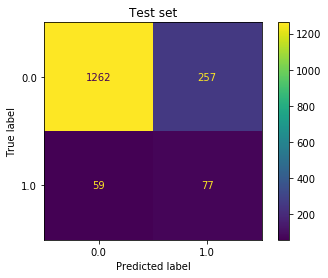

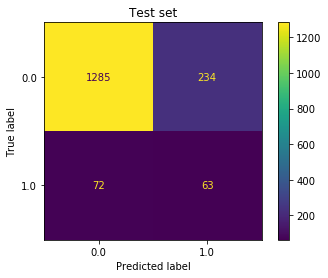

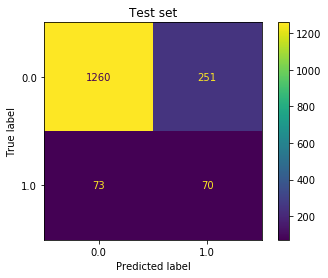

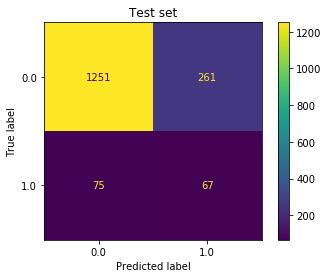

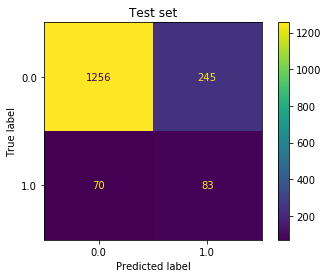

In [137]:
# define X and y

X = binary_df_4.drop(columns = ['HUQ071'])
y = binary_df_4['HUQ071']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)



Classifier: ComplementNB()
Cross-validation folds: 5


ROC-AUC Cross Validation: [0.75568081 0.69811984 0.69081386 0.68594903 0.71326105]
Mean ROC-AUC Score: 0.709


Train mean recall: 0.56 +/- 0.01
Train mean precision: 0.2 +/- 0.0
Train mean F1: 0.29 +/- 0.01


Test mean recall: 0.56 +/- 0.05
Test mean precision: 0.2 +/- 0.02
Test mean F1: 0.3 +/- 0.02


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


weight  abs_weight
heart_fail_binary 4.46110     4.46110
COPD              3.91020     3.91020
insulin_binary    3.86270     3.86270
other_resp_yrs    3.41190     3.41190
other_cond_binary 3.13700     3.13700
rx_one_year_plus  3.02010     3.02010
osteo_yrs         2.94770     2.94770
dm_binary         2.66340     2.66340
RIDRETH3_2.0      2.61850     2.61850
other_arth_yrs    2.57550     2.57550
RIDRETH3_6.0      2.17430     2.17430
asthma_yrs        2.16580     2.16580
RIDRETH3_1.0      2.05020     2.05020
RIDRETH3_4.0      1.64010     1.64010

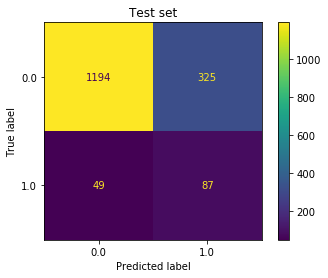

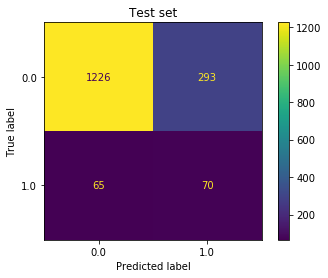

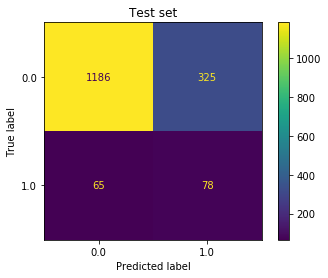

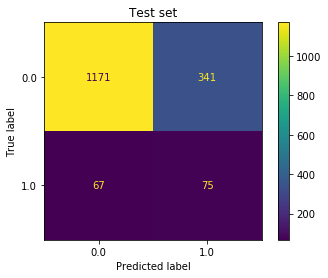

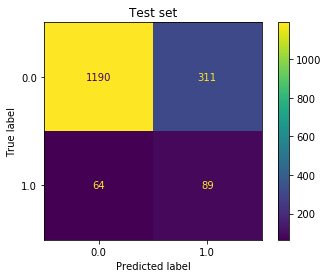

In [138]:
# define X and y

X = binary_df_4.drop(columns = ['HUQ071','RIDRETH3_3.0','RIDAGEYR'])
y = binary_df_4['HUQ071']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)



In [139]:
# get patients who primary diagnosis for at least one drug is unknown

unknown_rx_dx = rxq_rx_j.loc[rxq_rx_j['RXDRSC1'].isin(['99999', '55555'])]
unknown_rx_dx

SEQN  RXDUSE       RXDDRUG RXDDRGID  RXQSEEN     RXDDAYS  \
37     93722.00000 1.00000      FENTANYL   d00233  1.00000   365.00000   
277    93830.00000 1.00000    CILOSTAZOL   d04382  1.00000 14600.00000   
286    93830.00000 1.00000     SEVELAMER   d04363  1.00000   730.00000   
376    93869.00000 1.00000  ATORVASTATIN   d04105  1.00000    61.00000   
377    93869.00000 1.00000    CARVEDILOL   d03847  1.00000    61.00000   
...            ...     ...           ...      ...      ...         ...   
19425 102853.00000 1.00000   CLINDAMYCIN   d00043  1.00000    21.00000   
19521 102897.00000 1.00000       ASPIRIN   d00170  1.00000   547.00000   
19522 102897.00000 1.00000     ENALAPRIL   d00013  1.00000   243.00000   
19568 102921.00000 1.00000      NAPROXEN   d00019  1.00000    61.00000   
19632 102951.00000 1.00000   EPINEPHRINE   d00699  1.00000   730.00000   

      RXDRSC1 RXDRSC2 RXDRSC3 RXDRSD1 RXDRSD2 RXDRSD3  RXDCOUNT  
37      55555                                          10.00000  
277     99999                                          14.00000  
286     55555                                          14.00000  
376     99999                                           6.00000  
377     99999                                           6.00000  
...       ...     ...     ...     ...     ...     ...       ...  
19425   55555                                           4.00000  
19521   55555                                           5.00000  
19522   55555                                           5.00000  
19568   99999                                           6.00000  
19632   55555                                           1.00000  

[535 rows x 13 columns]

In [140]:
unk_rx_dx_unique_pts = unknown_rx_dx['SEQN'].unique()
len(unk_rx_dx_unique_pts)

263

In [141]:
unk_rx_dx_unique_pts = pd.DataFrame(unk_rx_dx_unique_pts)
unk_rx_dx_unique_pts['unknown_dx'] = 1
unk_rx_dx_unique_pts.rename(columns = {0: 'SEQN'}, inplace=True)
unk_rx_dx_unique_pts

SEQN  unknown_dx
0    93722.00000           1
1    93830.00000           1
2    93869.00000           1
3    93887.00000           1
4    93955.00000           1
5    93957.00000           1
6    94059.00000           1
7    94073.00000           1
8    94144.00000           1
9    94154.00000           1
10   94175.00000           1
11   94204.00000           1
12   94229.00000           1
13   94243.00000           1
14   94352.00000           1
15   94402.00000           1
16   94427.00000           1
17   94490.00000           1
18   94535.00000           1
19   94541.00000           1
20   94722.00000           1
21   94750.00000           1
22   94767.00000           1
23   94840.00000           1
24   94847.00000           1
25   94872.00000           1
26   94887.00000           1
27   94993.00000           1
28   95028.00000           1
29   95036.00000           1
30   95068.00000           1
31   95082.00000           1
32   95101.00000           1
33   95111.00000           1
34   95222.00000           1
35   95330.00000           1
36   95334.00000           1
37   95440.00000           1
38   95467.00000           1
39   95469.00000           1
40   95504.00000           1
41   95524.00000           1
42   95527.00000           1
43   95533.00000           1
44   95590.00000           1
45   95600.00000           1
46   95615.00000           1
47   95626.00000           1
48   95641.00000           1
49   95651.00000           1
50   95687.00000           1
51   95717.00000           1
52   95763.00000           1
53   95795.00000           1
54   95828.00000           1
55   95831.00000           1
56   95863.00000           1
57   95866.00000           1
58   96002.00000           1
59   96016.00000           1
60   96027.00000           1
61   96037.00000           1
62   96098.00000           1
63   96140.00000           1
64   96252.00000           1
65   96256.00000           1
66   96265.00000           1
67   96333.00000           1
68   96368.00000           1
69   96375.00000           1
70   96429.00000           1
71   96456.00000           1
72   96491.00000           1
73   96560.00000           1
74   96587.00000           1
75   96595.00000           1
76   96632.00000           1
77   96675.00000           1
78   96683.00000           1
79   96727.00000           1
80   96758.00000           1
81   96775.00000           1
82   96789.00000           1
83   96809.00000           1
84   96834.00000           1
85   96906.00000           1
86   96942.00000           1
87   96955.00000           1
88   97058.00000           1
89   97189.00000           1
90   97233.00000           1
91   97252.00000           1
92   97280.00000           1
93   97324.00000           1
94   97327.00000           1
95   97332.00000           1
96   97357.00000           1
97   97375.00000           1
98   97388.00000           1
99   97447.00000           1
100  97464.00000           1
101  97518.00000           1
102  97536.00000           1
103  97562.00000           1
104  97569.00000           1
105  97590.00000           1
106  97639.00000           1
107  97697.00000           1
108  97713.00000           1
109  97730.00000           1
110  97832.00000           1
111  97863.00000           1
112  97888.00000           1
113  97895.00000           1
114  97902.00000           1
115  97926.00000           1
116  97964.00000           1
117  98024.00000           1
118  98071.00000           1
119  98081.00000           1
120  98082.00000           1
121  98109.00000           1
122  98134.00000           1
123  98173.00000           1
124  98201.00000           1
125  98270.00000           1
126  98287.00000           1
127  98339.00000           1
128  98344.00000           1
129  98366.00000           1
130  98368.00000           1
131  98568.00000           1
132  98599.00000           1
133  98690.00000           1
134  98768.00000           1
135  98814.00000           1
136  98815.00000           1
137  98837

In [142]:
binary_df_5 = binary_df_4.merge(unk_rx_dx_unique_pts, how='left', on='SEQN').fillna(0)
binary_df_5.drop(columns='rx_one_year_plus', inplace=True)
binary_df_5.set_index('SEQN', inplace=True)
binary_df_5

RIDAGEYR  osteo_yrs  other_arth_yrs  heart_fail_binary  \
SEQN                                                                   
93703.00000    2.00000    0.00000         0.00000            0.00000   
93704.00000    2.00000    0.00000         0.00000            0.00000   
93705.00000   66.00000    0.00000         1.00000            0.00000   
93706.00000   18.00000    0.00000         0.00000            0.00000   
93707.00000   13.00000    0.00000         0.00000            0.00000   
...                ...        ...             ...                ...   
102952.00000  70.00000    0.00000         0.00000            0.00000   
102953.00000  42.00000    0.00000         0.00000            0.00000   
102954.00000  41.00000    0.00000         0.00000            0.00000   
102955.00000  14.00000    0.00000         0.00000            0.00000   
102956.00000  38.00000    1.00000         0.00000            0.00000   

              other_cond_binary    COPD  asthma_yrs  other_resp_yrs  \
SEQN                                                                  
93703.00000             0.00000 0.00000     0.00000         0.00000   
93704.00000             0.00000 0.00000     0.00000         0.00000   
93705.00000             0.00000 0.00000     1.00000         0.00000   
93706.00000             0.00000 0.00000     0.00000         0.00000   
93707.00000             0.00000 0.00000     0.00000         0.00000   
...                         ...     ...         ...             ...   
102952.00000            0.00000 0.00000     0.00000         0.00000   
102953.00000            0.00000 0.00000     0.00000         0.00000   
102954.00000            0.00000 0.00000     0.00000         0.00000   
102955.00000            0.00000 0.00000     0.00000         0.00000   
102956.00000            0.00000 0.00000     0.00000         0.00000   

              dm_binary  insulin_binary  HUQ071  RIDRETH3_1.0  RIDRETH3_2.0  \
SEQN                                                                          
93703.00000     0.00000         0.00000 0.00000             0             0   
93704.00000     0.00000         0.00000 0.00000             0             0   
93705.00000     0.00000         0.00000 0.00000             0             0   
93706.00000     0.00000         0.00000 0.00000             0             0   
93707.00000     0.00000         0.00000 0.00000             0             0   
...                 ...             ...     ...           ...           ...   
102952.00000    0.00000         0.00000 0.00000             0             0   
102953.00000    0.00000         0.00000 0.00000             1             0   
102954.00000    0.00000         0.00000 0.00000             0             0   
102955.00000    0.00000         0.00000 0.00000             0             0   
102956.00000    0.00000         0.00000 0.00000             0             0   

              RIDRETH3_3.0  RIDRETH3_4.0  RIDRETH3_6.0  unknown_dx  
SEQN                                                                
93703.00000              0             0             1     0.00000  
93704.00000              1             0             0     0.00000  
93705.00000              0             1             0     0.00000  
93706.00000              0             0             1     0.00000  
93707.00000              0             0             0     0.00000  
...                    ...           ...           ...         ...  
102952.00000             0             0             1     0.00000  
102953.00000             0             0             0     0.00000  
102954.00000             0             1             0     0.00000  
102955.00000             0             1             0     0.00000  
102956.00000             1             0             0     0.00000  

[8894 rows x 17 columns]

Classifier: ComplementNB()
Cross-validation folds: 5


ROC-AUC Cross Validation: [0.75690029 0.69233546 0.68503614 0.67513647 0.70789319]
Mean ROC-AUC Score: 0.703


Train mean recall: 0.52 +/- 0.01
Train mean precision: 0.23 +/- 0.0
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.51 +/- 0.05
Test mean precision: 0.23 +/- 0.02
Test mean F1: 0.32 +/- 0.03


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


weight  abs_weight
heart_fail_binary 4.93330     4.93330
unknown_dx        4.40340     4.40340
COPD              4.38240     4.38240
insulin_binary    4.33490     4.33490
other_resp_yrs    3.88410     3.88410
other_cond_binary 3.60920     3.60920
osteo_yrs         3.41990     3.41990
dm_binary         3.13560     3.13560
RIDRETH3_2.0      3.09070     3.09070
other_arth_yrs    3.04770     3.04770
RIDRETH3_6.0      2.64650     2.64650
asthma_yrs        2.63800     2.63800
RIDRETH3_1.0      2.52240     2.52240
RIDRETH3_4.0      2.11220     2.11220
RIDRETH3_3.0      1.74780     1.74780
RIDAGEYR          1.51230     1.51230

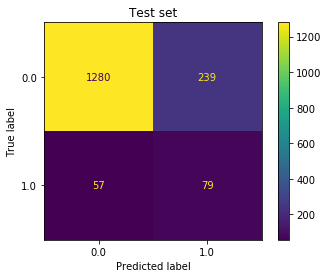

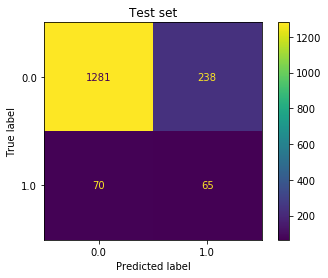

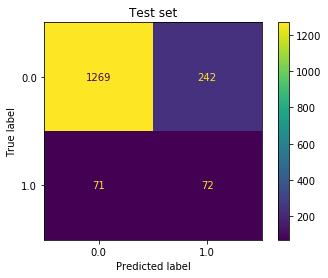

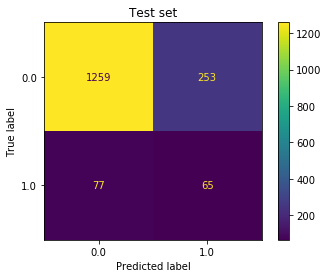

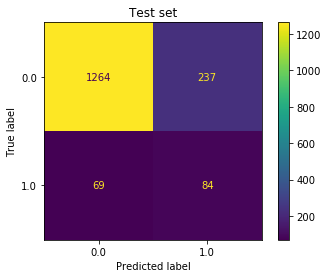

In [143]:
# define X and y

X = binary_df_5.drop(columns = ['HUQ071'])
y = binary_df_5['HUQ071']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)



In [144]:
age_to_plot = binary_df_5[['RIDAGEYR','HUQ071']]
age_to_plot

RIDAGEYR  HUQ071
SEQN                          
93703.00000    2.00000 0.00000
93704.00000    2.00000 0.00000
93705.00000   66.00000 0.00000
93706.00000   18.00000 0.00000
93707.00000   13.00000 0.00000
...                ...     ...
102952.00000  70.00000 0.00000
102953.00000  42.00000 0.00000
102954.00000  41.00000 0.00000
102955.00000  14.00000 0.00000
102956.00000  38.00000 0.00000

[8894 rows x 2 columns]

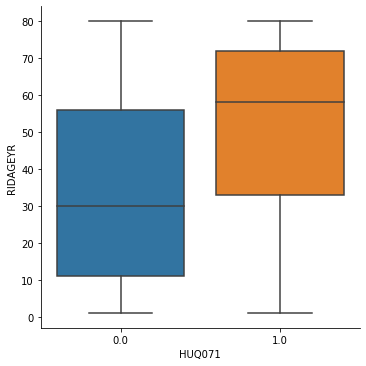

In [145]:
sns.catplot(x="HUQ071", y="RIDAGEYR", data=binary_df_5, kind='box')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 88.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


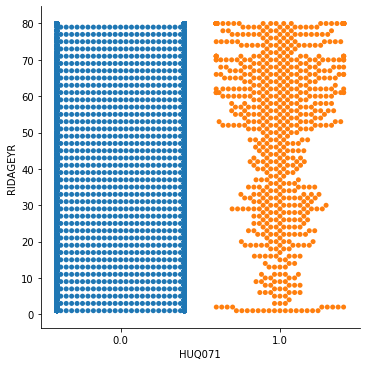

In [146]:
sns.catplot(x="HUQ071", y="RIDAGEYR", data=binary_df_5, kind='swarm')

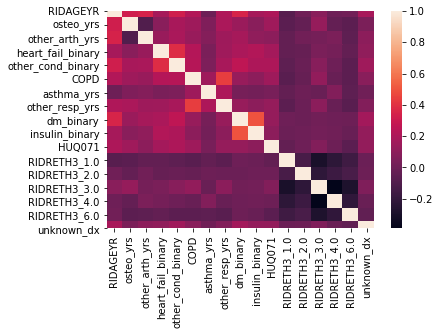

In [147]:
corr = binary_df_5.corr()
sns.heatmap(corr)

# no strong correlations
# even diabetes and taking insulin is only 50% correlated
# nothing is strongly correlated with hospitalization (HUQ071)

In [148]:
# engineer age
age

SEQN  RIDAGEYR
0     93703.00000   2.00000
1     93704.00000   2.00000
2     93705.00000  66.00000
3     93706.00000  18.00000
4     93707.00000  13.00000
...           ...       ...
9249 102952.00000  70.00000
9250 102953.00000  42.00000
9251 102954.00000  41.00000
9252 102955.00000  14.00000
9253 102956.00000  38.00000

[9254 rows x 2 columns]

In [149]:
age['agemap'] = age['RIDAGEYR'].map(lambda x: '0-5' if x < 5
                                    else '6-17' if x < 17
                                   else '18-49' if x < 50
                                    else '50-59' if x < 60
                                    else '60-69' if x < 70
                                   else '70+')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [150]:
age

SEQN  RIDAGEYR agemap
0     93703.00000   2.00000    0-5
1     93704.00000   2.00000    0-5
2     93705.00000  66.00000  60-69
3     93706.00000  18.00000  18-49
4     93707.00000  13.00000   6-17
...           ...       ...    ...
9249 102952.00000  70.00000    70+
9250 102953.00000  42.00000  18-49
9251 102954.00000  41.00000  18-49
9252 102955.00000  14.00000   6-17
9253 102956.00000  38.00000  18-49

[9254 rows x 3 columns]

In [151]:
age_buckets = pd.get_dummies(age['agemap'])
age_buckets

0-5  18-49  50-59  6-17  60-69  70+
0       1      0      0     0      0    0
1       1      0      0     0      0    0
2       0      0      0     0      1    0
3       0      1      0     0      0    0
4       0      0      0     1      0    0
...   ...    ...    ...   ...    ...  ...
9249    0      0      0     0      0    1
9250    0      1      0     0      0    0
9251    0      1      0     0      0    0
9252    0      0      0     1      0    0
9253    0      1      0     0      0    0

[9254 rows x 6 columns]

In [152]:
age_2 = age.join(age_buckets).drop(columns = ['6-17'])
age_2

SEQN  RIDAGEYR agemap  0-5  18-49  50-59  60-69  70+
0     93703.00000   2.00000    0-5    1      0      0      0    0
1     93704.00000   2.00000    0-5    1      0      0      0    0
2     93705.00000  66.00000  60-69    0      0      0      1    0
3     93706.00000  18.00000  18-49    0      1      0      0    0
4     93707.00000  13.00000   6-17    0      0      0      0    0
...           ...       ...    ...  ...    ...    ...    ...  ...
9249 102952.00000  70.00000    70+    0      0      0      0    1
9250 102953.00000  42.00000  18-49    0      1      0      0    0
9251 102954.00000  41.00000  18-49    0      1      0      0    0
9252 102955.00000  14.00000   6-17    0      0      0      0    0
9253 102956.00000  38.00000  18-49    0      1      0      0    0

[9254 rows x 8 columns]

In [153]:
# childbirth - exclude 70 ppl who had babies in the past 12 months? RHQ197 - How many months ago have baby?

babies_this_year = rhq_j[['SEQN', 'RHQ197']]
babies_this_year = babies_this_year.loc[~babies_this_year['RHQ197'].isna()]
babies_this_year

SEQN   RHQ197
66    93883.00000  2.00000
67    93888.00000 12.00000
103   93988.00000 23.00000
115   94012.00000 10.00000
137   94061.00000  9.00000
164   94135.00000  9.00000
175   94160.00000  4.00000
209   94250.00000 16.00000
217   94277.00000  4.00000
218   94281.00000  1.00000
231   94302.00000 17.00000
250   94379.00000 10.00000
256   94388.00000 22.00000
267   94416.00000 17.00000
279   94446.00000  5.00000
289   94469.00000 19.00000
290   94471.00000 24.00000
318   94532.00000  9.00000
365   94660.00000  5.00000
366   94663.00000 17.00000
368   94672.00000  9.00000
369   94673.00000 18.00000
421   94819.00000  6.00000
436   94848.00000  3.00000
442   94860.00000  3.00000
449   94889.00000 20.00000
473   94936.00000  5.00000
511   95052.00000 23.00000
549   95153.00000  5.00000
586   95232.00000 13.00000
600   95262.00000 21.00000
654   95422.00000 20.00000
673   95486.00000 14.00000
701   95574.00000  9.00000
752   95726.00000  3.00000
770   95778.00000 18.00000
774   95793.00000  1.00000
777   95807.00000 23.00000
801   95870.00000 12.00000
816   95911.00000 12.00000
835   95973.00000 12.00000
840   95990.00000 11.00000
914   96222.00000 21.00000
943   96297.00000  2.00000
948   96312.00000 23.00000
952   96322.00000 13.00000
953   96325.00000  8.00000
961   96355.00000  8.00000
993   96433.00000 10.00000
1005  96466.00000 14.00000
1009  96474.00000 16.00000
1054  96610.00000 12.00000
1100  96756.00000 23.00000
1118  96811.00000 10.00000
1135  96865.00000 20.00000
1165  96958.00000  4.00000
1169  96966.00000 20.00000
1181  97011.00000 12.00000
1205  97071.00000  7.00000
1218  97103.00000 16.00000
1226  97122.00000  9.00000
1283  97257.00000 18.00000
1298  97293.00000  3.00000
1301  97304.00000 22.00000
1305  97314.00000 17.00000
1319  97349.00000 12.00000
1349  97451.00000 13.00000
1353  97458.00000  9.00000
1356  97469.00000 19.00000
1360  97485.00000  6.00000
1404  97620.00000 20.00000
1425  97671.00000 19.00000
1439  97709.00000  3.00000
1474  97795.00000 14.00000
1478  97811.00000  4.00000
1485  97841.00000 15.00000
1487  97848.00000 17.00000
1520  97948.00000  1.00000
1525  97958.00000  8.00000
1553  98030.00000 15.00000
1566  98065.00000 19.00000
1581  98113.00000  1.00000
1584  98120.00000 14.00000
1680  98395.00000 21.00000
1716  98483.00000 13.00000
1757  98579.00000 18.00000
1780  98646.00000 12.00000
1790  98687.00000  3.00000
1822  98784.00000  7.00000
1827  98796.00000 20.00000
1847  98839.00000 18.00000
1881  98958.00000  1.00000
1887  98971.00000  1.00000
1900  99005.00000 12.00000
1939  99121.00000  7.00000
1965  99197.00000  4.00000
2045  99404.00000 20.00000
2063  99446.00000  2.00000
2066  99453.00000  7.00000
2076  99481.00000 22.00000
2094  99525.00000 13.00000
2196  99848.00000 16.00000
2198  99852.00000 16.00000
2204  99871.00000 16.00000
2212  99887.00000 10.00000
2270 100025.00000 20.00000
2284 100068.00000  8.00000
2316 100160.00000  5.00000
2345 100241.00000 20.00000
2360 100269.00000  5.00000
2365 100280.00000 12.00000
2370 100288.00000 15.00000
2449 100526.00000 22.00000
2470 100589.00000 11.00000
2481 100644.00000 14.00000
2488 100672.00000  8.00000
2490 100675.00000  2.00000
2543 100832.00000 24.00000
2549 100855.00000  2.00000
2562 100896.00000  1.00000
2606 101009.00000 12.00000
2625 101076.00000  3.00000
2638 101099.00000  2.00000
2674 101191.00000  2.00000
2698 101252.00000  8.00000
2734 101345.00000  1.00000
2821 101588.00000  1.00000
2845 101669.00000 21.00000
2866 101709.00000 18.00000
2872 101733.00000 16.00000
2888 101790.00000 15.00000
2926 101885.00000 20.00000
2931 101901.00000 17.00000
2966 102015.00000  3.00000
2977 102046.00000 15.00000
2988 102064.00000  7.00000
2996 102088.00000 16.00000
2997 102093.00000 11.00000
2998 102099.00000 19.00000
3001 102105.00000  5.00000
3002 102112.00000  2.00000
3086 102348.00000  2.00000
3094 102369.00000 20.00000
3097 102378.00000 16.00000
3099 102380.00000  1.00000
3100 102383.00000 19.00000
3126 102460.00000 13.00000
3159 102589.00000

In [154]:
# join target
babies_target = babies_this_year.merge(target, how='left', on='SEQN')
babies_target

# most people who had babies within past 12 months are marked as 1 - had a hospital stay
# not all are, possibly due to differences in how ppl responded to the question?

SEQN   RHQ197  HUQ071
0    93883.00000  2.00000 1.00000
1    93888.00000 12.00000 0.00000
2    93988.00000 23.00000 0.00000
3    94012.00000 10.00000 0.00000
4    94061.00000  9.00000 1.00000
5    94135.00000  9.00000 1.00000
6    94160.00000  4.00000 1.00000
7    94250.00000 16.00000 0.00000
8    94277.00000  4.00000 0.00000
9    94281.00000  1.00000 1.00000
10   94302.00000 17.00000 0.00000
11   94379.00000 10.00000 0.00000
12   94388.00000 22.00000 0.00000
13   94416.00000 17.00000 0.00000
14   94446.00000  5.00000 1.00000
15   94469.00000 19.00000 0.00000
16   94471.00000 24.00000 0.00000
17   94532.00000  9.00000 0.00000
18   94660.00000  5.00000 1.00000
19   94663.00000 17.00000 0.00000
20   94672.00000  9.00000 1.00000
21   94673.00000 18.00000 0.00000
22   94819.00000  6.00000 1.00000
23   94848.00000  3.00000 1.00000
24   94860.00000  3.00000 1.00000
25   94889.00000 20.00000 0.00000
26   94936.00000  5.00000 1.00000
27   95052.00000 23.00000 0.00000
28   95153.00000  5.00000 1.00000
29   95232.00000 13.00000 0.00000
30   95262.00000 21.00000 0.00000
31   95422.00000 20.00000 0.00000
32   95486.00000 14.00000 0.00000
33   95574.00000  9.00000 1.00000
34   95726.00000  3.00000 1.00000
35   95778.00000 18.00000 0.00000
36   95793.00000  1.00000 0.00000
37   95807.00000 23.00000 0.00000
38   95870.00000 12.00000 0.00000
39   95911.00000 12.00000 0.00000
40   95973.00000 12.00000 0.00000
41   95990.00000 11.00000 1.00000
42   96222.00000 21.00000 0.00000
43   96297.00000  2.00000 1.00000
44   96312.00000 23.00000 0.00000
45   96322.00000 13.00000 0.00000
46   96325.00000  8.00000 1.00000
47   96355.00000  8.00000 1.00000
48   96433.00000 10.00000 0.00000
49   96466.00000 14.00000 0.00000
50   96474.00000 16.00000 0.00000
51   96610.00000 12.00000 0.00000
52   96756.00000 23.00000 0.00000
53   96811.00000 10.00000 0.00000
54   96865.00000 20.00000 1.00000
55   96958.00000  4.00000 1.00000
56   96966.00000 20.00000 0.00000
57   97011.00000 12.00000 0.00000
58   97071.00000  7.00000 0.00000
59   97103.00000 16.00000 0.00000
60   97122.00000  9.00000 1.00000
61   97257.00000 18.00000 0.00000
62   97293.00000  3.00000 1.00000
63   97304.00000 22.00000 1.00000
64   97314.00000 17.00000 1.00000
65   97349.00000 12.00000 1.00000
66   97451.00000 13.00000 1.00000
67   97458.00000  9.00000 1.00000
68   97469.00000 19.00000 0.00000
69   97485.00000  6.00000 1.00000
70   97620.00000 20.00000 0.00000
71   97671.00000 19.00000 0.00000
72   97709.00000  3.00000 1.00000
73   97795.00000 14.00000 0.00000
74   97811.00000  4.00000 1.00000
75   97841.00000 15.00000 0.00000
76   97848.00000 17.00000 0.00000
77   97948.00000  1.00000 1.00000
78   97958.00000  8.00000 0.00000
79   98030.00000 15.00000 0.00000
80   98065.00000 19.00000 0.00000
81   98113.00000  1.00000 1.00000
82   98120.00000 14.00000 0.00000
83   98395.00000 21.00000 0.00000
84   98483.00000 13.00000 0.00000
85   98579.00000 18.00000 0.00000
86   98646.00000 12.00000 0.00000
87   98687.00000  3.00000 1.00000
88   98784.00000  7.00000 1.00000
89   98796.00000 20.00000 0.00000
90   98839.00000 18.00000 0.00000
91   98958.00000  1.00000 1.00000
92   98971.00000  1.00000 1.00000
93   99005.00000 12.00000 1.00000
94   99121.00000  7.00000 1.00000
95   99197.00000  4.00000 1.00000
96   99404.00000 20.00000 0.00000
97   99446.00000  2.00000 1.00000
98   99453.00000  7.00000 1.00000
99   99481.00000 22.00000 0.00000
100  99525.00000 13.00000 0.00000
101  99848.00000 16.00000 0.00000
102  99852.00000 16.00000 0.00000
103  99871.00000 16.00000 0.00000
104  99887.00000 10.00000 1.00000
105 100025.00000 20.00000 1.00000
106 100068.00000  8.00000 1.00000
107 100160.00000  5.00000 1.00000
108 100241.00000 20.00000 0.00000
109 100269.00000  5.00000 1.00000
110 100280.00000 12.00000 0.00000
111 100288.00000 15.00000 1.00000
112 100526.00000 22.00000 0.00000
113 100589.00000 11.00000 1.00000
114 100644.00000 14.00000 0.00000
115 100672.00000  8.00000 1.00000
116 100675.00000  2.00000 1.00000


In [155]:
# how many in this group were hospitalized?

babies_target['HUQ071'].sum()

61.0

In [156]:
babies_target_2 = babies_target.merge(huq_j[['SEQN', 'HUD080']], how='left', on='SEQN')
babies_target_2.fillna(0, inplace=True)

# some ppl who delivered babies were in the hospital more than once

babies_target_2['non_birth_hosp'] = babies_target_2['HUD080']
babies_target_2

SEQN   RHQ197  HUQ071  HUD080  non_birth_hosp
0    93883.00000  2.00000 1.00000 6.00000         6.00000
1    93888.00000 12.00000 0.00000 0.00000         0.00000
2    93988.00000 23.00000 0.00000 0.00000         0.00000
3    94012.00000 10.00000 0.00000 0.00000         0.00000
4    94061.00000  9.00000 1.00000 1.00000         1.00000
5    94135.00000  9.00000 1.00000 1.00000         1.00000
6    94160.00000  4.00000 1.00000 2.00000         2.00000
7    94250.00000 16.00000 0.00000 0.00000         0.00000
8    94277.00000  4.00000 0.00000 0.00000         0.00000
9    94281.00000  1.00000 1.00000 1.00000         1.00000
10   94302.00000 17.00000 0.00000 0.00000         0.00000
11   94379.00000 10.00000 0.00000 0.00000         0.00000
12   94388.00000 22.00000 0.00000 0.00000         0.00000
13   94416.00000 17.00000 0.00000 0.00000         0.00000
14   94446.00000  5.00000 1.00000 2.00000         2.00000
15   94469.00000 19.00000 0.00000 0.00000         0.00000
16   94471.00000 24.00000 0.00000 0.00000         0.00000
17   94532.00000  9.00000 0.00000 0.00000         0.00000
18   94660.00000  5.00000 1.00000 2.00000         2.00000
19   94663.00000 17.00000 0.00000 0.00000         0.00000
20   94672.00000  9.00000 1.00000 1.00000         1.00000
21   94673.00000 18.00000 0.00000 0.00000         0.00000
22   94819.00000  6.00000 1.00000 1.00000         1.00000
23   94848.00000  3.00000 1.00000 2.00000         2.00000
24   94860.00000  3.00000 1.00000 1.00000         1.00000
25   94889.00000 20.00000 0.00000 0.00000         0.00000
26   94936.00000  5.00000 1.00000 1.00000         1.00000
27   95052.00000 23.00000 0.00000 0.00000         0.00000
28   95153.00000  5.00000 1.00000 1.00000         1.00000
29   95232.00000 13.00000 0.00000 0.00000         0.00000
30   95262.00000 21.00000 0.00000 0.00000         0.00000
31   95422.00000 20.00000 0.00000 0.00000         0.00000
32   95486.00000 14.00000 0.00000 0.00000         0.00000
33   95574.00000  9.00000 1.00000 1.00000         1.00000
34   95726.00000  3.00000 1.00000 1.00000         1.00000
35   95778.00000 18.00000 0.00000 0.00000         0.00000
36   95793.00000  1.00000 0.00000 0.00000         0.00000
37   95807.00000 23.00000 0.00000 0.00000         0.00000
38   95870.00000 12.00000 0.00000 0.00000         0.00000
39   95911.00000 12.00000 0.00000 0.00000         0.00000
40   95973.00000 12.00000 0.00000 0.00000         0.00000
41   95990.00000 11.00000 1.00000 1.00000         1.00000
42   96222.00000 21.00000 0.00000 0.00000         0.00000
43   96297.00000  2.00000 1.00000 1.00000         1.00000
44   96312.00000 23.00000 0.00000 0.00000         0.00000
45   96322.00000 13.00000 0.00000 0.00000         0.00000
46   96325.00000  8.00000 1.00000 1.00000         1.00000
47   96355.00000  8.00000 1.00000 3.00000         3.00000
48   96433.00000 10.00000 0.00000 0.00000         0.00000
49   96466.00000 14.00000 0.00000 0.00000         0.00000
50   96474.00000 16.00000 0.00000 0.00000         0.00000
51   96610.00000 12.00000 0.00000 0.00000         0.00000
52   96756.00000 23.00000 0.00000 0.00000         0.00000
53   96811.00000 10.00000 0.00000 0.00000         0.00000
54   96865.00000 20.00000 1.00000 1.00000         1.00000
55   96958.00000  4.00000 1.00000 1.00000         1.00000
56   96966.00000 20.00000 0.00000 0.00000         0.00000
57   97011.00000 12.00000 0.00000 0.00000         0.00000
58   97071.00000  7.00000 0.00000 0.00000         0.00000
59   97103.00000 16.00000 0.00000 0.00000         0.00000
60   97122.00000  9.00000 1.00000 1.00000         1.00000
61   97257.00000 18.00000 0.00000 0.00000         0.00000
62   97293.00000  3.00000 1.00000 1.00000         1.00000
63   97304.00000 22.00000 1.00000 1.00000         1.00000
64   97314.00000 17.00000 1.00000 1.00000         1.00000
65   97349.00000 12.00000 1.00000 1.00000         1.00000
66   97451.00000 13.00000 1.00000 1.00000         1.00000
67   97458.00000  9.00000 1.00000 1.00000         1.00000
68   97469

In [157]:
# remove one hospitalization from the count for child birth

babies_target_3 = babies_target_2.copy()
babies_target_3.loc[(babies_target_3['RHQ197'] <= 12) &
                    (babies_target_3['HUQ071'] != 0), 
                    'non_birth_hosp'] = babies_target_3['HUD080'] - 1
babies_target_3

SEQN   RHQ197  HUQ071  HUD080  non_birth_hosp
0    93883.00000  2.00000 1.00000 6.00000         5.00000
1    93888.00000 12.00000 0.00000 0.00000         0.00000
2    93988.00000 23.00000 0.00000 0.00000         0.00000
3    94012.00000 10.00000 0.00000 0.00000         0.00000
4    94061.00000  9.00000 1.00000 1.00000         0.00000
5    94135.00000  9.00000 1.00000 1.00000         0.00000
6    94160.00000  4.00000 1.00000 2.00000         1.00000
7    94250.00000 16.00000 0.00000 0.00000         0.00000
8    94277.00000  4.00000 0.00000 0.00000         0.00000
9    94281.00000  1.00000 1.00000 1.00000         0.00000
10   94302.00000 17.00000 0.00000 0.00000         0.00000
11   94379.00000 10.00000 0.00000 0.00000         0.00000
12   94388.00000 22.00000 0.00000 0.00000         0.00000
13   94416.00000 17.00000 0.00000 0.00000         0.00000
14   94446.00000  5.00000 1.00000 2.00000         1.00000
15   94469.00000 19.00000 0.00000 0.00000         0.00000
16   94471.00000 24.00000 0.00000 0.00000         0.00000
17   94532.00000  9.00000 0.00000 0.00000         0.00000
18   94660.00000  5.00000 1.00000 2.00000         1.00000
19   94663.00000 17.00000 0.00000 0.00000         0.00000
20   94672.00000  9.00000 1.00000 1.00000         0.00000
21   94673.00000 18.00000 0.00000 0.00000         0.00000
22   94819.00000  6.00000 1.00000 1.00000         0.00000
23   94848.00000  3.00000 1.00000 2.00000         1.00000
24   94860.00000  3.00000 1.00000 1.00000         0.00000
25   94889.00000 20.00000 0.00000 0.00000         0.00000
26   94936.00000  5.00000 1.00000 1.00000         0.00000
27   95052.00000 23.00000 0.00000 0.00000         0.00000
28   95153.00000  5.00000 1.00000 1.00000         0.00000
29   95232.00000 13.00000 0.00000 0.00000         0.00000
30   95262.00000 21.00000 0.00000 0.00000         0.00000
31   95422.00000 20.00000 0.00000 0.00000         0.00000
32   95486.00000 14.00000 0.00000 0.00000         0.00000
33   95574.00000  9.00000 1.00000 1.00000         0.00000
34   95726.00000  3.00000 1.00000 1.00000         0.00000
35   95778.00000 18.00000 0.00000 0.00000         0.00000
36   95793.00000  1.00000 0.00000 0.00000         0.00000
37   95807.00000 23.00000 0.00000 0.00000         0.00000
38   95870.00000 12.00000 0.00000 0.00000         0.00000
39   95911.00000 12.00000 0.00000 0.00000         0.00000
40   95973.00000 12.00000 0.00000 0.00000         0.00000
41   95990.00000 11.00000 1.00000 1.00000         0.00000
42   96222.00000 21.00000 0.00000 0.00000         0.00000
43   96297.00000  2.00000 1.00000 1.00000         0.00000
44   96312.00000 23.00000 0.00000 0.00000         0.00000
45   96322.00000 13.00000 0.00000 0.00000         0.00000
46   96325.00000  8.00000 1.00000 1.00000         0.00000
47   96355.00000  8.00000 1.00000 3.00000         2.00000
48   96433.00000 10.00000 0.00000 0.00000         0.00000
49   96466.00000 14.00000 0.00000 0.00000         0.00000
50   96474.00000 16.00000 0.00000 0.00000         0.00000
51   96610.00000 12.00000 0.00000 0.00000         0.00000
52   96756.00000 23.00000 0.00000 0.00000         0.00000
53   96811.00000 10.00000 0.00000 0.00000         0.00000
54   96865.00000 20.00000 1.00000 1.00000         1.00000
55   96958.00000  4.00000 1.00000 1.00000         0.00000
56   96966.00000 20.00000 0.00000 0.00000         0.00000
57   97011.00000 12.00000 0.00000 0.00000         0.00000
58   97071.00000  7.00000 0.00000 0.00000         0.00000
59   97103.00000 16.00000 0.00000 0.00000         0.00000
60   97122.00000  9.00000 1.00000 1.00000         0.00000
61   97257.00000 18.00000 0.00000 0.00000         0.00000
62   97293.00000  3.00000 1.00000 1.00000         0.00000
63   97304.00000 22.00000 1.00000 1.00000         1.00000
64   97314.00000 17.00000 1.00000 1.00000         1.00000
65   97349.00000 12.00000 1.00000 1.00000         0.00000
66   97451.00000 13.00000 1.00000 1.00000         1.00000
67   97458.00000  9.00000 1.00000 1.00000         0.00000
68   97469

In [158]:
babies_target_3['non_birth_hosp_binary'] = np.where(babies_target_3['non_birth_hosp'] > 0, 1, 0)
babies_target_3

SEQN   RHQ197  HUQ071  HUD080  non_birth_hosp  \
0    93883.00000  2.00000 1.00000 6.00000         5.00000   
1    93888.00000 12.00000 0.00000 0.00000         0.00000   
2    93988.00000 23.00000 0.00000 0.00000         0.00000   
3    94012.00000 10.00000 0.00000 0.00000         0.00000   
4    94061.00000  9.00000 1.00000 1.00000         0.00000   
5    94135.00000  9.00000 1.00000 1.00000         0.00000   
6    94160.00000  4.00000 1.00000 2.00000         1.00000   
7    94250.00000 16.00000 0.00000 0.00000         0.00000   
8    94277.00000  4.00000 0.00000 0.00000         0.00000   
9    94281.00000  1.00000 1.00000 1.00000         0.00000   
10   94302.00000 17.00000 0.00000 0.00000         0.00000   
11   94379.00000 10.00000 0.00000 0.00000         0.00000   
12   94388.00000 22.00000 0.00000 0.00000         0.00000   
13   94416.00000 17.00000 0.00000 0.00000         0.00000   
14   94446.00000  5.00000 1.00000 2.00000         1.00000   
15   94469.00000 19.00000 0.00000 0.00000         0.00000   
16   94471.00000 24.00000 0.00000 0.00000         0.00000   
17   94532.00000  9.00000 0.00000 0.00000         0.00000   
18   94660.00000  5.00000 1.00000 2.00000         1.00000   
19   94663.00000 17.00000 0.00000 0.00000         0.00000   
20   94672.00000  9.00000 1.00000 1.00000         0.00000   
21   94673.00000 18.00000 0.00000 0.00000         0.00000   
22   94819.00000  6.00000 1.00000 1.00000         0.00000   
23   94848.00000  3.00000 1.00000 2.00000         1.00000   
24   94860.00000  3.00000 1.00000 1.00000         0.00000   
25   94889.00000 20.00000 0.00000 0.00000         0.00000   
26   94936.00000  5.00000 1.00000 1.00000         0.00000   
27   95052.00000 23.00000 0.00000 0.00000         0.00000   
28   95153.00000  5.00000 1.00000 1.00000         0.00000   
29   95232.00000 13.00000 0.00000 0.00000         0.00000   
30   95262.00000 21.00000 0.00000 0.00000         0.00000   
31   95422.00000 20.00000 0.00000 0.00000         0.00000   
32   95486.00000 14.00000 0.00000 0.00000         0.00000   
33   95574.00000  9.00000 1.00000 1.00000         0.00000   
34   95726.00000  3.00000 1.00000 1.00000         0.00000   
35   95778.00000 18.00000 0.00000 0.00000         0.00000   
36   95793.00000  1.00000 0.00000 0.00000         0.00000   
37   95807.00000 23.00000 0.00000 0.00000         0.00000   
38   95870.00000 12.00000 0.00000 0.00000         0.00000   
39   95911.00000 12.00000 0.00000 0.00000         0.00000   
40   95973.00000 12.00000 0.00000 0.00000         0.00000   
41   95990.00000 11.00000 1.00000 1.00000         0.00000   
42   96222.00000 21.00000 0.00000 0.00000         0.00000   
43   96297.00000  2.00000 1.00000 1.00000         0.00000   
44   96312.00000 23.00000 0.00000 0.00000         0.00000   
45   96322.00000 13.00000 0.00000 0.00000         0.00000   
46   96325.00000  8.00000 1.00000 1.00000         0.00000   
47   96355.00000  8.00000 1.00000 3.00000         2.00000   
48   96433.00000 10.00000 0.00000 0.00000         0.00000   
49   96466.00000 14.00000 0.00000 0.00000         0.00000   
50   96474.00000 16.00000 0.00000 0.00000         0.00000   
51   96610.00000 12.00000 0.00000 0.00000         0.00000   
52   96756.00000 23.00000 0.00000 0.00000         0.00000   
53   96811.00000 10.00000 0.00000 0.00000         0.00000   
54   96865.00000 20.00000 1.00000 1.00000         1.00000   
55   96958.00000  4.00000 1.00000 1.00000         0.00000   
56   96966.00000 20.00000 0.00000 0.00000         0.00000   
57   97011.00000 12.00000 0.00000 0.00000         0.00000   
58   97071.00000  7.00000 0.00000 0.00000         0.00000   
59   97103.00000 16.00000 0.00000 0.00000         0.00000   
60   97122.00000  9.00000 1.00000 1.00000         0.00000   
61   97257.00000 18.00000 0.00000 0.00000         0.00000   
62   97293.00000  3.00000 1.00000 1.00000         0.00000   
63   97304.00000 22.00000 1.00000 1.00000         1.00000   
64   97314.00000 17.00000 1.00000 1.00000      

In [159]:
# how many in this group were hospitalized?
babies_target_3['non_birth_hosp_binary'].sum()

16

In [160]:
babies_target_final = babies_target_3[['SEQN', 'non_birth_hosp_binary']]
babies_target_final

SEQN  non_birth_hosp_binary
0    93883.00000                      1
1    93888.00000                      0
2    93988.00000                      0
3    94012.00000                      0
4    94061.00000                      0
5    94135.00000                      0
6    94160.00000                      1
7    94250.00000                      0
8    94277.00000                      0
9    94281.00000                      0
10   94302.00000                      0
11   94379.00000                      0
12   94388.00000                      0
13   94416.00000                      0
14   94446.00000                      1
15   94469.00000                      0
16   94471.00000                      0
17   94532.00000                      0
18   94660.00000                      1
19   94663.00000                      0
20   94672.00000                      0
21   94673.00000                      0
22   94819.00000                      0
23   94848.00000                      1
24   94860.00000                      0
25   94889.00000                      0
26   94936.00000                      0
27   95052.00000                      0
28   95153.00000                      0
29   95232.00000                      0
30   95262.00000                      0
31   95422.00000                      0
32   95486.00000                      0
33   95574.00000                      0
34   95726.00000                      0
35   95778.00000                      0
36   95793.00000                      0
37   95807.00000                      0
38   95870.00000                      0
39   95911.00000                      0
40   95973.00000                      0
41   95990.00000                      0
42   96222.00000                      0
43   96297.00000                      0
44   96312.00000                      0
45   96322.00000                      0
46   96325.00000                      0
47   96355.00000                      1
48   96433.00000                      0
49   96466.00000                      0
50   96474.00000                      0
51   96610.00000                      0
52   96756.00000                      0
53   96811.00000                      0
54   96865.00000                      1
55   96958.00000                      0
56   96966.00000                      0
57   97011.00000                      0
58   97071.00000                      0
59   97103.00000                      0
60   97122.00000                      0
61   97257.00000                      0
62   97293.00000                      0
63   97304.00000                      1
64   97314.00000                      1
65   97349.00000                      0
66   97451.00000                      1
67   97458.00000                      0
68   97469.00000                      0
69   97485.00000                      0
70   97620.00000                      0
71   97671.00000                      0
72   97709.00000                      0
73   97795.00000                      0
74   97811.00000                      0
75   97841.00000                      0
76   97848.00000                      0
77   97948.00000                      0
78   97958.00000                      0
79   98030.00000                      0
80   98065.00000                      0
81   98113.00000                      0
82   98120.00000                      0
83   98395.00000                      0
84   98483.00000                      0
85   98579.00000                      0
86   98646.00000                      0
87   98687.00000                      0
88   98784.00000                      0
89   98796.00000                      0
90   98839.00000                      0
91   98958.00000                      0
92   98971.00000                      0
93   99005.00000                      0
94   99121.00000                      0
95   99197.00000                      0
96   99404.00000                      0
97   99446.00000                      0
98   99453.00000                      0
99   99481.0

In [161]:
binary_df_6 = binary_df_5.merge(babies_target_final, how='left', on='SEQN')
binary_df_6

SEQN  RIDAGEYR  osteo_yrs  other_arth_yrs  heart_fail_binary  \
0     93703.00000   2.00000    0.00000         0.00000            0.00000   
1     93704.00000   2.00000    0.00000         0.00000            0.00000   
2     93705.00000  66.00000    0.00000         1.00000            0.00000   
3     93706.00000  18.00000    0.00000         0.00000            0.00000   
4     93707.00000  13.00000    0.00000         0.00000            0.00000   
...           ...       ...        ...             ...                ...   
8889 102952.00000  70.00000    0.00000         0.00000            0.00000   
8890 102953.00000  42.00000    0.00000         0.00000            0.00000   
8891 102954.00000  41.00000    0.00000         0.00000            0.00000   
8892 102955.00000  14.00000    0.00000         0.00000            0.00000   
8893 102956.00000  38.00000    1.00000         0.00000            0.00000   

      other_cond_binary    COPD  asthma_yrs  other_resp_yrs  dm_binary  \
0               0.00000 0.00000     0.00000         0.00000    0.00000   
1               0.00000 0.00000     0.00000         0.00000    0.00000   
2               0.00000 0.00000     1.00000         0.00000    0.00000   
3               0.00000 0.00000     0.00000         0.00000    0.00000   
4               0.00000 0.00000     0.00000         0.00000    0.00000   
...                 ...     ...         ...             ...        ...   
8889            0.00000 0.00000     0.00000         0.00000    0.00000   
8890            0.00000 0.00000     0.00000         0.00000    0.00000   
8891            0.00000 0.00000     0.00000         0.00000    0.00000   
8892            0.00000 0.00000     0.00000         0.00000    0.00000   
8893            0.00000 0.00000     0.00000         0.00000    0.00000   

      insulin_binary  HUQ071  RIDRETH3_1.0  RIDRETH3_2.0  RIDRETH3_3.0  \
0            0.00000 0.00000             0             0             0   
1            0.00000 0.00000             0             0             1   
2            0.00000 0.00000             0             0             0   
3            0.00000 0.00000             0             0             0   
4            0.00000 0.00000             0             0             0   
...              ...     ...           ...           ...           ...   
8889         0.00000 0.00000             0             0             0   
8890         0.00000 0.00000             1             0             0   
8891         0.00000 0.00000             0             0             0   
8892         0.00000 0.00000             0             0             0   
8893         0.00000 0.00000             0             0             1   

      RIDRETH3_4.0  RIDRETH3_6.0  unknown_dx  non_birth_hosp_binary  
0                0             1     0.00000                    nan  
1                0             0     0.00000                    nan  
2                1             0     0.00000                    nan  
3                0             1     0.00000                    nan  
4                0             0     0.00000                    nan  
...            ...           ...         ...                    ...  
8889             0             1     0.00000                    nan  
8890             0             0     0.00000                    nan  
8891             1             0     0.00000                    nan  
8892             1             0     0.00000                    nan  
8893             0             0     0.00000                    nan  

[8894 rows x 19 columns]

In [162]:
binary_df_6['updated_hosp'] = np.where(~binary_df_6['non_birth_hosp_binary'].isnull(), 
                                      binary_df_6['non_birth_hosp_binary'],
                                      binary_df_6['HUQ071'])

In [163]:
print(
     binary_df_6['HUQ071'].sum(),
     binary_df_6['updated_hosp'].sum())

760.0 715.0


In [164]:
binary_df_7 = binary_df_6.drop(columns = ['HUQ071','non_birth_hosp_binary'])
binary_df_7.set_index('SEQN', inplace=True)

Classifier: ComplementNB()
Cross-validation folds: 5


ROC-AUC Cross Validation: [0.76560491 0.703445   0.71214773 0.68431608 0.73058474]
Mean ROC-AUC Score: 0.719


Train mean recall: 0.55 +/- 0.01
Train mean precision: 0.23 +/- 0.01
Train mean F1: 0.33 +/- 0.01


Test mean recall: 0.54 +/- 0.05
Test mean precision: 0.23 +/- 0.02
Test mean F1: 0.32 +/- 0.03


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


weight  abs_weight
heart_fail_binary 4.93780     4.93780
unknown_dx        4.40790     4.40790
COPD              4.37990     4.37990
insulin_binary    4.33940     4.33940
other_resp_yrs    3.88440     3.88440
other_cond_binary 3.61360     3.61360
osteo_yrs         3.42440     3.42440
dm_binary         3.13800     3.13800
RIDRETH3_2.0      3.09130     3.09130
other_arth_yrs    3.05220     3.05220
RIDRETH3_6.0      2.64980     2.64980
asthma_yrs        2.63040     2.63040
RIDRETH3_1.0      2.52150     2.52150
RIDRETH3_4.0      2.11170     2.11170
RIDRETH3_3.0      1.74580     1.74580
RIDAGEYR          1.51260     1.51260

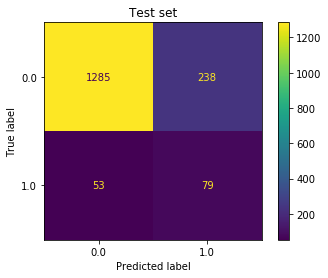

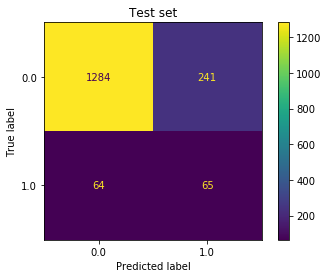

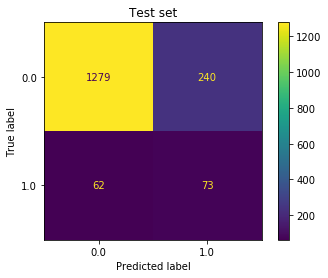

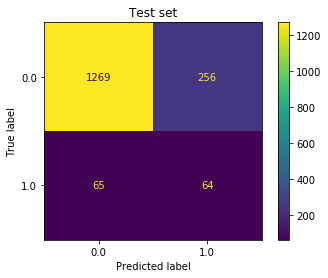

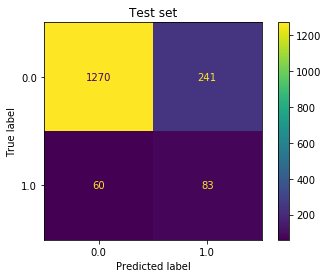

In [165]:
X = binary_df_7.drop(columns = ['updated_hosp'])
y = binary_df_7['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)

# nice!!!


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 88.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 17.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


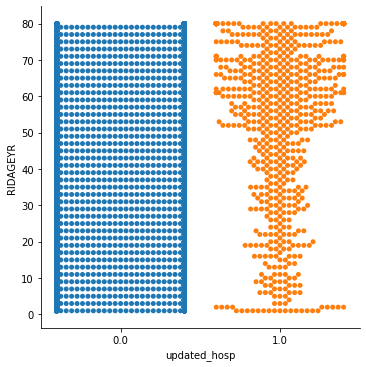

In [166]:
sns.catplot(x="updated_hosp", y="RIDAGEYR", data=binary_df_7, kind='swarm')

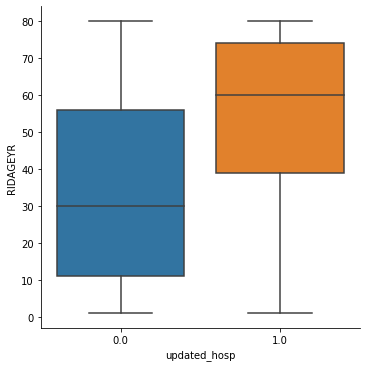

In [167]:
sns.catplot(x="updated_hosp", y="RIDAGEYR", data=binary_df_7, kind='box')

In [168]:
age_3 = age_2.drop(columns = ['RIDAGEYR', 'agemap'])
age_3

SEQN  0-5  18-49  50-59  60-69  70+
0     93703.00000    1      0      0      0    0
1     93704.00000    1      0      0      0    0
2     93705.00000    0      0      0      1    0
3     93706.00000    0      1      0      0    0
4     93707.00000    0      0      0      0    0
...           ...  ...    ...    ...    ...  ...
9249 102952.00000    0      0      0      0    1
9250 102953.00000    0      1      0      0    0
9251 102954.00000    0      1      0      0    0
9252 102955.00000    0      0      0      0    0
9253 102956.00000    0      1      0      0    0

[9254 rows x 6 columns]

In [169]:
binary_df_8 = binary_df_7.merge(age_3, how='left', on='SEQN').drop(columns = 'RIDAGEYR')
binary_df_8.set_index('SEQN', inplace=True)
binary_df_8

osteo_yrs  other_arth_yrs  heart_fail_binary  other_cond_binary  \
SEQN                                                                            
93703.00000     0.00000         0.00000            0.00000            0.00000   
93704.00000     0.00000         0.00000            0.00000            0.00000   
93705.00000     0.00000         1.00000            0.00000            0.00000   
93706.00000     0.00000         0.00000            0.00000            0.00000   
93707.00000     0.00000         0.00000            0.00000            0.00000   
...                 ...             ...                ...                ...   
102952.00000    0.00000         0.00000            0.00000            0.00000   
102953.00000    0.00000         0.00000            0.00000            0.00000   
102954.00000    0.00000         0.00000            0.00000            0.00000   
102955.00000    0.00000         0.00000            0.00000            0.00000   
102956.00000    1.00000         0.00000            0.00000            0.00000   

                COPD  asthma_yrs  other_resp_yrs  dm_binary  insulin_binary  \
SEQN                                                                          
93703.00000  0.00000     0.00000         0.00000    0.00000         0.00000   
93704.00000  0.00000     0.00000         0.00000    0.00000         0.00000   
93705.00000  0.00000     1.00000         0.00000    0.00000         0.00000   
93706.00000  0.00000     0.00000         0.00000    0.00000         0.00000   
93707.00000  0.00000     0.00000         0.00000    0.00000         0.00000   
...              ...         ...             ...        ...             ...   
102952.00000 0.00000     0.00000         0.00000    0.00000         0.00000   
102953.00000 0.00000     0.00000         0.00000    0.00000         0.00000   
102954.00000 0.00000     0.00000         0.00000    0.00000         0.00000   
102955.00000 0.00000     0.00000         0.00000    0.00000         0.00000   
102956.00000 0.00000     0.00000         0.00000    0.00000         0.00000   

              RIDRETH3_1.0  RIDRETH3_2.0  RIDRETH3_3.0  RIDRETH3_4.0  \
SEQN                                                                   
93703.00000              0             0             0             0   
93704.00000              0             0             1             0   
93705.00000              0             0             0             1   
93706.00000              0             0             0             0   
93707.00000              0             0             0             0   
...                    ...           ...           ...           ...   
102952.00000             0             0             0             0   
102953.00000             1             0             0             0   
102954.00000             0             0             0             1   
102955.00000             0             0             0             1   
102956.00000             0             0             1             0   

              RIDRETH3_6.0  unknown_dx  updated_hosp  0-5  18-49  50-59  \
SEQN                                                                      
93703.00000              1     0.00000       0.00000    1      0      0   
93704.00000              0     0.00000       0.00000    1      0      0   
93705.00000              0     0.00000       0.00000    0      0      0   
93706.00000              1     0.00000       0.00000    0      1      0   
93707.00000              0     0.00000       0.00000    0      0      0   
...                    ...         ...           ...  ...    ...    ...   
102952.00000             1     0.00000       0.00000    0      0      0   
102953.00000             0     0.00000       0.00000    0      1      0   
102954.00000             0     0.00000       0.00000    0      1      0   
102955.00000             0     0.00000       0.00000    0      0      0   
102956.00000             0     0.00000       0.00000    0      1      0   

              60-69

Classifier: ComplementNB()
Cross-validation folds: 5


ROC-AUC Cross Validation: [0.76658865 0.72050689 0.70432491 0.71636145 0.74613364]
Mean ROC-AUC Score: 0.731


Train mean recall: 0.62 +/- 0.01
Train mean precision: 0.22 +/- 0.0
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.61 +/- 0.04
Test mean precision: 0.22 +/- 0.01
Test mean F1: 0.32 +/- 0.02


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


weight  abs_weight
heart_fail_binary 5.10180     5.10180
unknown_dx        4.57190     4.57190
COPD              4.54400     4.54400
insulin_binary    4.50340     4.50340
other_resp_yrs    4.04840     4.04840
other_cond_binary 3.77770     3.77770
osteo_yrs         3.58840     3.58840
dm_binary         3.30210     3.30210
RIDRETH3_2.0      3.25540     3.25540
other_arth_yrs    3.21620     3.21620
50-59             3.11710     3.11710
70+               3.10890     3.10890
0-5               3.09420     3.09420
60-69             2.94280     2.94280
RIDRETH3_6.0      2.81380     2.81380
asthma_yrs        2.79450     2.79450
RIDRETH3_1.0      2.68550     2.68550
RIDRETH3_4.0      2.27570     2.27570
RIDRETH3_3.0      1.90980     1.90980
18-49             1.88830     1.88830

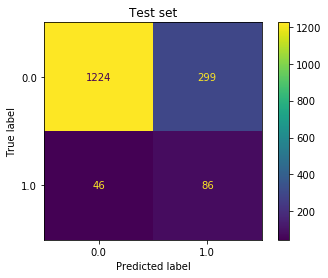

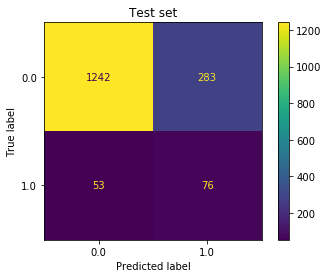

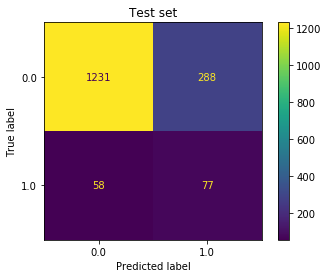

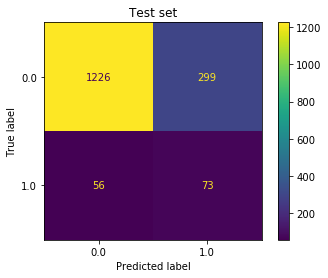

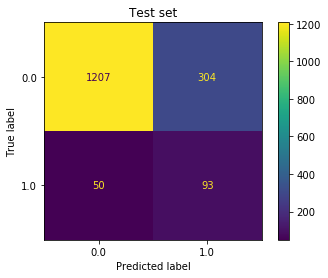

In [170]:
X = binary_df_8.drop(columns = ['updated_hosp'])
y = binary_df_8['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)

In [171]:
mcq_j

SEQN  MCQ010   MCQ025  MCQ035  MCQ040  MCQ050  AGQ030  MCQ053  \
0     93703.00000 2.00000      nan     nan     nan     nan     nan 2.00000   
1     93704.00000 2.00000      nan     nan     nan     nan     nan 2.00000   
2     93705.00000 1.00000 10.00000 2.00000     nan     nan     nan 2.00000   
3     93706.00000 2.00000      nan     nan     nan     nan     nan 2.00000   
4     93707.00000 2.00000      nan     nan     nan     nan     nan 2.00000   
...           ...     ...      ...     ...     ...     ...     ...     ...   
8892 102952.00000 2.00000      nan     nan     nan     nan     nan 2.00000   
8893 102953.00000 1.00000 42.00000 1.00000 1.00000 2.00000 1.00000 2.00000   
8894 102954.00000 2.00000      nan     nan     nan     nan     nan 2.00000   
8895 102955.00000 2.00000      nan     nan     nan     nan     nan 2.00000   
8896 102956.00000 2.00000      nan     nan     nan     nan     nan 2.00000   

      MCQ080  MCQ092  MCD093  MCQ149  MCQ151  RHD018  MCQ160A  MCD180A  \
0        nan     nan     nan     nan     nan     nan      nan      nan   
1        nan     nan     nan     nan     nan     nan      nan      nan   
2    2.00000 2.00000     nan     nan     nan     nan  1.00000 64.00000   
3    2.00000 2.00000     nan     nan     nan     nan      nan      nan   
4        nan 2.00000     nan     nan     nan     nan      nan      nan   
...      ...     ...     ...     ...     ...     ...      ...      ...   
8892 2.00000 2.00000     nan     nan     nan     nan  2.00000      nan   
8893 1.00000 2.00000     nan     nan     nan     nan  2.00000      nan   
8894 1.00000 2.00000     nan     nan     nan     nan  2.00000      nan   
8895     nan 2.00000     nan     nan     nan     nan      nan      nan   
8896 1.00000 2.00000     nan     nan     nan     nan  1.00000 27.00000   

      MCQ195  MCQ160N  MCD180N  MCQ160B  MCD180B  MCQ160C  MCD180C  MCQ160D  \
0        nan      nan      nan      nan      nan      nan      nan      nan   
1        nan      nan      nan      nan      nan      nan      nan      nan   
2    2.00000  2.00000      nan  2.00000      nan  2.00000      nan  2.00000   
3        nan      nan      nan      nan      nan      nan      nan      nan   
4        nan      nan      nan      nan      nan      nan      nan      nan   
...      ...      ...      ...      ...      ...      ...      ...      ...   
8892     nan  2.00000      nan  2.00000      nan  2.00000      nan  2.00000   
8893     nan  2.00000      nan  2.00000      nan  2.00000      nan  2.00000   
8894     nan  2.00000      nan  2.00000      nan  2.00000      nan  2.00000   
8895     nan      nan      nan      nan      nan      nan      nan      nan   
8896 1.00000  2.00000      nan  2.00000      nan  2.00000      nan  2.00000   

      MCD180D  MCQ160E  MCD180E  MCQ160F  MCD180F  MCQ160M  MCQ170M  MCD180M  \
0         nan      nan      nan      nan      nan      nan      nan      nan   
1         nan      nan      nan      nan      nan      nan      nan      nan   
2         nan  2.00000      nan  2.00000      nan  2.00000      nan      nan   
3         nan      nan      nan      nan      nan      nan      nan      nan   
4         nan      nan      nan      nan      nan      nan      nan      nan   
...       ...      ...      ...      ...      ...      ...      ...      ...   
8892      nan  2.00000      nan  2.00000      nan  2.00000      nan      nan   
8893      nan  2.00000      nan  2.00000      nan  2.00000      nan      nan   
8894      nan  2.00000      nan  2.00000      nan  2.00000      nan      nan   
8895      nan      nan      nan      nan      nan      nan      nan      nan   
8896      nan  2.00000      nan  2.00000      nan  2.00000      nan      nan   

      MCQ160G  MCD180G  MCQ160K  MCQ170K  MCD180K  MCQ160O  MCQ160L  MCQ170L  \
0         nan      nan      nan      nan      nan      nan      nan      nan   
1         nan      nan      nan      nan      nan      nan      nan      nan   
2     2.00000      nan  2.00000      

In [172]:
liver = mcq_j[['SEQN',
       'MCQ170L', # do you still have a liver condition
       'MCD180L']] #  Age when told you had a liver condition

liver


SEQN  MCQ170L  MCD180L
0     93703.00000      nan      nan
1     93704.00000      nan      nan
2     93705.00000      nan      nan
3     93706.00000      nan      nan
4     93707.00000      nan      nan
...           ...      ...      ...
8892 102952.00000      nan      nan
8893 102953.00000  2.00000 34.00000
8894 102954.00000      nan      nan
8895 102955.00000      nan      nan
8896 102956.00000      nan      nan

[8897 rows x 3 columns]

In [173]:
liver['MCQ170L'].value_counts()

# 1 - yes
# 2 - no
# 9 - don't know


1.00000    162
2.00000    106
9.00000     26
Name: MCQ170L, dtype: int64

In [174]:
liver['MCD180L'].value_counts()

# need to remove 99999.00000

16.00000       16
55.00000       13
40.00000       13
60.00000       11
50.00000       11
48.00000       10
35.00000        9
39.00000        8
58.00000        7
25.00000        7
54.00000        7
46.00000        7
56.00000        6
45.00000        6
59.00000        6
65.00000        6
34.00000        6
61.00000        6
64.00000        5
70.00000        5
52.00000        5
62.00000        5
22.00000        5
53.00000        5
51.00000        5
99999.00000     5
24.00000        5
28.00000        4
21.00000        4
29.00000        4
30.00000        4
80.00000        4
27.00000        4
37.00000        4
47.00000        4
20.00000        4
38.00000        3
42.00000        3
33.00000        3
18.00000        3
32.00000        3
66.00000        3
19.00000        3
68.00000        3
43.00000        3
67.00000        3
69.00000        3
57.00000        2
49.00000        2
73.00000        2
77.00000        2
17.00000        2
63.00000        2
36.00000        2
26.00000        2
31.00000  

In [175]:
liver['MCD180L'] = replace_with_median(liver['MCD180L'], 99999.00000)
liver['MCD180L'].value_counts()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


16.00000    16
55.00000    13
40.00000    13
60.00000    11
50.00000    11
48.00000    10
35.00000     9
47.00000     9
39.00000     8
25.00000     7
54.00000     7
46.00000     7
58.00000     7
56.00000     6
45.00000     6
59.00000     6
65.00000     6
61.00000     6
34.00000     6
64.00000     5
24.00000     5
70.00000     5
62.00000     5
22.00000     5
51.00000     5
53.00000     5
52.00000     5
37.00000     4
20.00000     4
27.00000     4
30.00000     4
28.00000     4
21.00000     4
80.00000     4
29.00000     4
38.00000     3
18.00000     3
42.00000     3
33.00000     3
32.00000     3
66.00000     3
68.00000     3
19.00000     3
43.00000     3
67.00000     3
69.00000     3
74.00000     2
17.00000     2
73.00000     2
31.00000     2
77.00000     2
63.00000     2
57.00000     2
36.00000     2
26.00000     2
49.00000     2
76.00000     1
23.00000     1
79.00000     1
44.00000     1
72.00000     1
Name: MCD180L, dtype: int64

In [176]:
liver_2 = liver.merge(age, how='left', on='SEQN')
liver_2

SEQN  MCQ170L  MCD180L  RIDAGEYR agemap
0     93703.00000      nan      nan   2.00000    0-5
1     93704.00000      nan      nan   2.00000    0-5
2     93705.00000      nan      nan  66.00000  60-69
3     93706.00000      nan      nan  18.00000  18-49
4     93707.00000      nan      nan  13.00000   6-17
...           ...      ...      ...       ...    ...
8892 102952.00000      nan      nan  70.00000    70+
8893 102953.00000  2.00000 34.00000  42.00000  18-49
8894 102954.00000      nan      nan  41.00000  18-49
8895 102955.00000      nan      nan  14.00000   6-17
8896 102956.00000      nan      nan  38.00000  18-49

[8897 rows x 5 columns]

In [177]:
liver_2['yrs_with_liver'] = liver_2['RIDAGEYR'] - liver_2['MCD180L']
liver_2['liver_binary'] = np.where(liver_2['yrs_with_liver'] > 0, 1, 0)
liver_2['liver_binary'] = np.where(liver_2['MCQ170L'] == 1, liver_2['liver_binary'], 0)
liver_2.head(200)

SEQN  MCQ170L  MCD180L  RIDAGEYR agemap  yrs_with_liver  \
0   93703.00000      nan      nan   2.00000    0-5             nan   
1   93704.00000      nan      nan   2.00000    0-5             nan   
2   93705.00000      nan      nan  66.00000  60-69             nan   
3   93706.00000      nan      nan  18.00000  18-49             nan   
4   93707.00000      nan      nan  13.00000   6-17             nan   
5   93708.00000      nan      nan  66.00000  60-69             nan   
6   93709.00000      nan      nan  75.00000    70+             nan   
7   93711.00000      nan      nan  56.00000  50-59             nan   
8   93712.00000      nan      nan  18.00000  18-49             nan   
9   93713.00000      nan      nan  67.00000  60-69             nan   
10  93714.00000      nan      nan  54.00000  50-59             nan   
11  93715.00000      nan      nan  71.00000    70+             nan   
12  93716.00000      nan      nan  61.00000  60-69             nan   
13  93717.00000      nan      nan  22.00000  18-49             nan   
14  93718.00000      nan      nan  45.00000  18-49             nan   
15  93719.00000      nan      nan  13.00000   6-17             nan   
16  93720.00000      nan      nan   1.00000    0-5             nan   
17  93721.00000      nan      nan  60.00000  60-69             nan   
18  93722.00000      nan      nan  60.00000  60-69             nan   
19  93723.00000      nan      nan  64.00000  60-69             nan   
20  93724.00000      nan      nan   5.00000   6-17             nan   
21  93725.00000      nan      nan   9.00000   6-17             nan   
22  93726.00000      nan      nan  67.00000  60-69             nan   
23  93727.00000      nan      nan  70.00000    70+             nan   
24  93728.00000      nan      nan  53.00000  50-59             nan   
25  93729.00000      nan      nan  42.00000  18-49             nan   
26  93730.00000      nan      nan  57.00000  50-59             nan   
27  93731.00000      nan      nan  20.00000  18-49             nan   
28  93732.00000      nan      nan  72.00000    70+             nan   
29  93733.00000      nan      nan  11.00000   6-17             nan   
30  93734.00000      nan      nan  13.00000   6-17             nan   
31  93735.00000      nan      nan  52.00000  50-59             nan   
32  93736.00000      nan      nan  11.00000   6-17             nan   
33  93737.00000      nan      nan   8.00000   6-17             nan   
34  93738.00000      nan      nan  26.00000  18-49             nan   
35  93739.00000      nan      nan   5.00000   6-17             nan   
36  93740.00000      nan      nan  72.00000    70+             nan   
37  93741.00000      nan      nan   9.00000   6-17             nan   
38  93742.00000      nan      nan  72.00000    70+             nan   
39  93743.00000  1.00000 60.00000  61.00000  60-69         1.00000   
40  93744.00000      nan      nan  10.00000   6-17             nan   
41  93745.00000      nan      nan   5.00000   6-17             nan   
42  93746.00000      nan      nan  25.00000  18-49             nan   
43  93747.00000      nan      nan  13.00000   6-17             nan   
44  93749.00000      nan      nan   1.00000    0-5             nan   
45  93750.00000      nan      nan  52.00000  50-59             nan   
46  93751.00000      nan      nan   7.00000   6-17             nan   
47  93752.00000      nan      nan  73.00000    70+             nan   
48  93753.00000      nan      nan  10.00000   6-17             nan   
49  93754.00000      nan      nan  72.00000    70+             nan   
50  93755.00000      nan      nan  26.00000  18-49             nan   
51  93756.00000      nan      nan  64.00000  60-69             nan   
52  93757.00000      nan      nan  63.00000  60-69             nan   
53  93758.00000      nan      nan  55.00000  50-59             nan   
54  93759.00000      nan      nan  60.00000  60-69             nan   
55  93760.00000      nan      nan  54.00000  50-59             nan   
56  93761.00000      

In [178]:
liver_3 = liver_2[['SEQN', 'liver_binary']]
liver_3['liver_binary']

0       0
1       0
2       0
3       0
4       0
       ..
8892    0
8893    0
8894    0
8895    0
8896    0
Name: liver_binary, Length: 8897, dtype: int64

In [179]:
binary_df_9 = binary_df_8.merge(liver_3, how='left', on='SEQN').set_index('SEQN')
binary_df_9

osteo_yrs  other_arth_yrs  heart_fail_binary  other_cond_binary  \
SEQN                                                                            
93703.00000     0.00000         0.00000            0.00000            0.00000   
93704.00000     0.00000         0.00000            0.00000            0.00000   
93705.00000     0.00000         1.00000            0.00000            0.00000   
93706.00000     0.00000         0.00000            0.00000            0.00000   
93707.00000     0.00000         0.00000            0.00000            0.00000   
...                 ...             ...                ...                ...   
102952.00000    0.00000         0.00000            0.00000            0.00000   
102953.00000    0.00000         0.00000            0.00000            0.00000   
102954.00000    0.00000         0.00000            0.00000            0.00000   
102955.00000    0.00000         0.00000            0.00000            0.00000   
102956.00000    1.00000         0.00000            0.00000            0.00000   

                COPD  asthma_yrs  other_resp_yrs  dm_binary  insulin_binary  \
SEQN                                                                          
93703.00000  0.00000     0.00000         0.00000    0.00000         0.00000   
93704.00000  0.00000     0.00000         0.00000    0.00000         0.00000   
93705.00000  0.00000     1.00000         0.00000    0.00000         0.00000   
93706.00000  0.00000     0.00000         0.00000    0.00000         0.00000   
93707.00000  0.00000     0.00000         0.00000    0.00000         0.00000   
...              ...         ...             ...        ...             ...   
102952.00000 0.00000     0.00000         0.00000    0.00000         0.00000   
102953.00000 0.00000     0.00000         0.00000    0.00000         0.00000   
102954.00000 0.00000     0.00000         0.00000    0.00000         0.00000   
102955.00000 0.00000     0.00000         0.00000    0.00000         0.00000   
102956.00000 0.00000     0.00000         0.00000    0.00000         0.00000   

              RIDRETH3_1.0  RIDRETH3_2.0  RIDRETH3_3.0  RIDRETH3_4.0  \
SEQN                                                                   
93703.00000              0             0             0             0   
93704.00000              0             0             1             0   
93705.00000              0             0             0             1   
93706.00000              0             0             0             0   
93707.00000              0             0             0             0   
...                    ...           ...           ...           ...   
102952.00000             0             0             0             0   
102953.00000             1             0             0             0   
102954.00000             0             0             0             1   
102955.00000             0             0             0             1   
102956.00000             0             0             1             0   

              RIDRETH3_6.0  unknown_dx  updated_hosp  0-5  18-49  50-59  \
SEQN                                                                      
93703.00000              1     0.00000       0.00000    1      0      0   
93704.00000              0     0.00000       0.00000    1      0      0   
93705.00000              0     0.00000       0.00000    0      0      0   
93706.00000              1     0.00000       0.00000    0      1      0   
93707.00000              0     0.00000       0.00000    0      0      0   
...                    ...         ...           ...  ...    ...    ...   
102952.00000             1     0.00000       0.00000    0      0      0   
102953.00000             0     0.00000       0.00000    0      1      0   
102954.00000             0     0.00000       0.00000    0      1      0   
102955.00000             0     0.00000       0.00000    0      0      0   
102956.00000             0     0.00000       0.00000    0      1      0   

              60-69

Classifier: ComplementNB()
Cross-validation folds: 5


ROC-AUC Cross Validation: [0.76633597 0.71923151 0.70792118 0.71755941 0.7462392 ]
Mean ROC-AUC Score: 0.731


Train mean recall: 0.62 +/- 0.01
Train mean precision: 0.22 +/- 0.0
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.61 +/- 0.04
Test mean precision: 0.22 +/- 0.02
Test mean F1: 0.32 +/- 0.02


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


weight  abs_weight
liver_binary      5.16970     5.16970
heart_fail_binary 5.10760     5.10760
unknown_dx        4.57760     4.57760
COPD              4.54970     4.54970
insulin_binary    4.50910     4.50910
other_resp_yrs    4.05410     4.05410
other_cond_binary 3.78340     3.78340
osteo_yrs         3.59410     3.59410
dm_binary         3.30780     3.30780
RIDRETH3_2.0      3.26110     3.26110
other_arth_yrs    3.22190     3.22190
50-59             3.12280     3.12280
70+               3.11460     3.11460
0-5               3.09990     3.09990
60-69             2.94850     2.94850
RIDRETH3_6.0      2.81950     2.81950
asthma_yrs        2.80020     2.80020
RIDRETH3_1.0      2.69120     2.69120
RIDRETH3_4.0      2.28140     2.28140
RIDRETH3_3.0      1.91550     1.91550
18-49             1.89400     1.89400

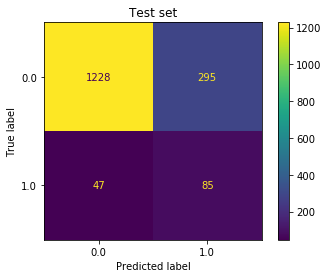

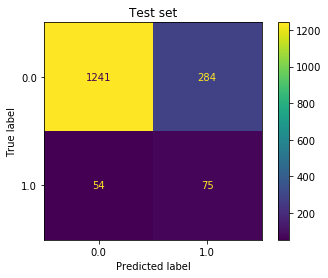

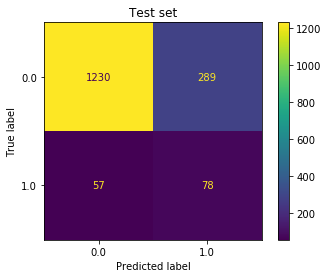

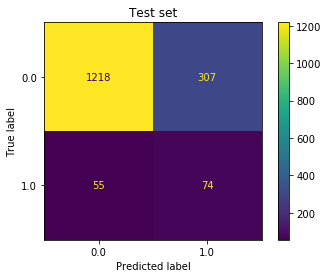

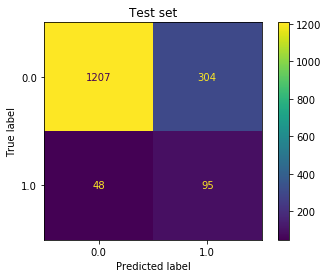

In [215]:
# define X and y

X = binary_df_9.drop(columns = ['updated_hosp'])
y = binary_df_9['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)

# no improvement

In [192]:
y_training_array = y_training.to_numpy().reshape((8271,1))

In [193]:
type(y_training_array)

numpy.ndarray

In [194]:
y_training_array.shape

(8271, 1)

In [195]:
type(y_training_array[0][0])

numpy.float64

In [196]:
# !pip install -U tensorflow==2.4.1
# !pip install Keras==2.2.4

print(keras.__version__)

2.2.4


In [206]:
X_train_scaled_reindex = X_train_scaled.reset_index(drop=True)
X_train_scaled_reindex

osteo_yrs  other_arth_yrs  heart_fail_binary  other_cond_binary    COPD  \
0       0.00000         0.00000            0.00000            0.00000 0.00000   
1       0.00000         0.00000            0.00000            1.00000 0.00000   
2       0.00000         0.00000            0.00000            0.00000 0.00000   
3       0.00000         0.00000            0.00000            0.00000 0.00000   
4       0.00000         0.00000            0.00000            0.00000 0.00000   
...         ...             ...                ...                ...     ...   
8266    0.00000         0.00000            0.00000            0.00000 0.00000   
8267    0.00000         0.00000            0.00000            0.00000 0.00000   
8268    0.00000         0.00000            1.00000            0.00000 0.00000   
8269    0.00000         0.00000            0.00000            0.00000 0.00000   
8270    0.00000         0.00000            0.00000            0.00000 0.00000   

      asthma_yrs  other_resp_yrs  dm_binary  insulin_binary  RIDRETH3_1.0  \
0        0.00000         0.00000    0.00000         0.00000       0.00000   
1        0.00000         0.00000    0.00000         0.00000       0.00000   
2        0.00000         0.00000    0.00000         0.00000       0.00000   
3        0.00000         0.00000    0.00000         0.00000       1.00000   
4        0.00000         0.00000    0.00000         0.00000       0.00000   
...          ...             ...        ...             ...           ...   
8266     0.00000         0.00000    0.00000         0.00000       0.00000   
8267     0.00000         0.00000    0.00000         0.00000       0.00000   
8268     0.00000         0.00000    0.00000         0.00000       0.00000   
8269     1.00000         0.00000    0.00000         0.00000       0.00000   
8270     0.00000         0.00000    0.00000         0.00000       0.00000   

      RIDRETH3_2.0  RIDRETH3_3.0  RIDRETH3_4.0  RIDRETH3_6.0  unknown_dx  \
0          0.00000       1.00000       0.00000       0.00000     0.00000   
1          0.00000       1.00000       0.00000       0.00000     0.00000   
2          0.00000       1.00000       0.00000       0.00000     0.00000   
3          0.00000       0.00000       0.00000       0.00000     0.00000   
4          1.00000       0.00000       0.00000       0.00000     0.00000   
...            ...           ...           ...           ...         ...   
8266       0.00000       0.00000       1.00000       0.00000     0.00000   
8267       0.00000       0.00000       0.00000       0.00000     0.00000   
8268       0.00000       1.00000       0.00000       0.00000     0.00000   
8269       0.00000       0.00000       0.00000       0.00000     0.00000   
8270       0.00000       1.00000       0.00000       0.00000     0.00000   

         0-5   18-49   50-59   60-69     70+  liver_binary  
0    0.00000 0.00000 0.00000 0.00000 0.00000       0.00000  
1    0.00000 1.00000 0.00000 0.00000 0.00000       0.00000  
2    0.00000 0.00000 0.00000 0.00000 0.00000       0.00000  
3    0.00000 1.00000 0.00000 0.00000 0.00000       0.00000  
4    0.00000 1.00000 0.00000 0.00000 0.00000       0.00000  
...      ...     ...     ...     ...     ...           ...  
8266 0.00000 1.00000 0.00000 0.00000 0.00000       0.00000  
8267 0.00000 0.00000 0.00000 0.00000 0.00000       0.00000  
8268 0.00000 0.00000 0.00000 0.00000 1.00000       0.00000  
8269 0.00000 0.00000 0.00000 0.00000 0.00000       0.00000  
8270 0.00000 0.00000 0.00000 0.00000 0.00000       0.00000  

[8271 rows x 21 columns]

In [214]:
nn.fit(X_train_scaled_reindex, y_training_array, epochs=10, validation_split=0.1)

Epoch 1/10
233/233 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0818 - val_loss: 0.0000e+00 - val_accuracy: 0.0797
Epoch 2/10
233/233 [==============================] - 0s 872us/step - loss: 0.0000e+00 - accuracy: 0.0802 - val_loss: 0.0000e+00 - val_accuracy: 0.0797
Epoch 3/10
233/233 [==============================] - 0s 933us/step - loss: 0.0000e+00 - accuracy: 0.0828 - val_loss: 0.0000e+00 - val_accuracy: 0.0797
Epoch 4/10
233/233 [==============================] - 0s 852us/step - loss: 0.0000e+00 - accuracy: 0.0836 - val_loss: 0.0000e+00 - val_accuracy: 0.0797
Epoch 5/10
233/233 [==============================] - 0s 892us/step - loss: 0.0000e+00 - accuracy: 0.0832 - val_loss: 0.0000e+00 - val_accuracy: 0.0797
Epoch 6/10
233/233 [==============================] - 0s 868us/step - loss: 0.0000e+00 - accuracy: 0.0816 - val_loss: 0.0000e+00 - val_accuracy: 0.0797
Epoch 7/10
233/233 [==============================] - 0s 835us/step - loss: 0.0000e+00 - a

In [ ]:
# make a df
# pd.DataFrame(columns =)

nn.predict(X_t)